In [1]:
!pip install noisereduce > noisereduce.log
!pip install keras_nlp > keras_nlp.log
!pip install kapre > kapre.log
#%pip install torch > torch.log

In [3]:
from scipy.io import wavfile
import noisereduce as nr
import numpy as np
import soundfile as sf # poder carregar um arquivo no formato .flac
import librosa as lb
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import keras_nlp
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D
from keras_nlp.layers import TransformerEncoder, TransformerDecoder, RandomDeletion
from tensorflow.keras import layers
from kapre.augmentation import SpecAugment
from kapre.composed import get_melspectrogram_layer
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

2023-11-03 14:38:33.798457: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-03 14:38:33.920639: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-03 14:38:33.921497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 14:38:34.635658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


In [4]:
directorio_audio = '/home/andres/Área de Trabalho/Andrés Peralta/Tesis/Código/Completo/1s/44Hz.Wav'

In [5]:
audios = [audio for audio in os.listdir('/home/andres/Área de Trabalho/Andrés Peralta/Tesis/Código/Completo/1s/44Hz.Wav') if os.path.isfile('/home/andres/Área de Trabalho/Andrés Peralta/Tesis/Código/Completo/1s/44Hz.Wav' + '/' + audio) ]

for audio in audios:
  signal, sr = sf.read('/home/andres/Área de Trabalho/Andrés Peralta/Tesis/Código/Completo/1s/44Hz.Wav' + '/' + audio, dtype='float32')
  signal = signal.T
  signal_22k = lb.resample(signal, orig_sr=sr, target_sr=22050, scale=True)
  sf.write('/home/andres/Área de Trabalho/Andrés Peralta/Tesis/Código/Completo/1s' + '/' + audio, signal_22k, 22050, subtype= 'PCM_16')

In [7]:
audios = os.listdir(directorio_audio)

In [8]:
def normalize_signal(s):
    return s/np.max(np.abs(s))

In [ ]:
# Ruta del directorio para cargar los  audios
directorio_audio = '/home/andres/Área de Trabalho/Andrés Peralta/Tesis/Código/44Hz.Wav'

# Obtener la lista de los nombres de los archivos de audio en el directorio
audios = [archivo for archivo in os.listdir(directorio_audio) if archivo.endswith('.wav')]

# Crear la carpeta segments si no existe
segments_dir = os.path.join(directorio_audio, 'segments')
if not os.path.exists(segments_dir):
    os.makedirs(segments_dir)

# Crear las carpetas train y test dentro de segments si no existen
train_dir = os.path.join(segments_dir, 'train')
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
test_dir = os.path.join(segments_dir, 'test')
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Crear la carpeta silence en train y test para guardar lso segmentos que no tienen sonido
silence_train_dir = os.path.join(train_dir, 'silence')
if not os.path.exists(silence_train_dir):
    os.makedirs(silence_train_dir)
silence_test_dir = os.path.join(test_dir, 'silence')
if not os.path.exists(silence_test_dir):
    os.makedirs(silence_test_dir)

# Lista para almacenar los valores de energía RMS
rms_list = []

for audio in audios:
    input_wavfile = os.path.join(directorio_audio, audio)
    sr, signal = wavfile.read(input_wavfile)
    signal = normalize_signal(signal)
    # Realizar la reducción de ruido a los audios
    filtered_signal = nr.reduce_noise(y=signal, sr=sr)
    filtered_signal = normalize_signal(filtered_signal)
    segments = lb.effects._signal_to_frame_nonsilent(filtered_signal,
                                                     frame_length=sr,  # frame_length igual a sr
                                                     hop_length=int(sr/2),  # hop_length igual a la mitad de sr
                                                     top_db=15)
    # Se obtiene el nombre del archivo sin la extensión para crear la carpeta
    audio_name = os.path.splitext(audio)[0]

    if '1' in audio_name:
        # Almacenar los audios con un 1 en la carpeta test
        audio_test_dir = os.path.join(test_dir, audio_name)
        if not os.path.exists(audio_test_dir):
            os.makedirs(audio_test_dir)
    else:
        # Almacenar los demas audios en la carpeta train
        audio_train_dir = os.path.join(train_dir, audio_name)
        if not os.path.exists(audio_train_dir):
            os.makedirs(audio_train_dir)

    # CRear la carpeta 'silence' en 'test' y 'train'
    silence_dir = silence_test_dir if '1' in audio_name else silence_train_dir

    # Guardar la señal reducida en un nuevo archivo y generar gráficos
    for i in range(len(segments)):
        segment = filtered_signal[i * int(sr/2):sr + i * int(sr/2)]
        rms_value = lb.feature.rms(y=segment, frame_length=sr, hop_length=sr + 1)[0][0]
        rms_list.append(rms_value)

        out_file = f"{audio_name}_segment_{i}.wav"
        out_path = os.path.join(audio_test_dir if '1' in audio_name else audio_train_dir, out_file)
        
        if segments[i]:
            color = 'blue'  # Color azul para segmentos con sonido
        else:
            color = 'red'  # Color rojo para segmentos en silencio
            out_path = os.path.join(silence_dir, out_file)
            
        wavfile.write(out_path, sr, segment)

        # Generar gráfico con el color especificado
        plt.figure(figsize=(25, 1))
        plt.plot(segment, color=color)
        plt.ylim([-1, 1])
        plt.show()


/tmp/ipykernel_8359/4202152347.py:24: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, signal = wavfile.read(input_wavfile)


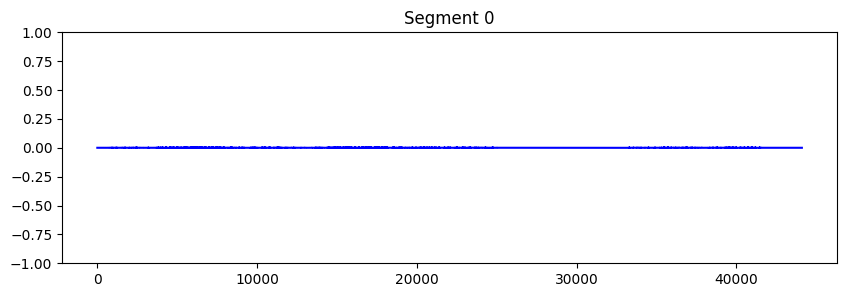

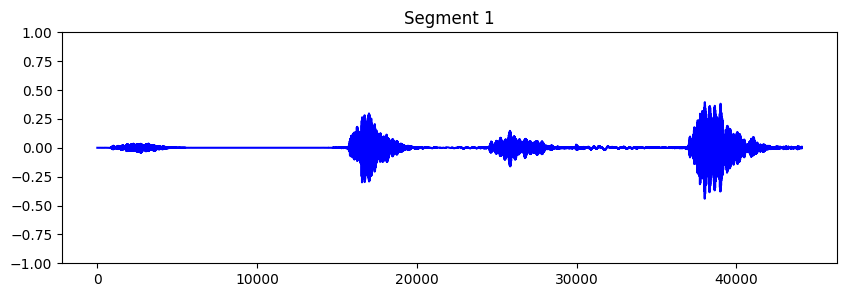

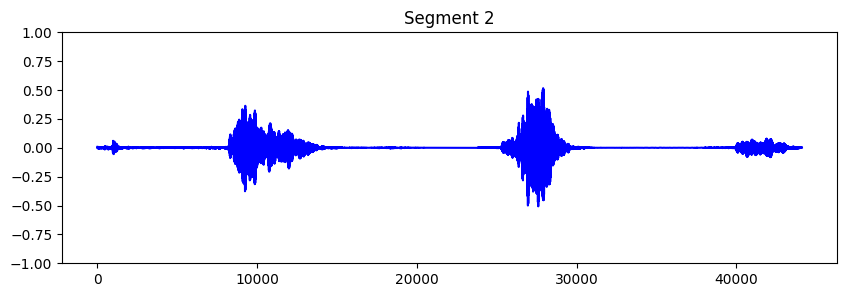

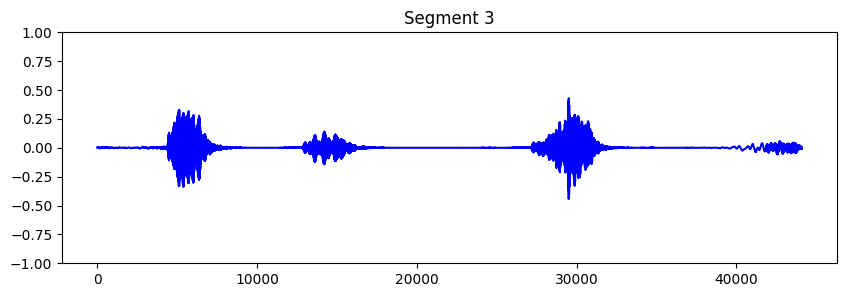

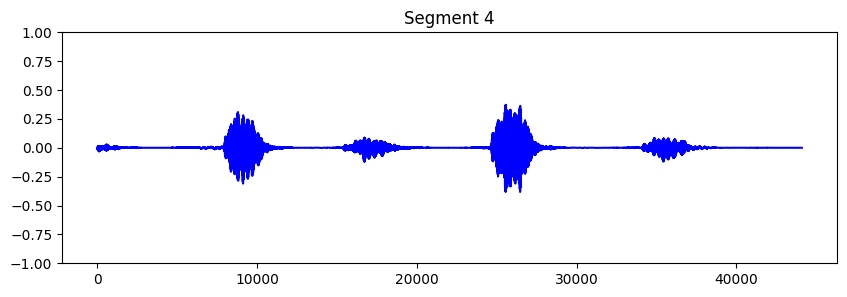

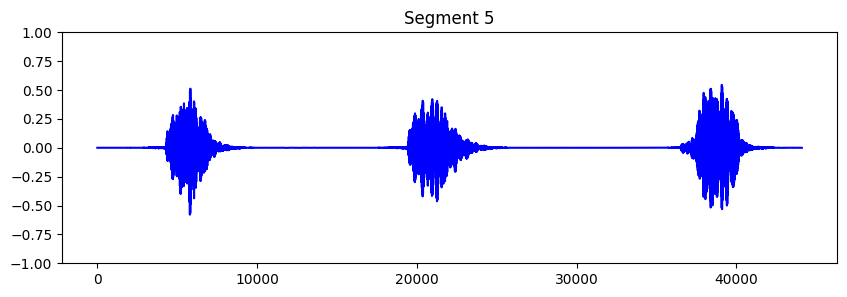

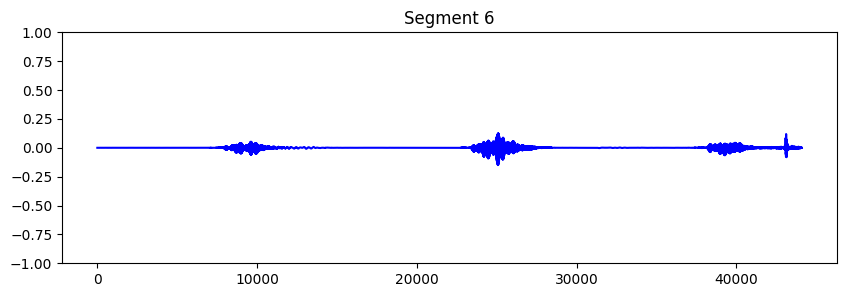

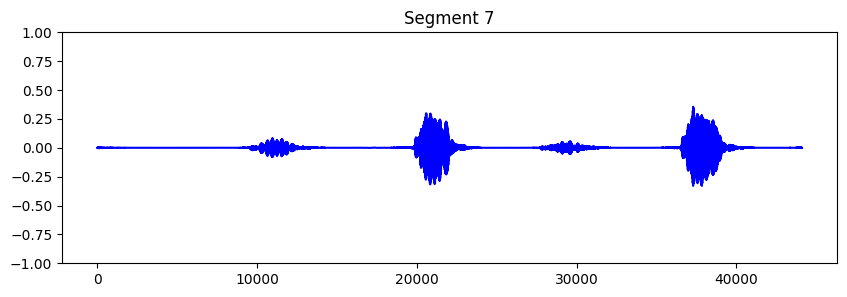

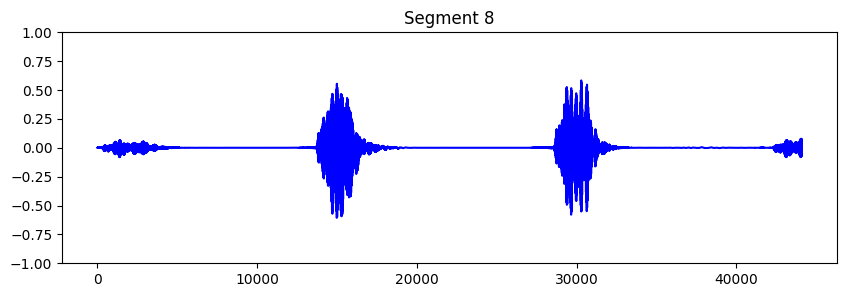

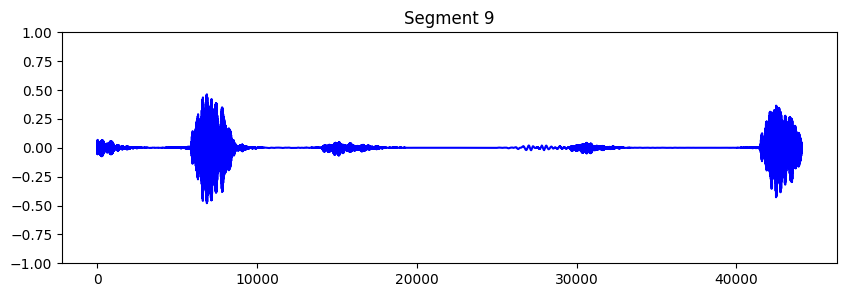

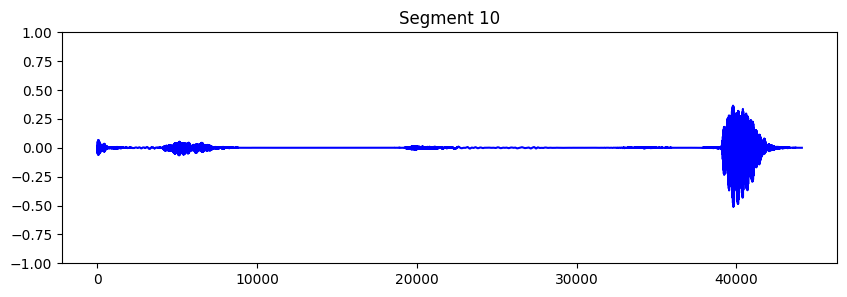

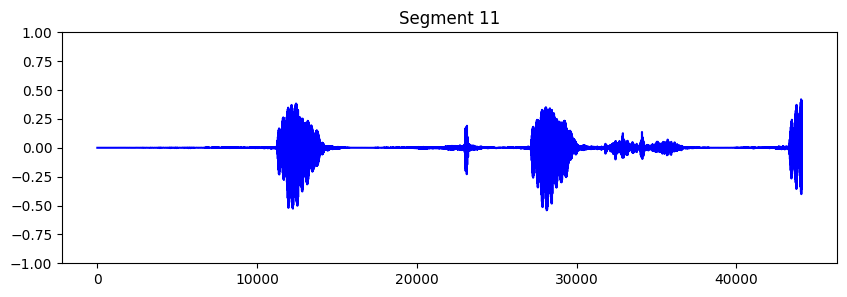

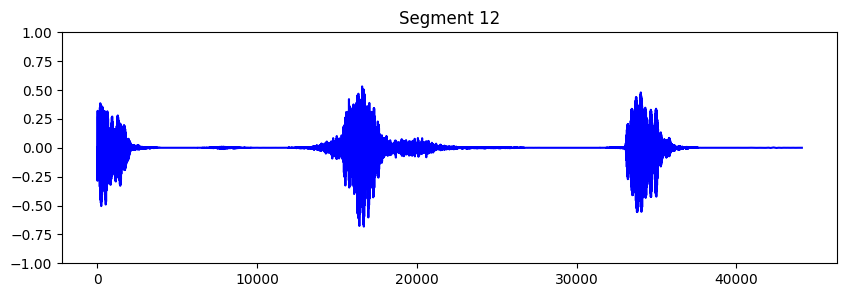

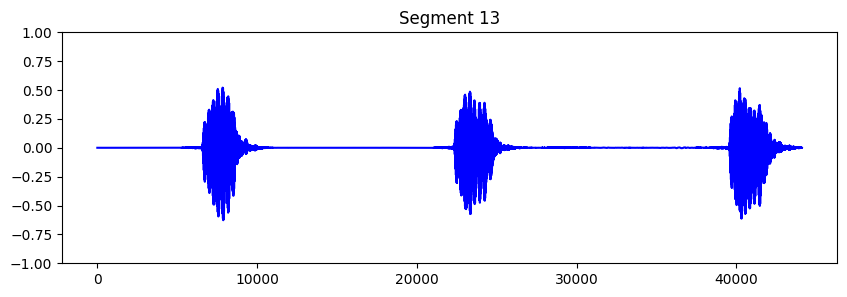

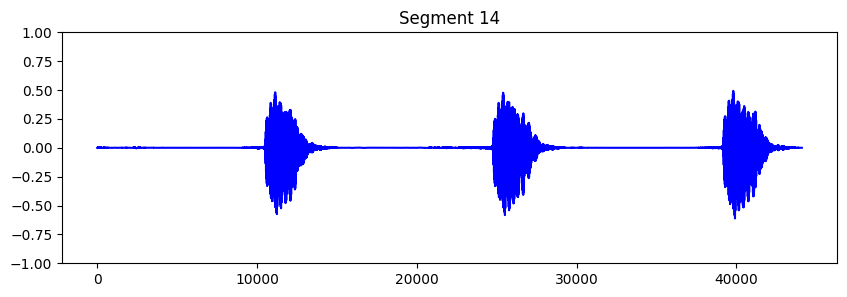

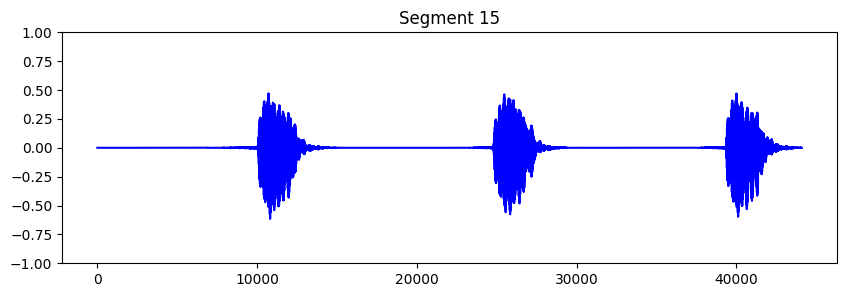

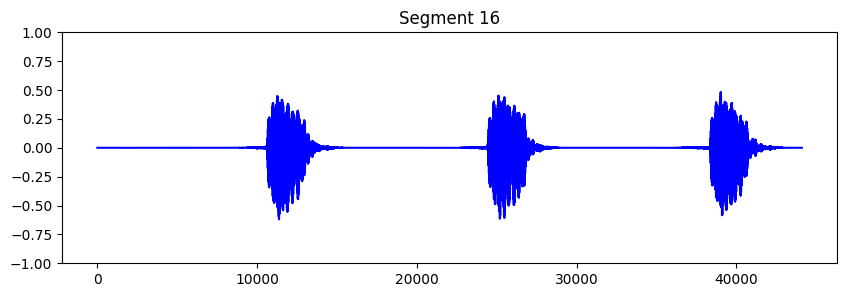

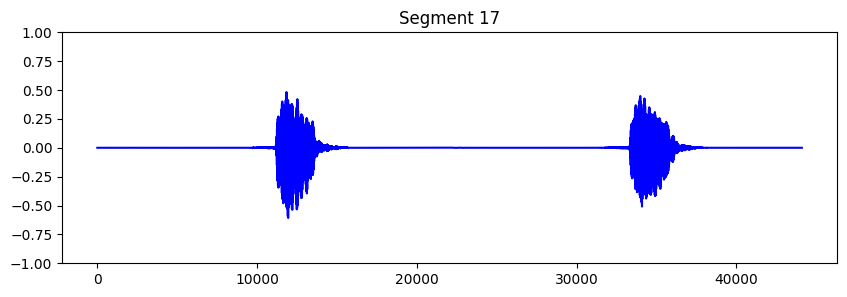

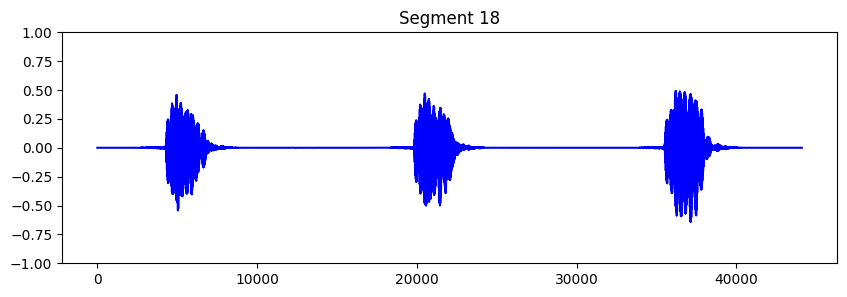

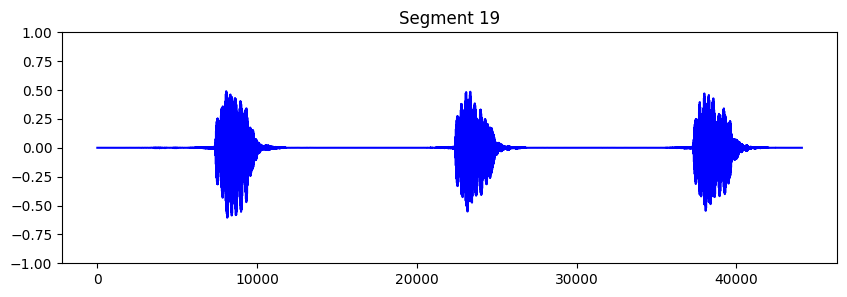

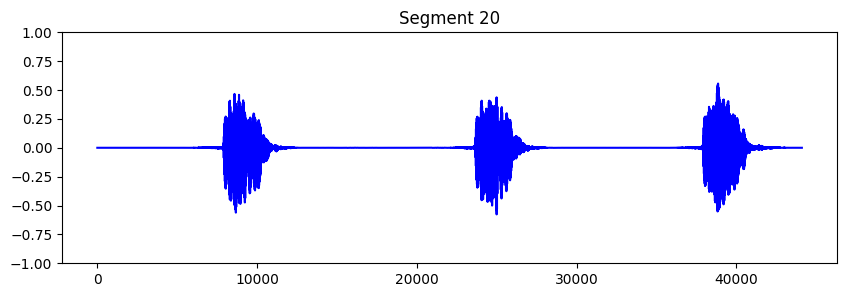

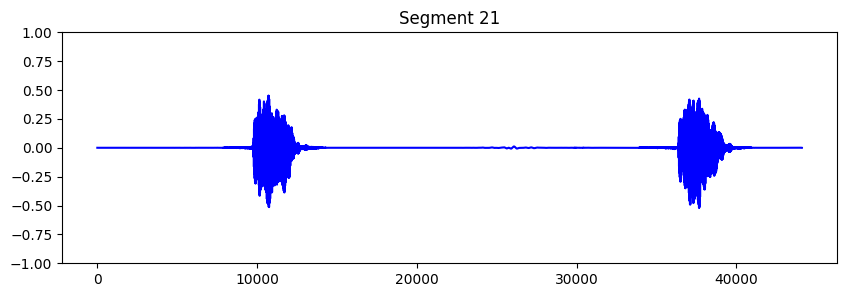

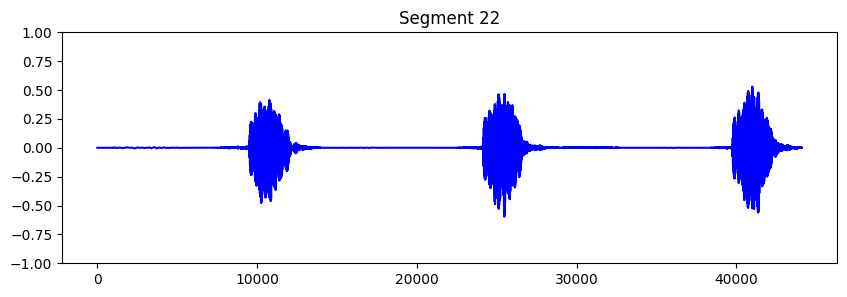

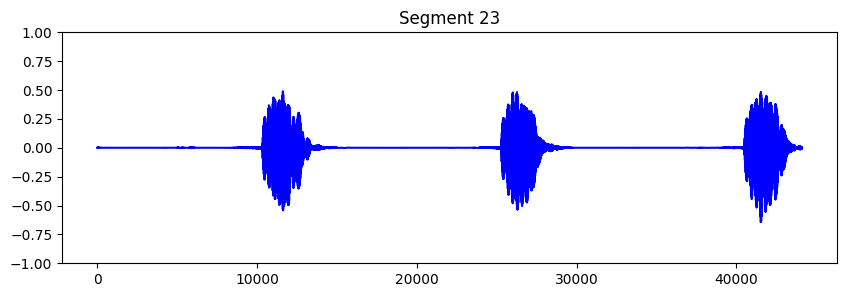

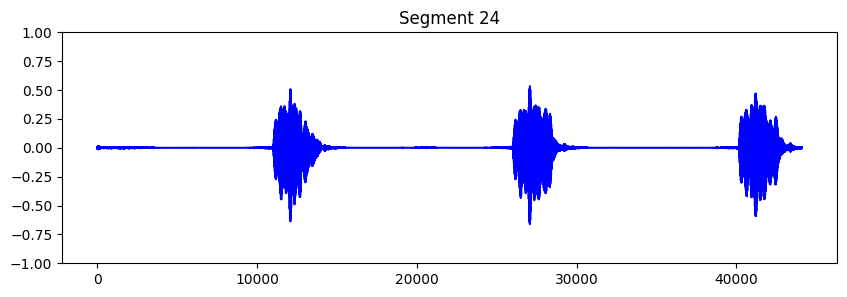

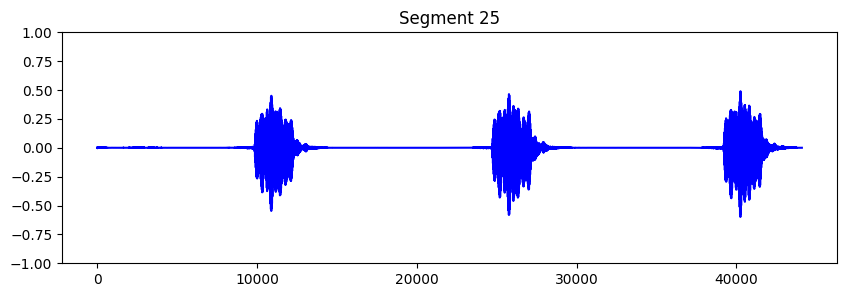

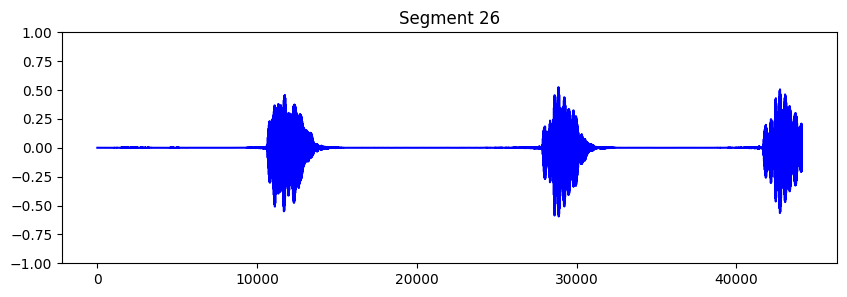

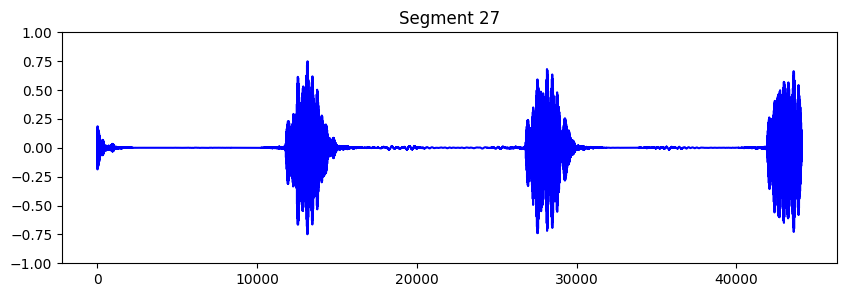

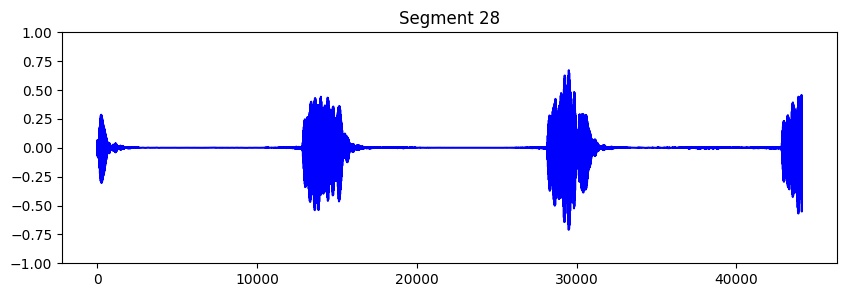

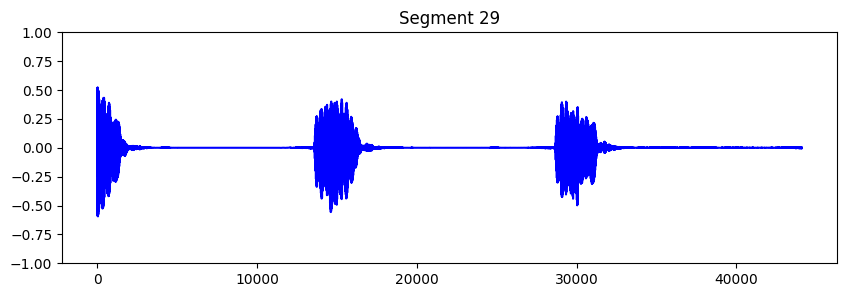

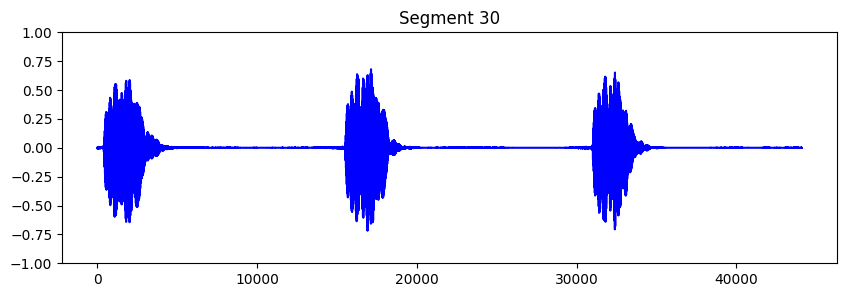

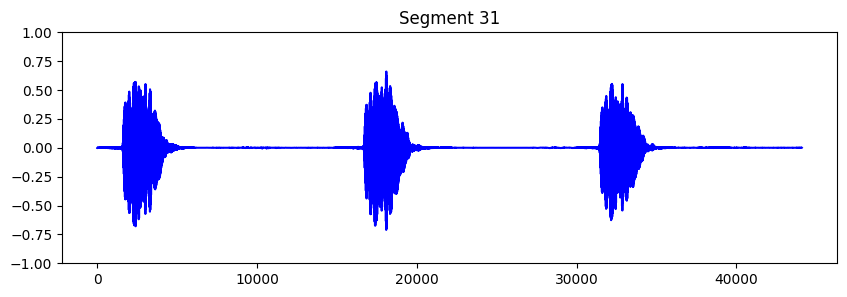

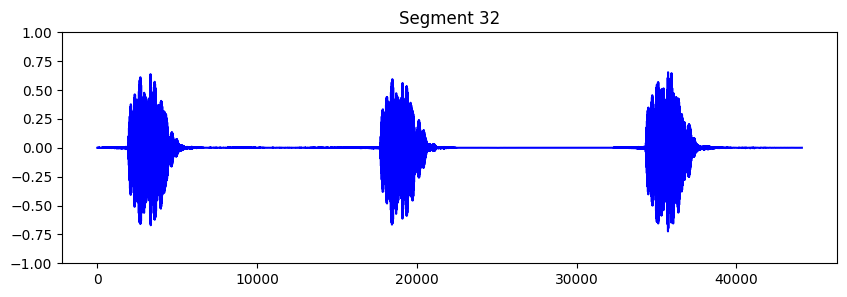

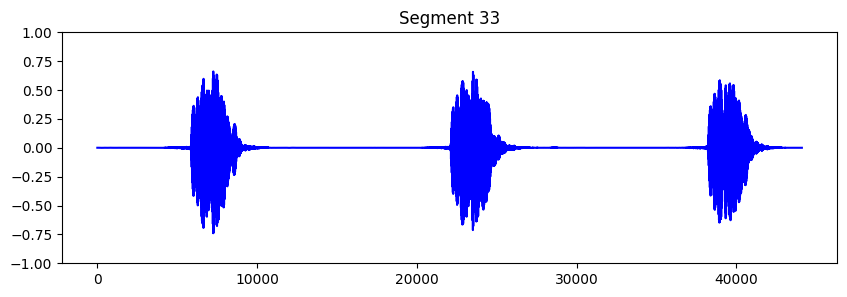

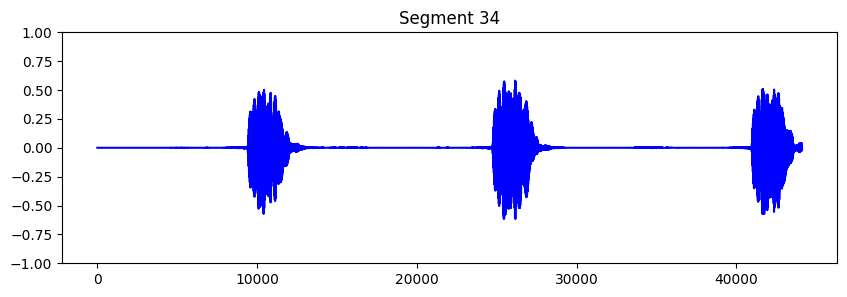

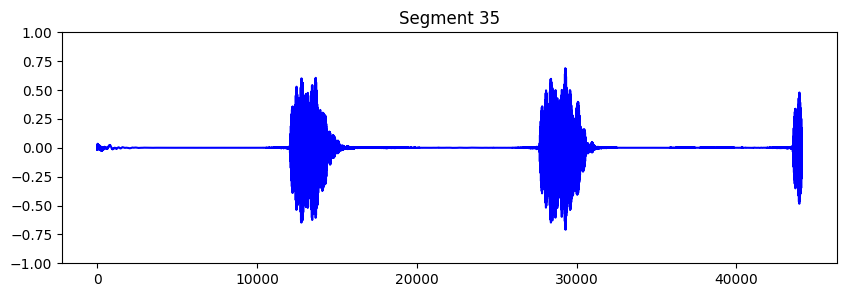

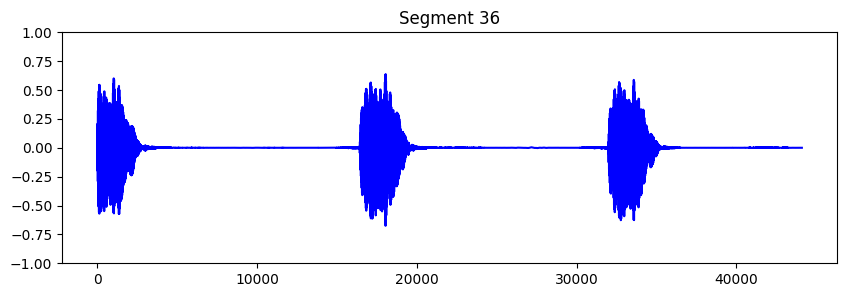

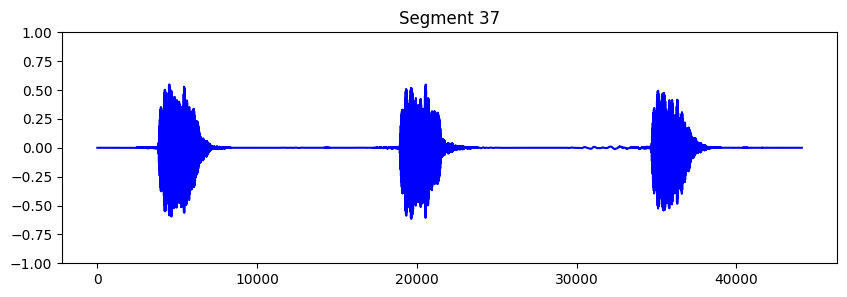

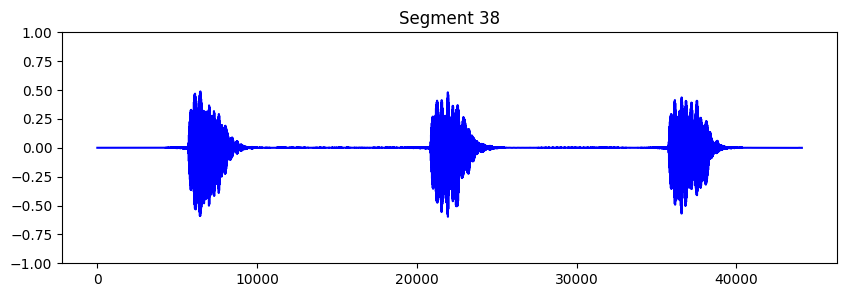

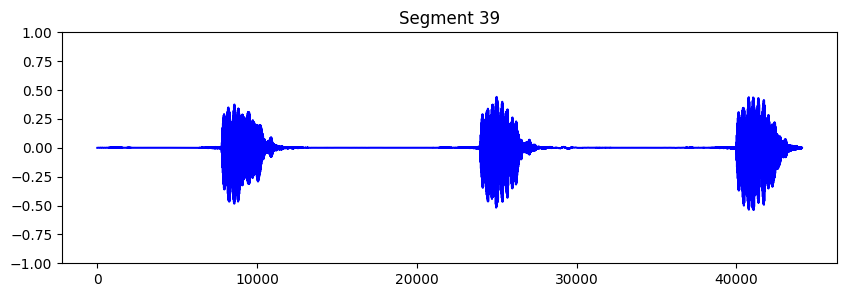

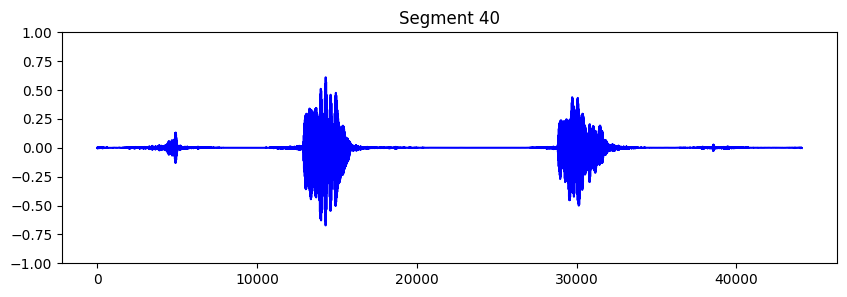

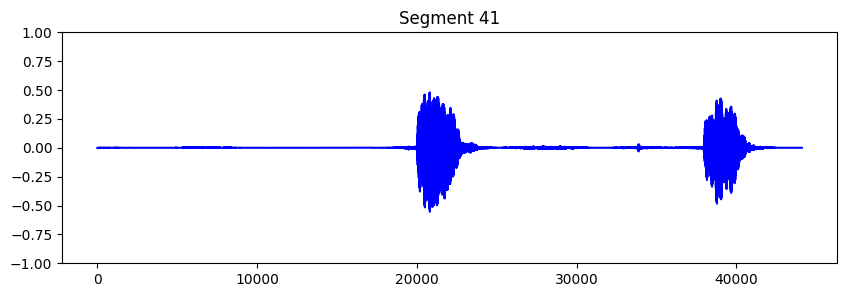

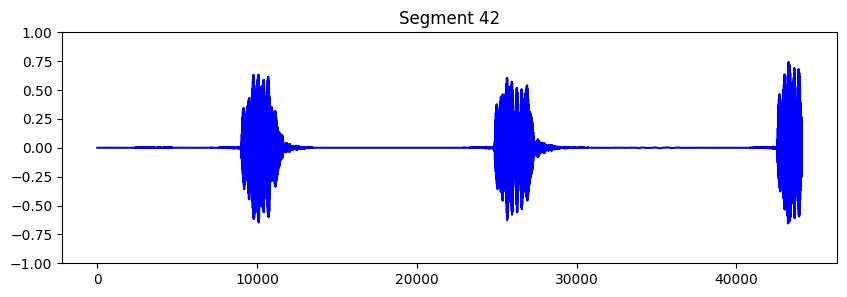

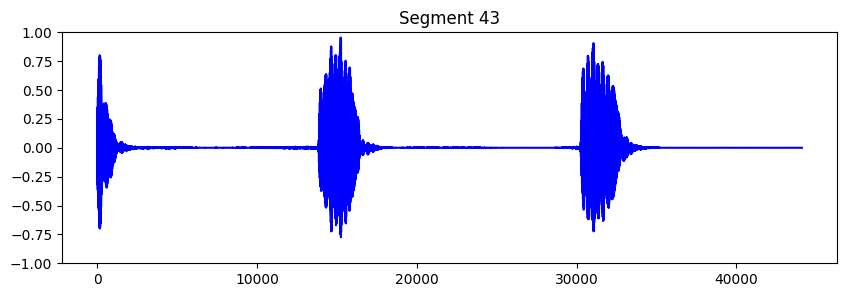

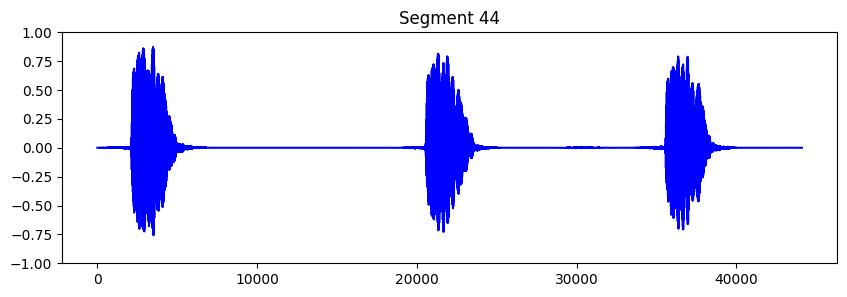

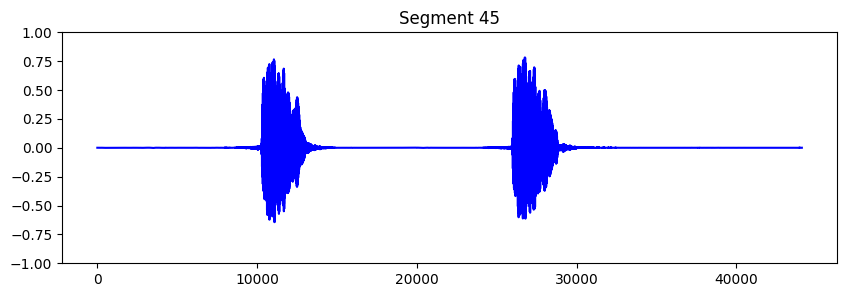

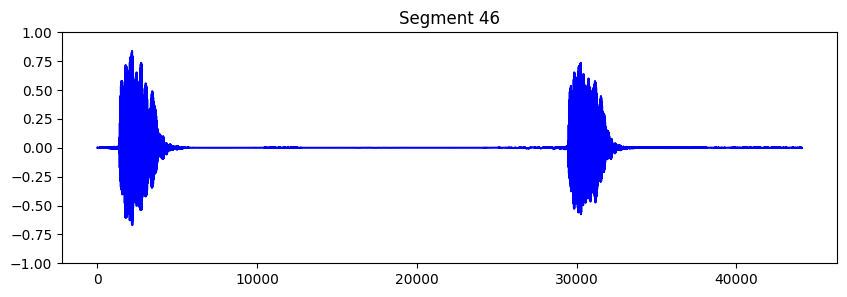

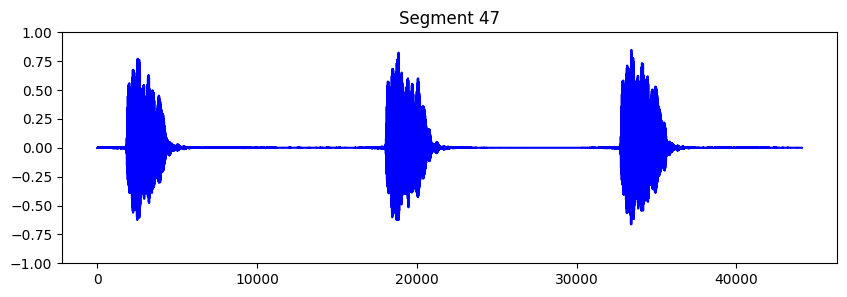

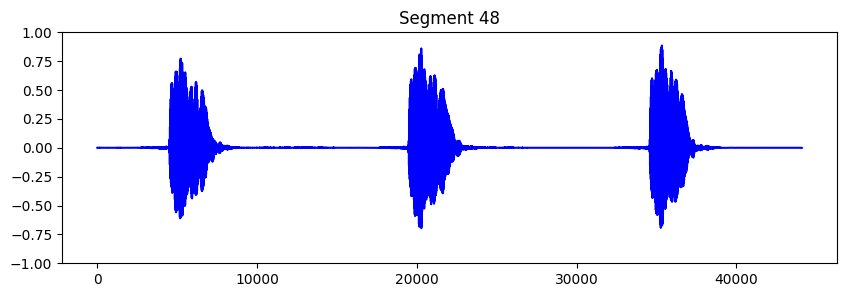

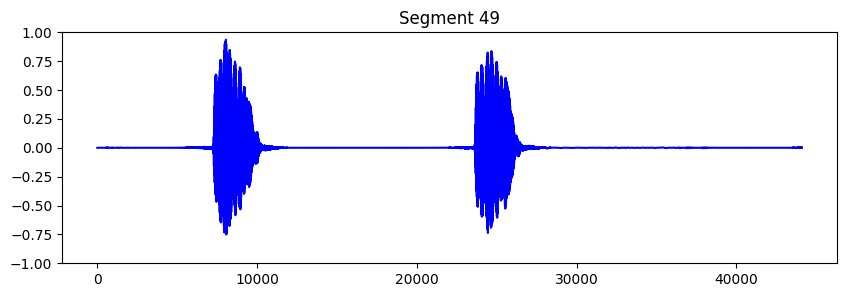

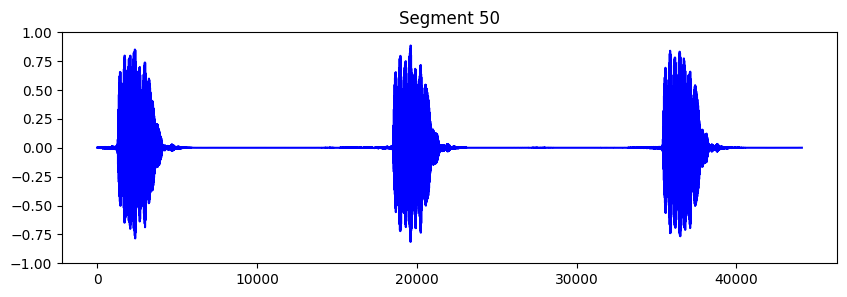

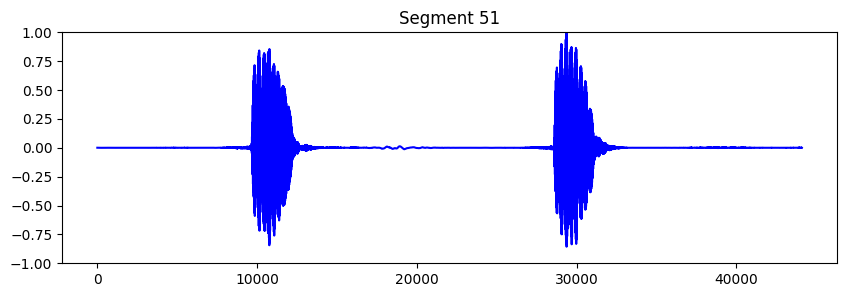

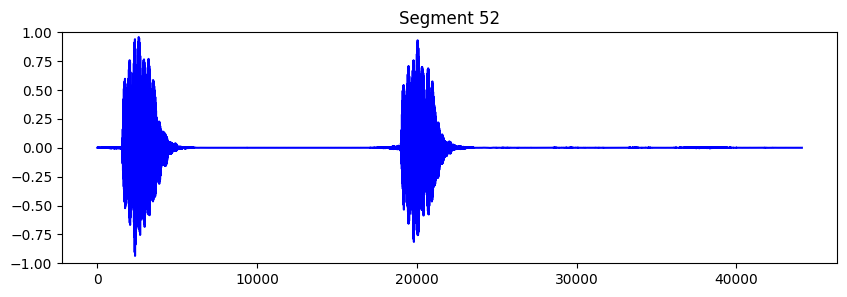

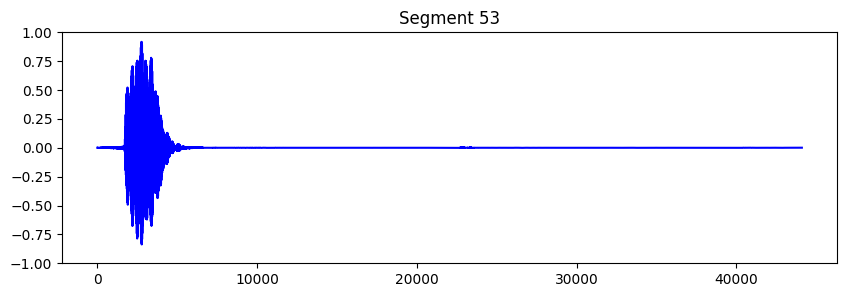

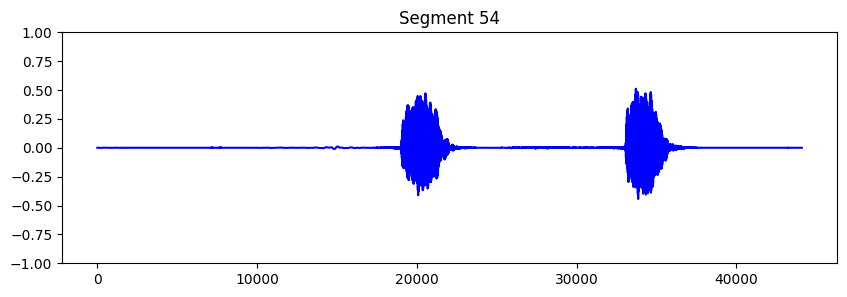

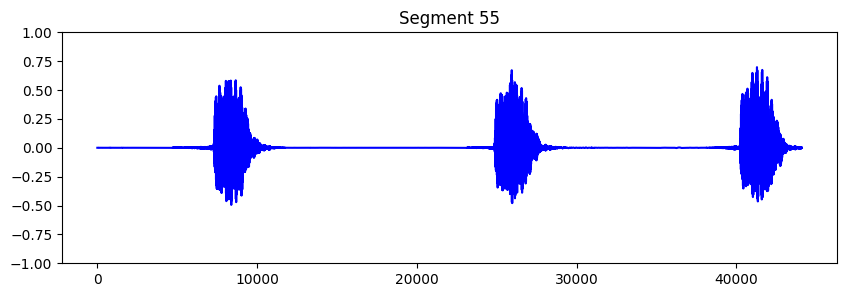

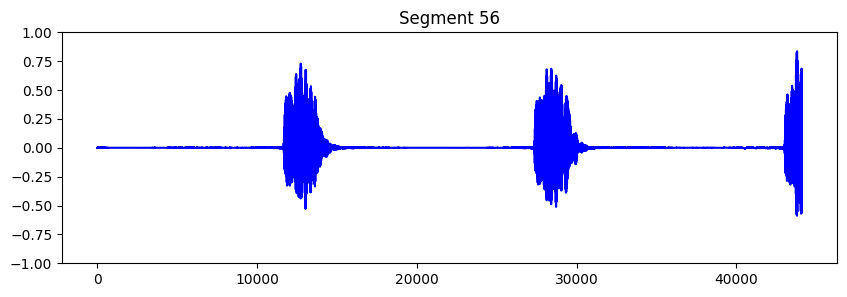

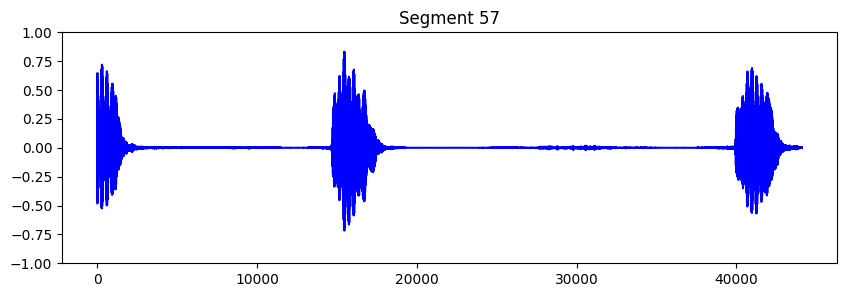

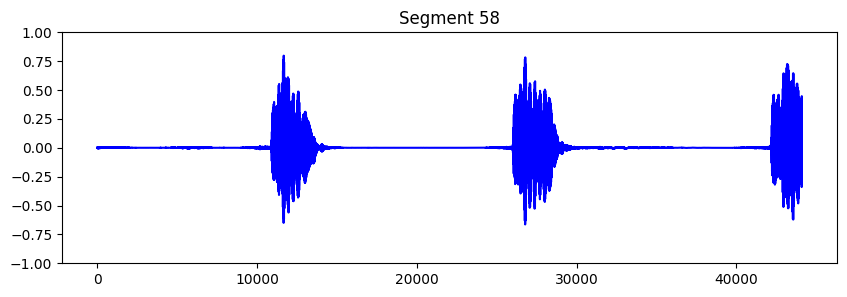

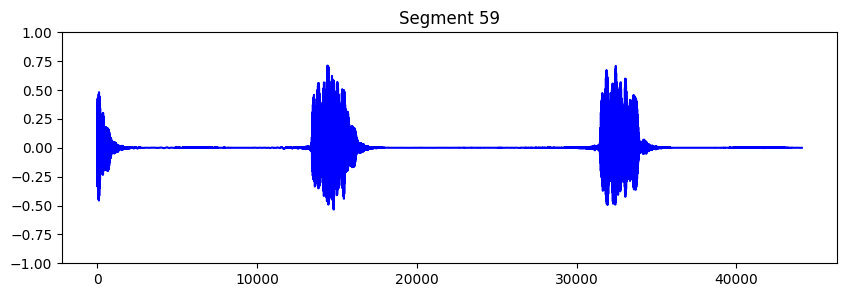

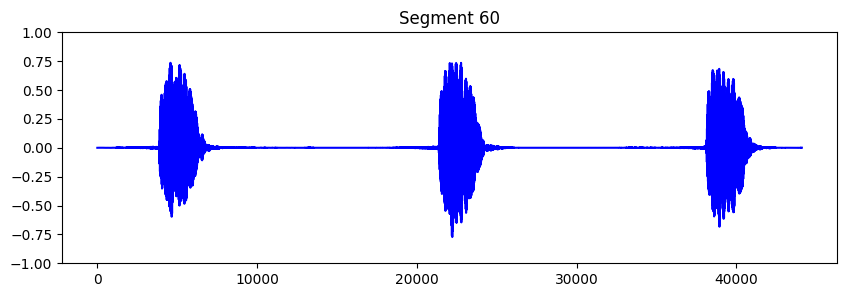

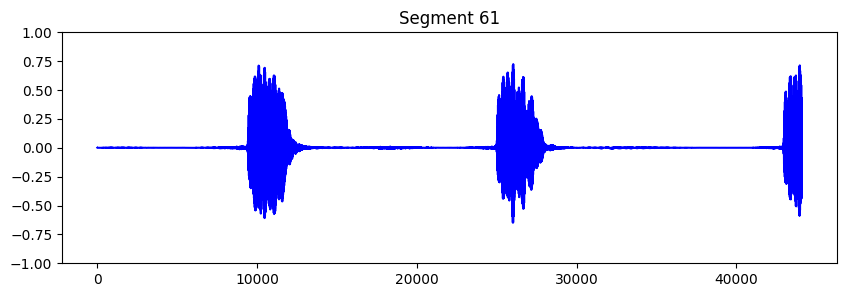

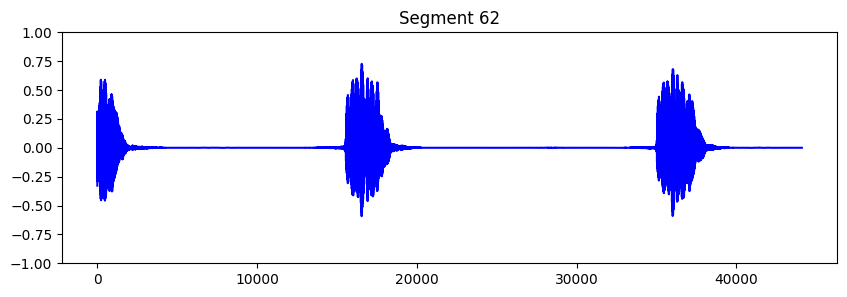

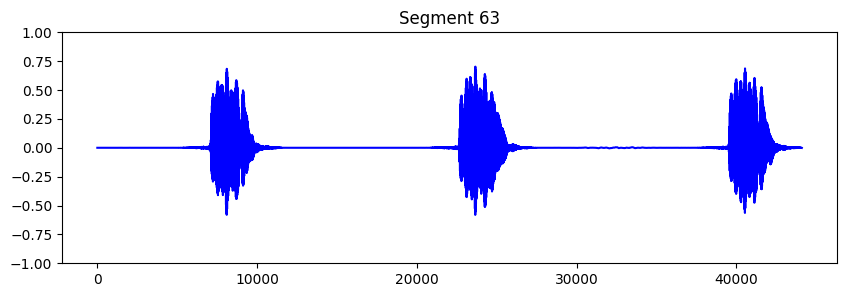

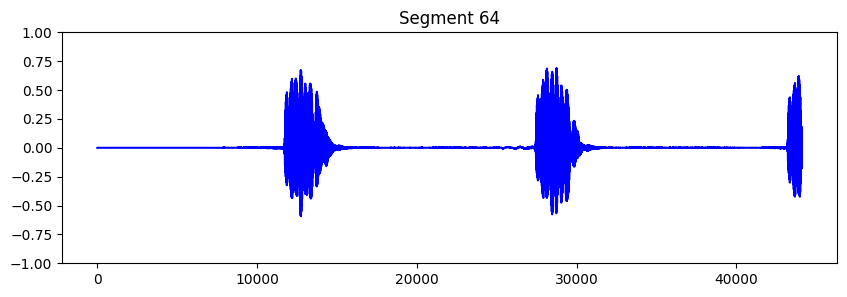

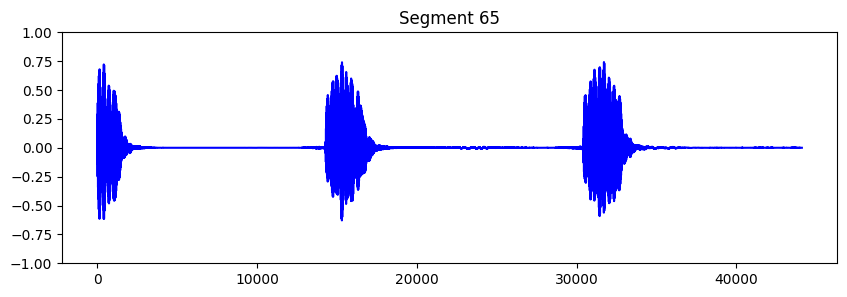

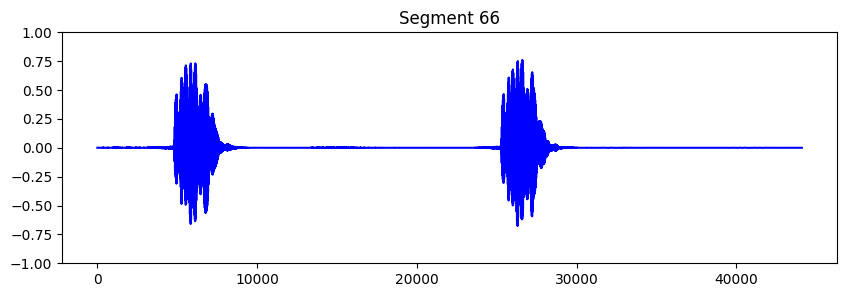

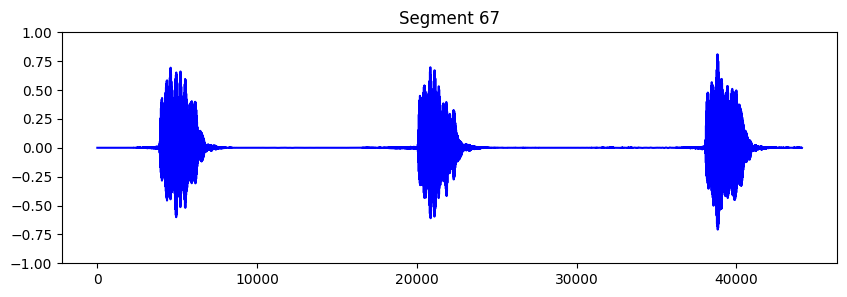

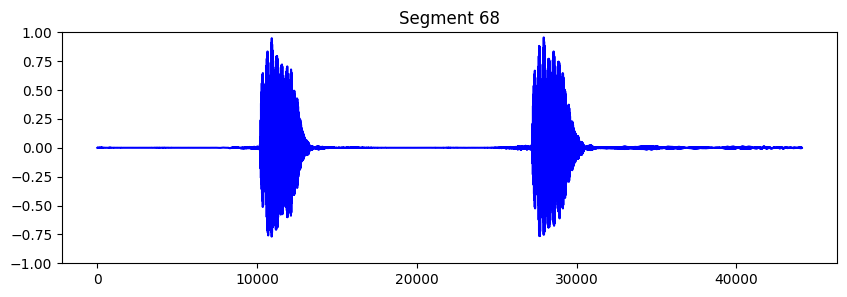

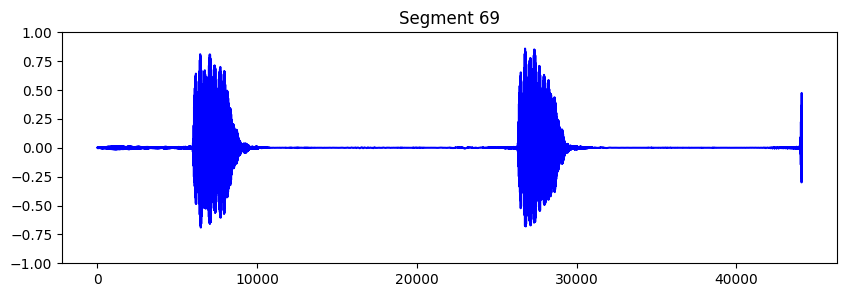

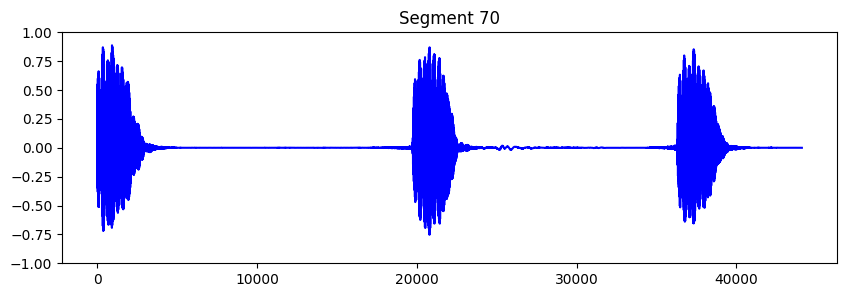

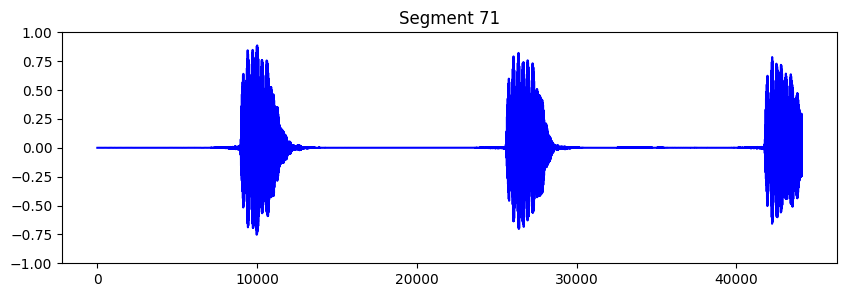

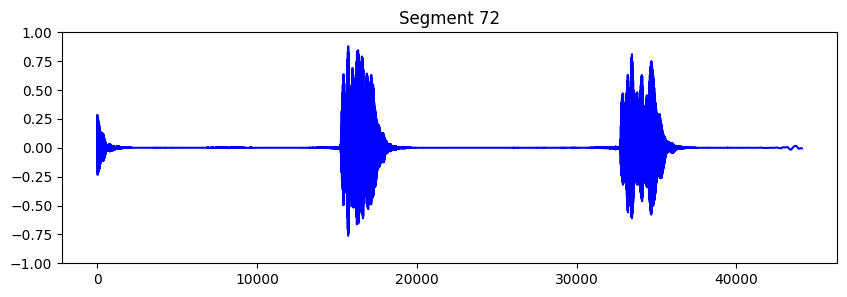

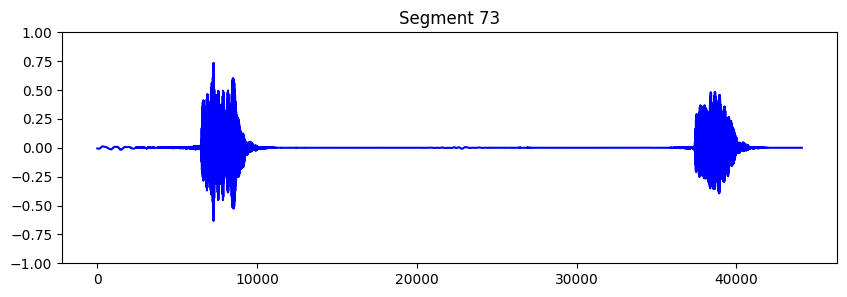

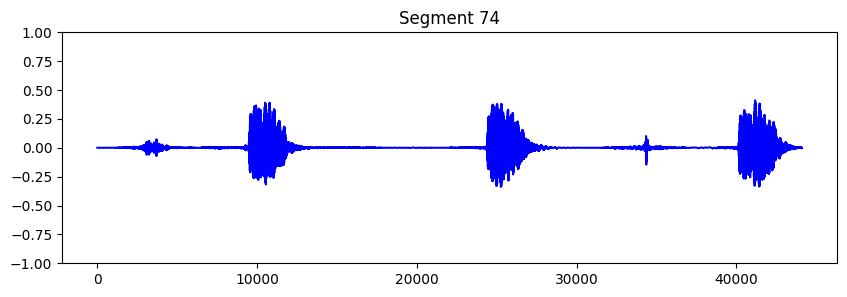

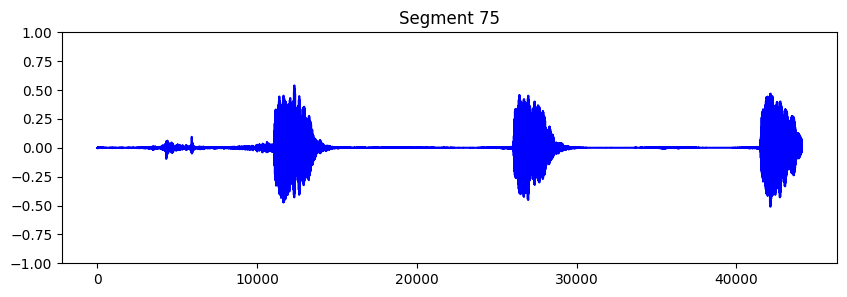

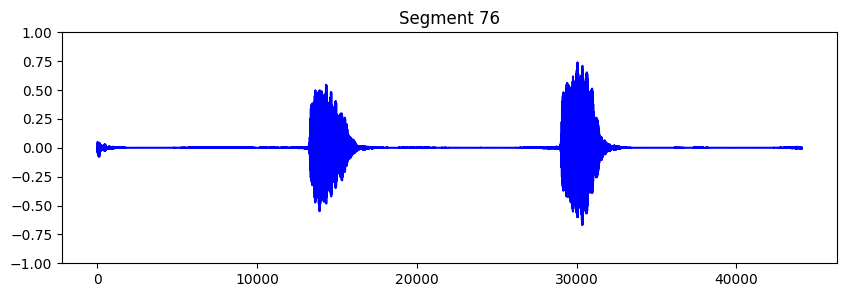

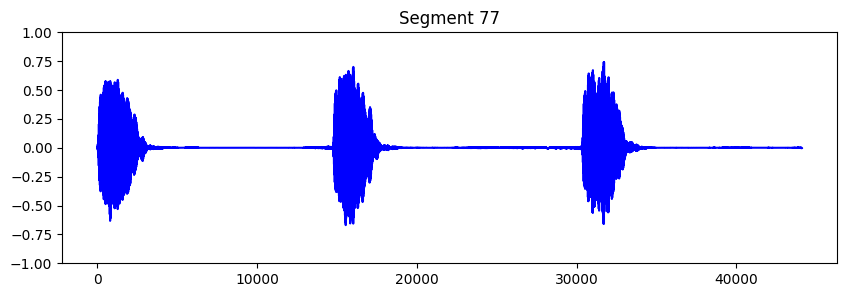

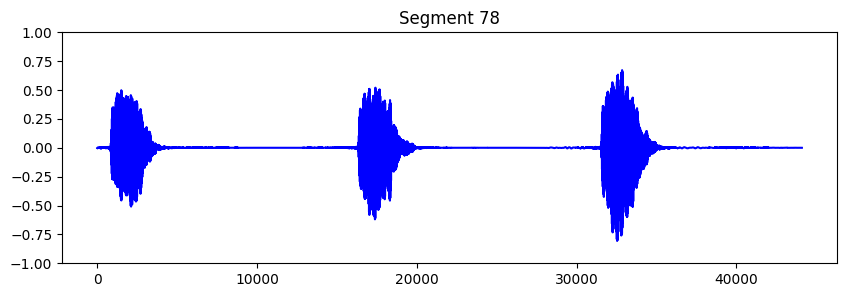

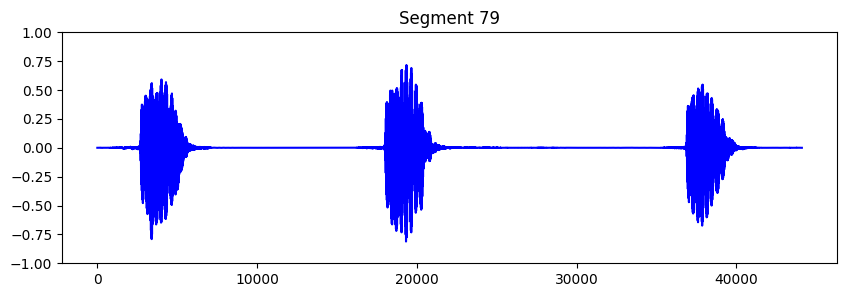

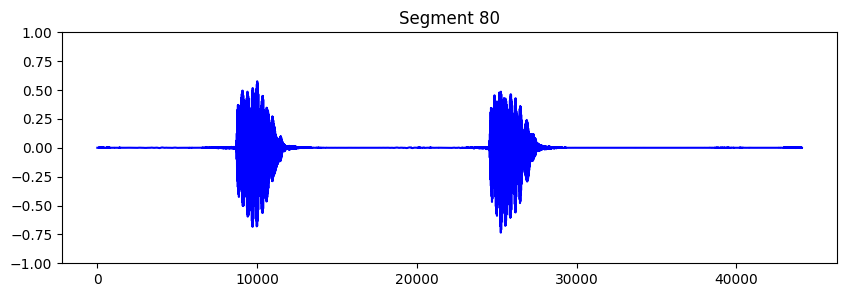

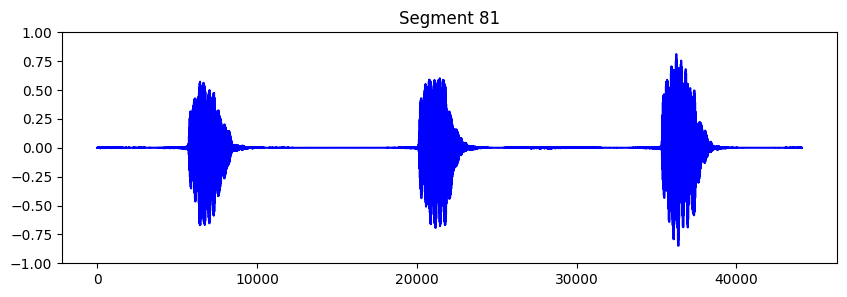

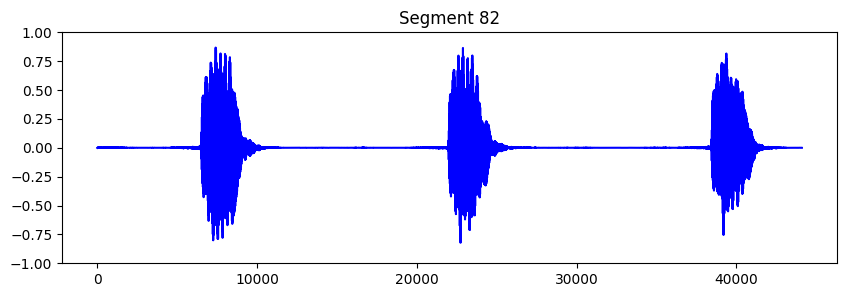

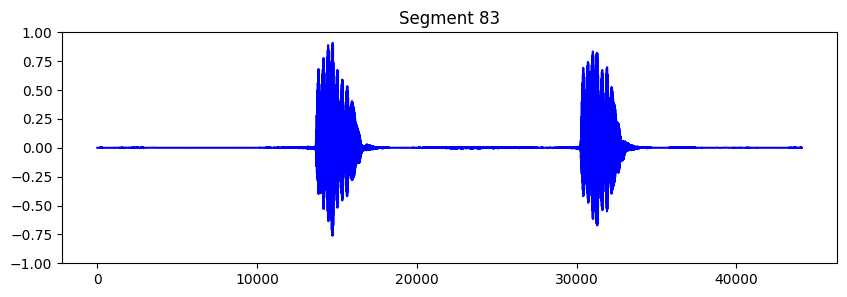

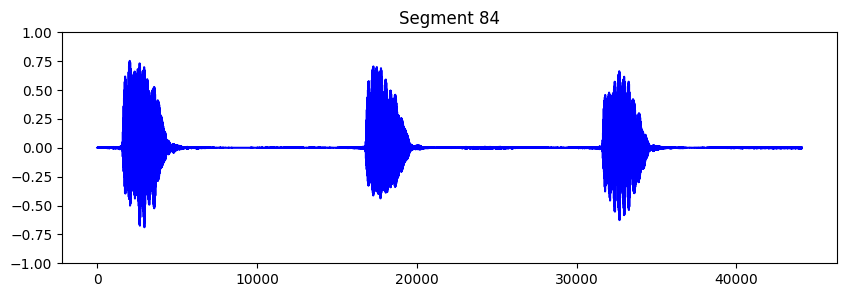

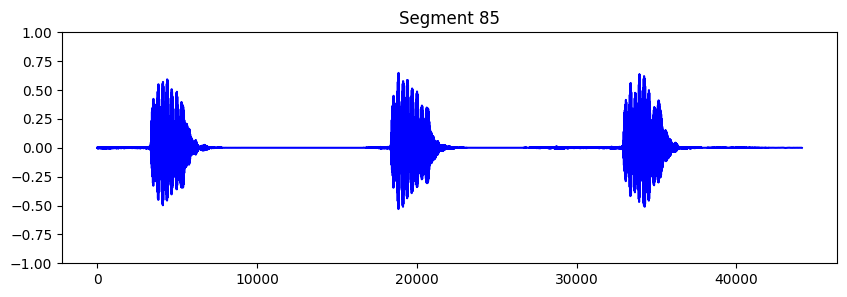

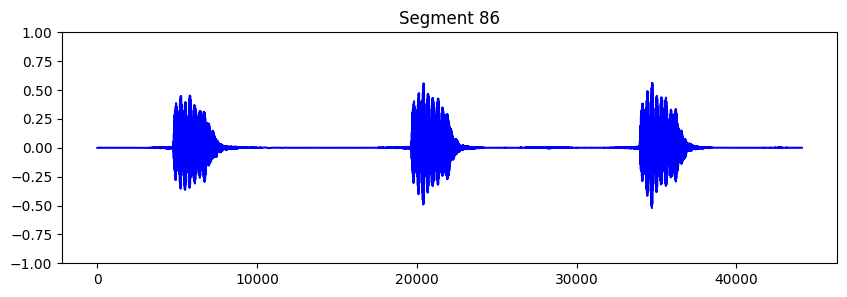

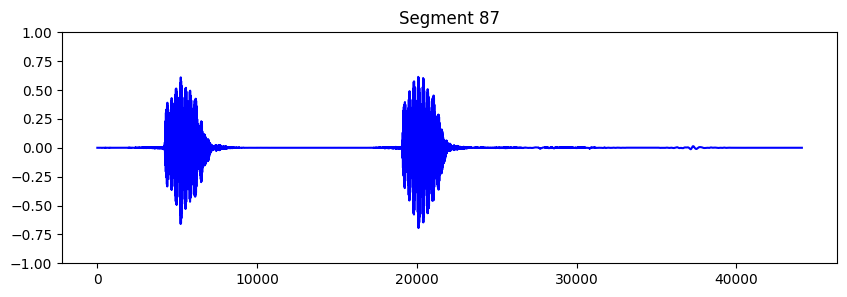

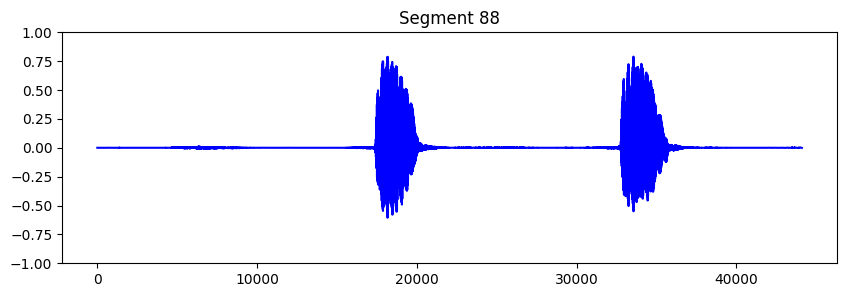

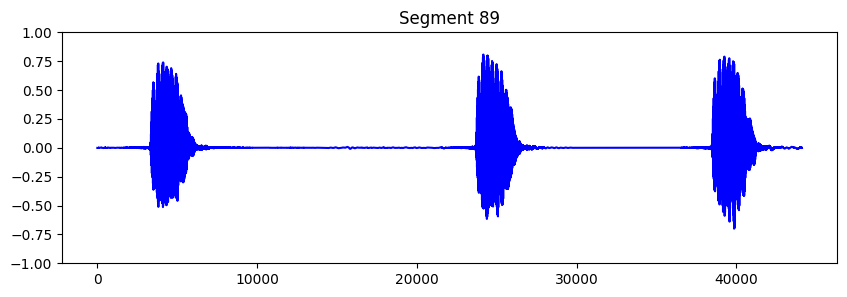

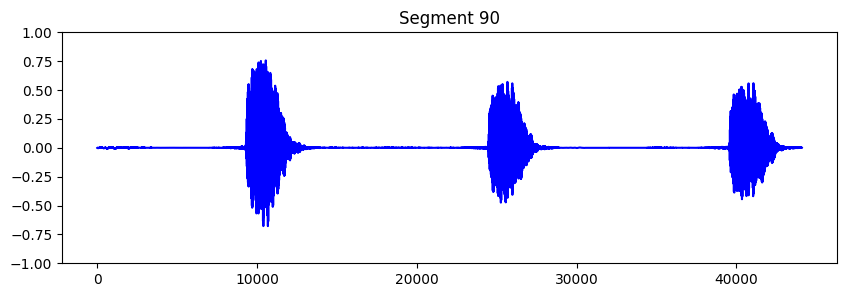

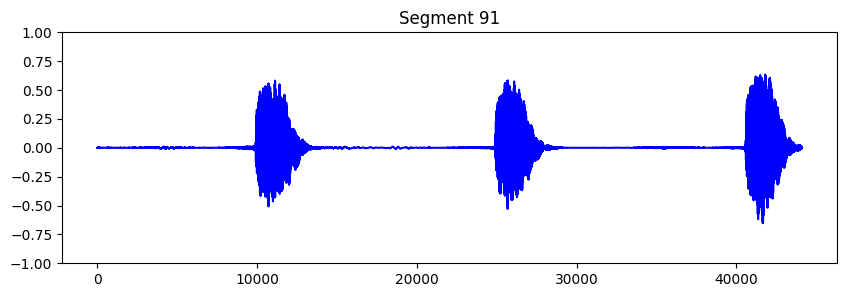

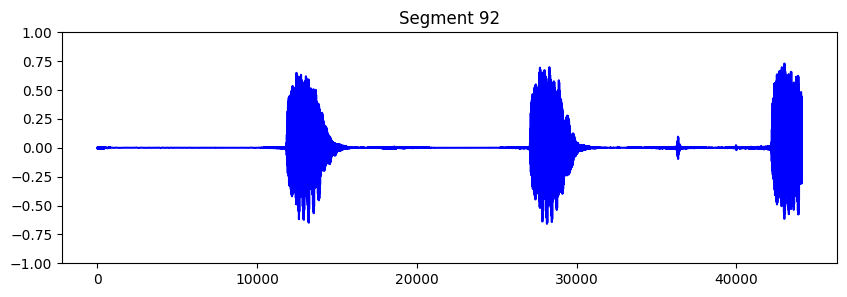

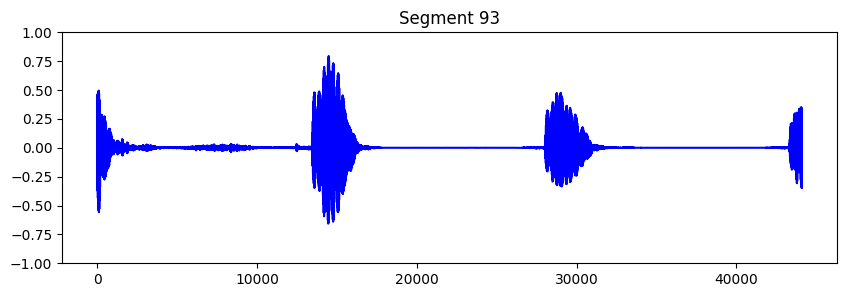

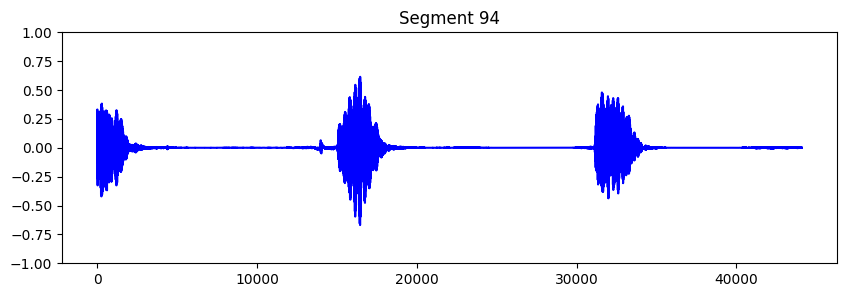

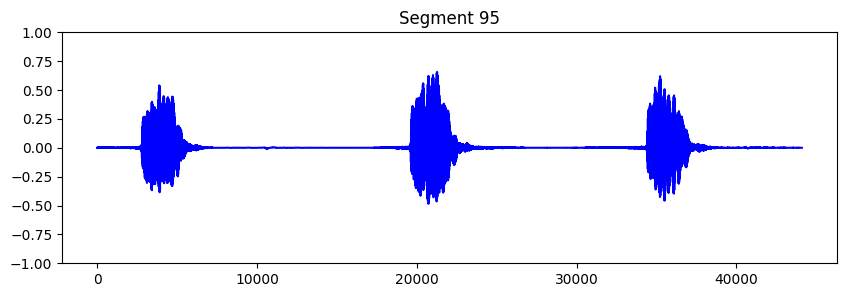

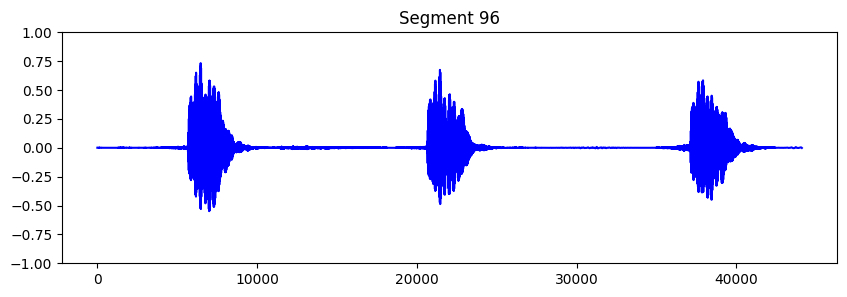

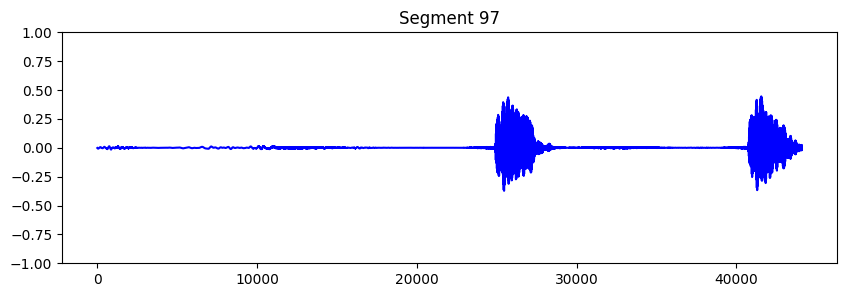

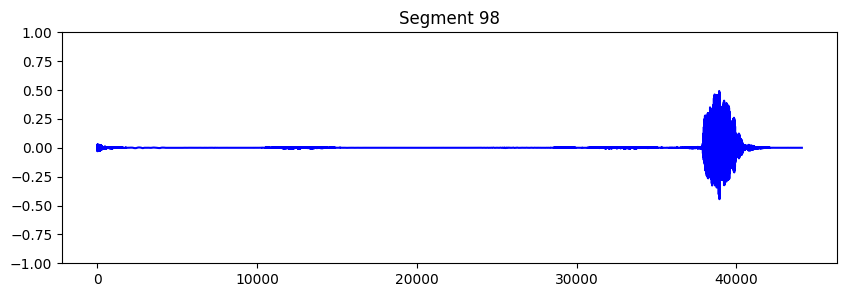

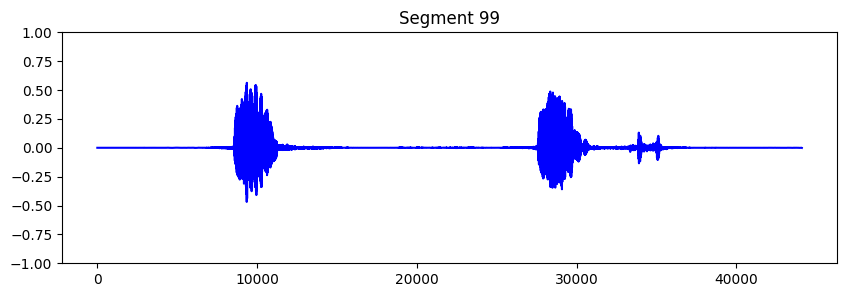

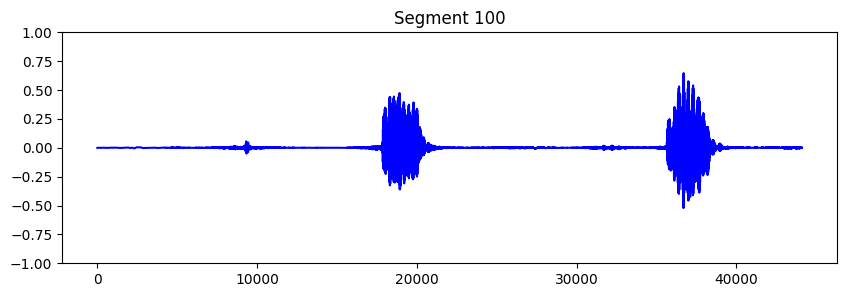

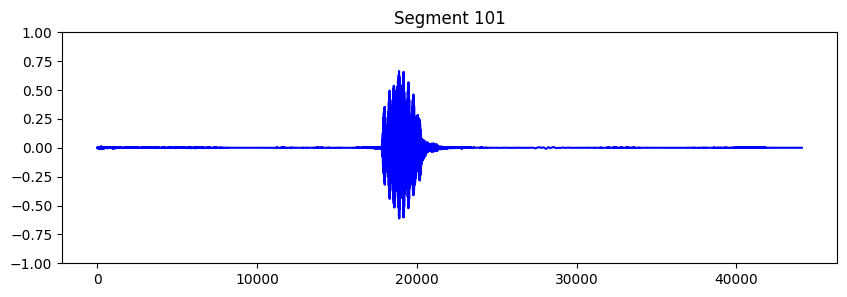

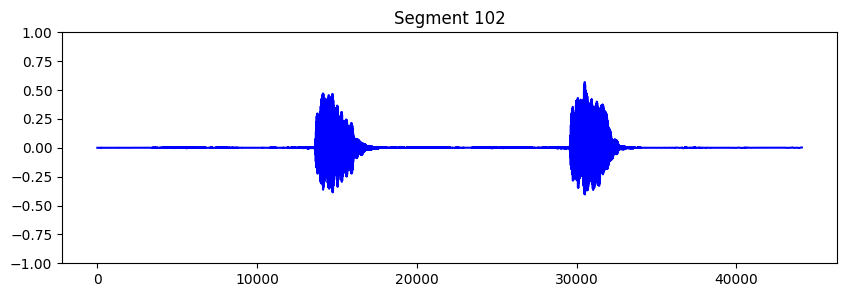

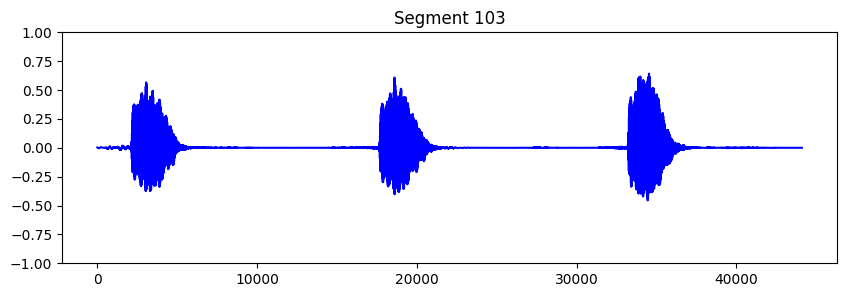

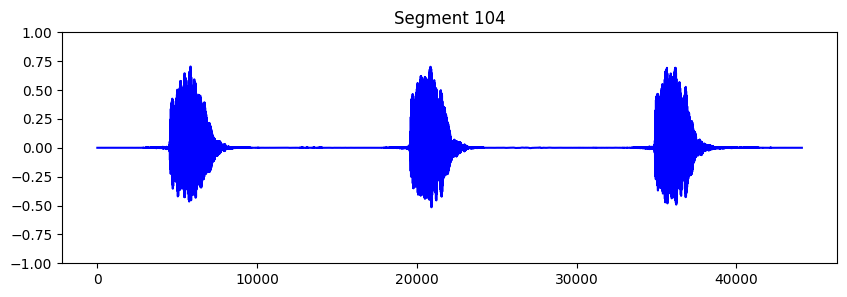

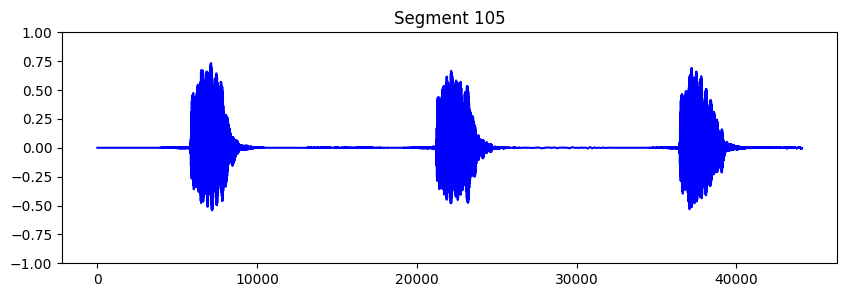

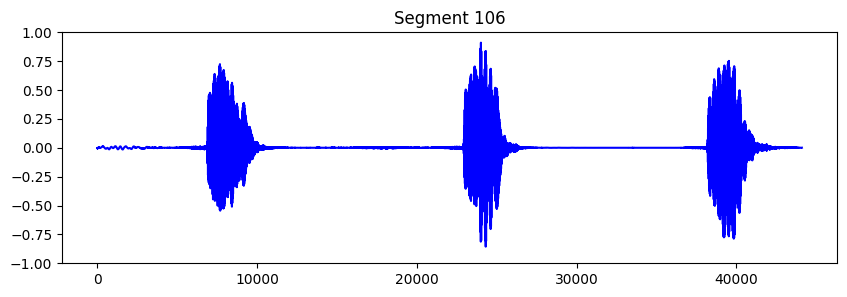

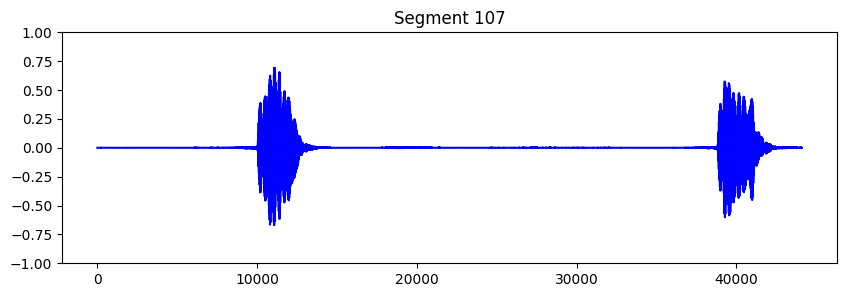

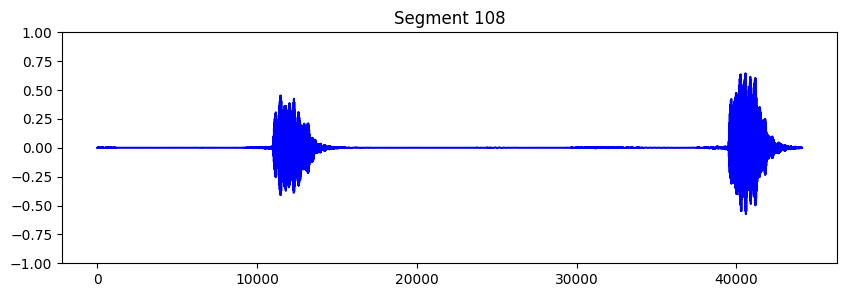

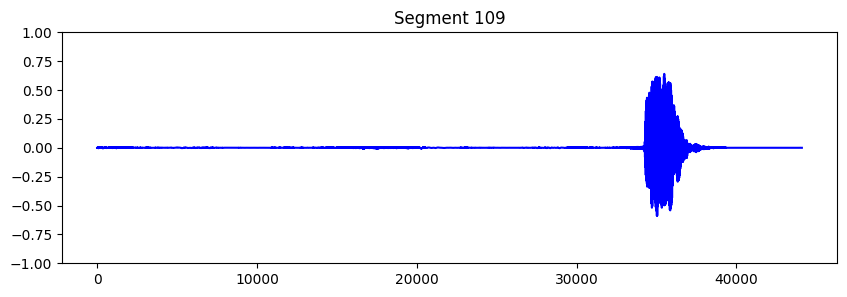

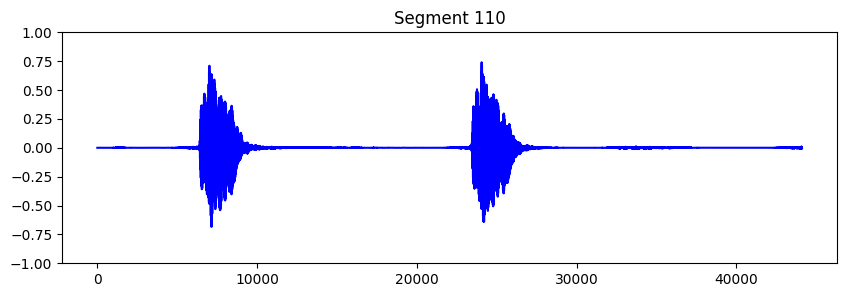

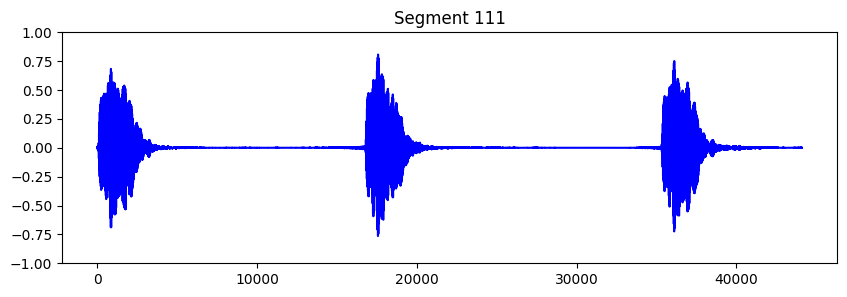

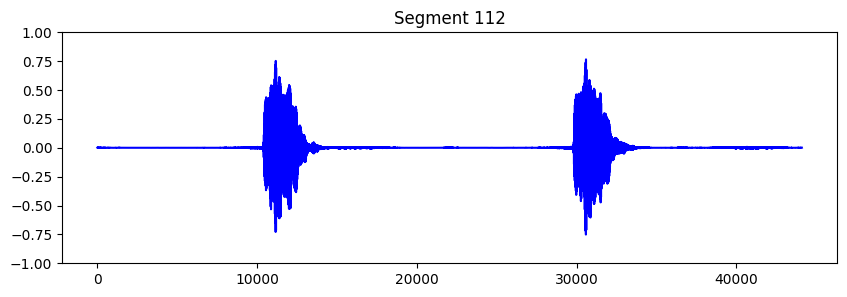

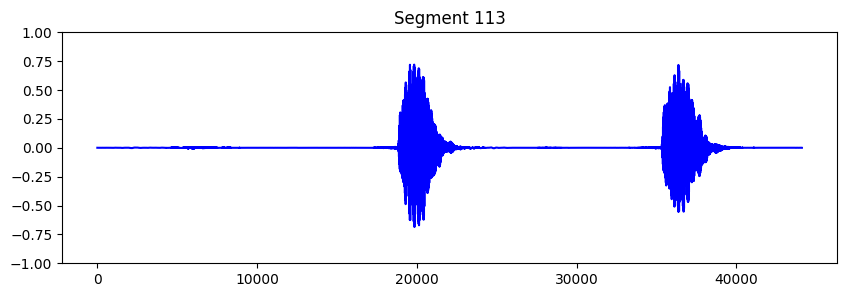

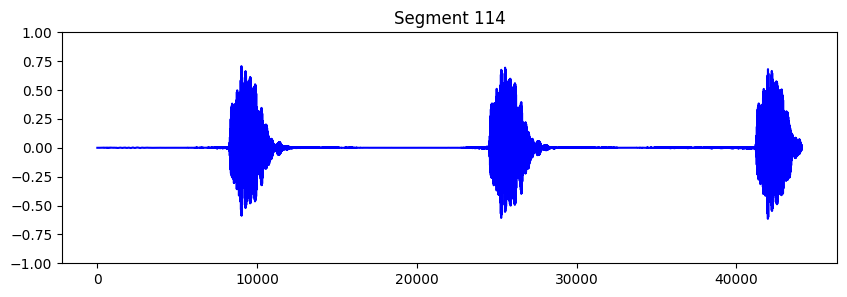

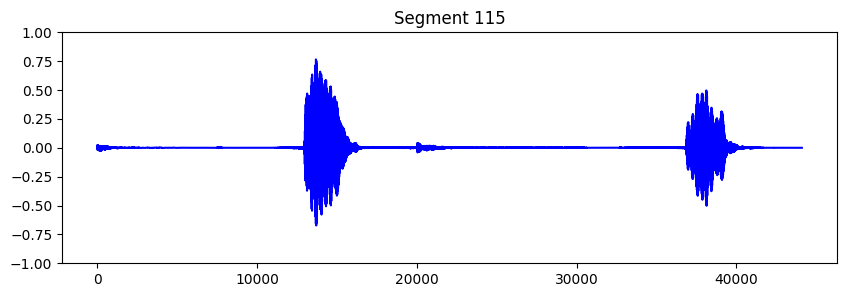

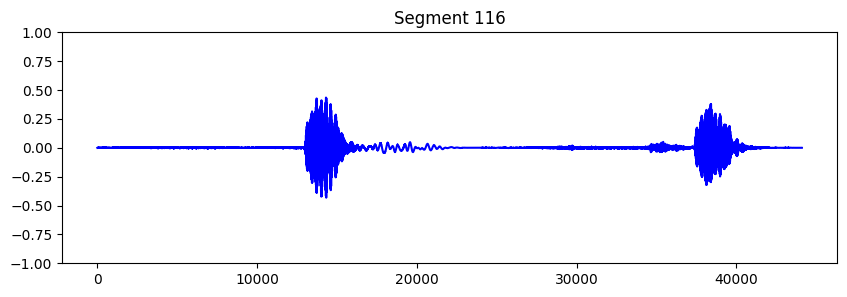

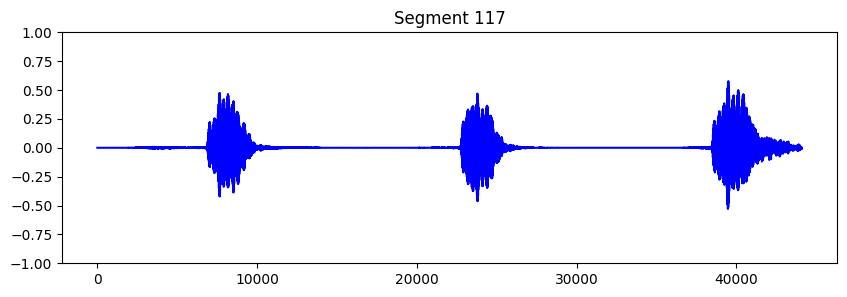

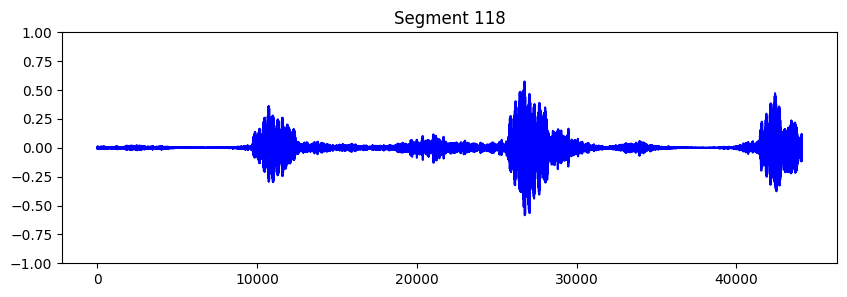

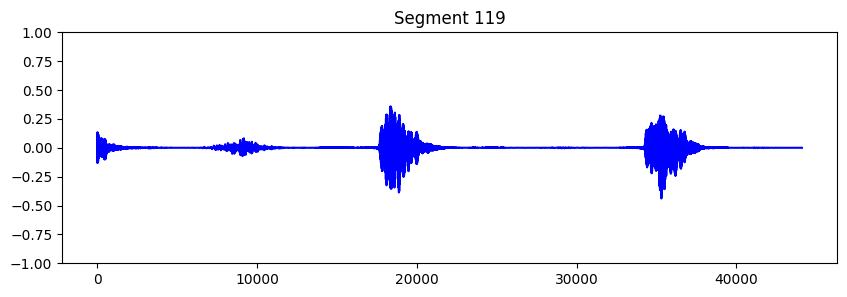

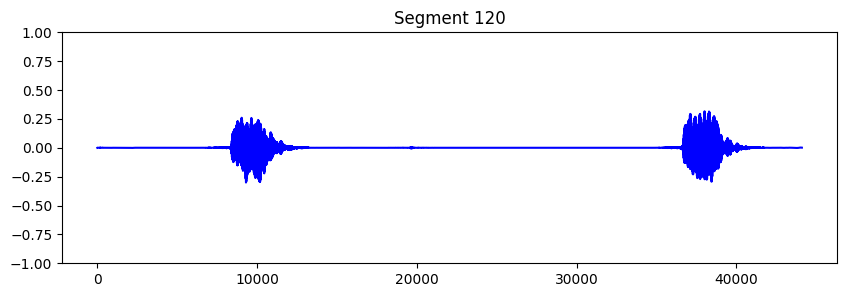

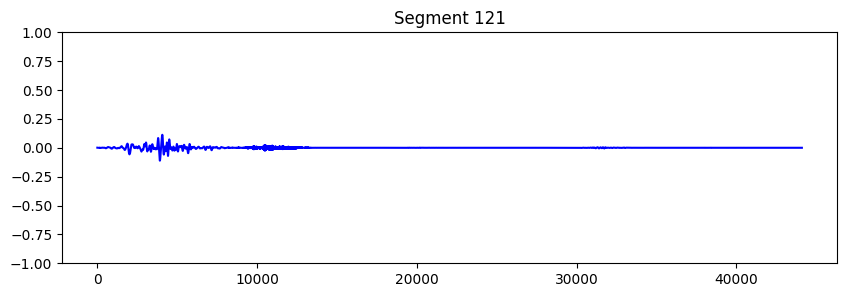

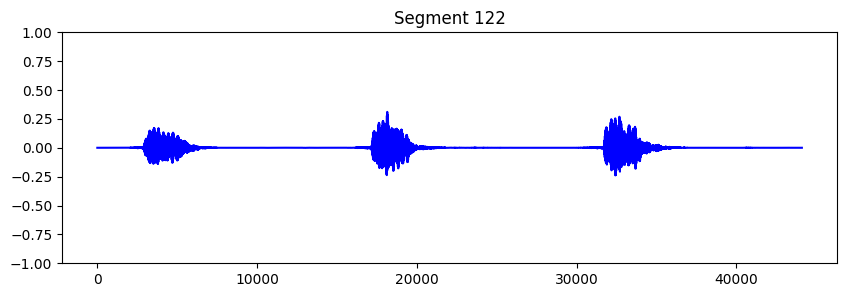

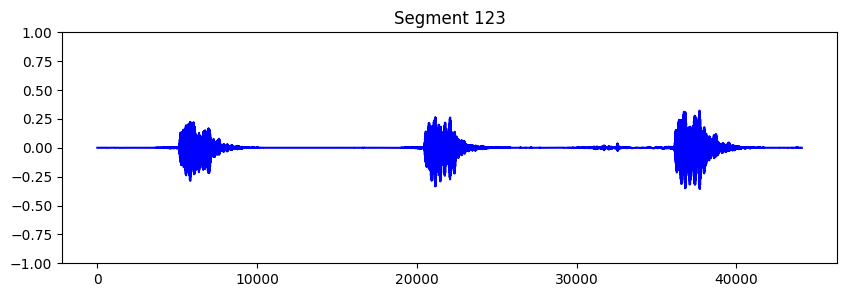

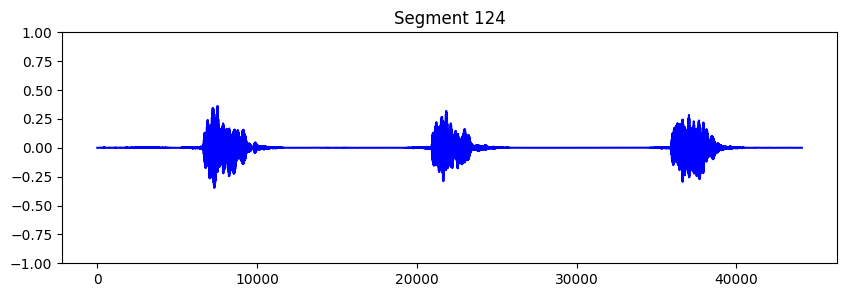

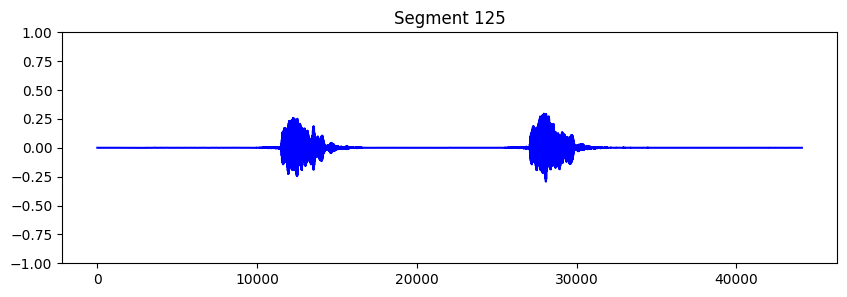

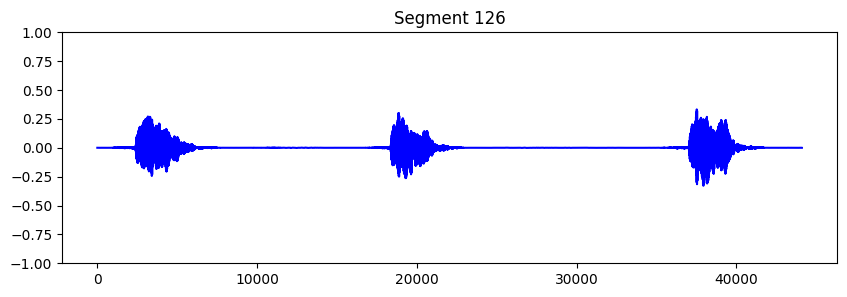

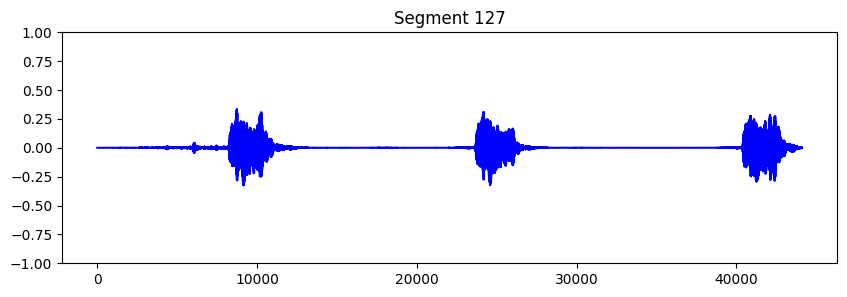

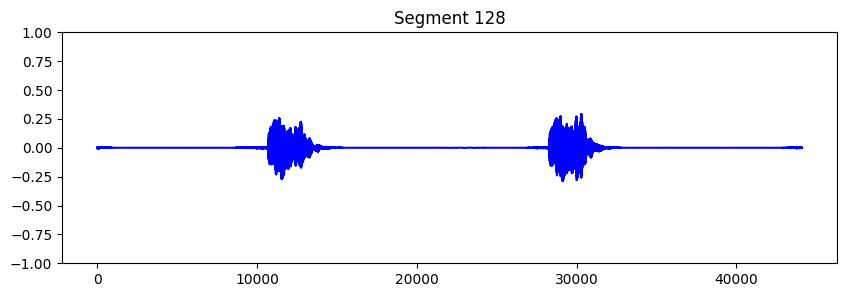

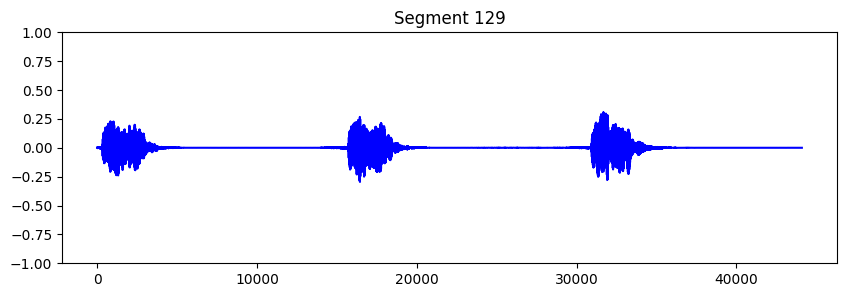

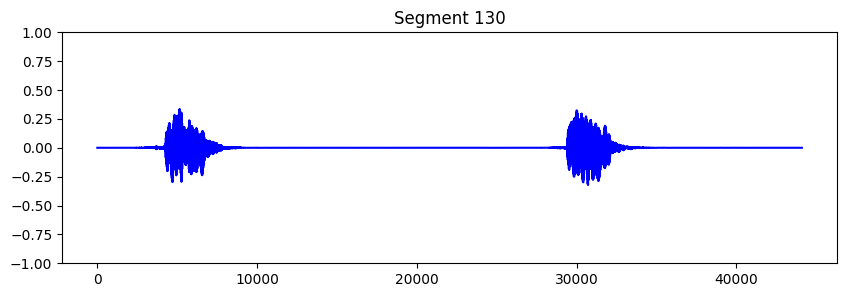

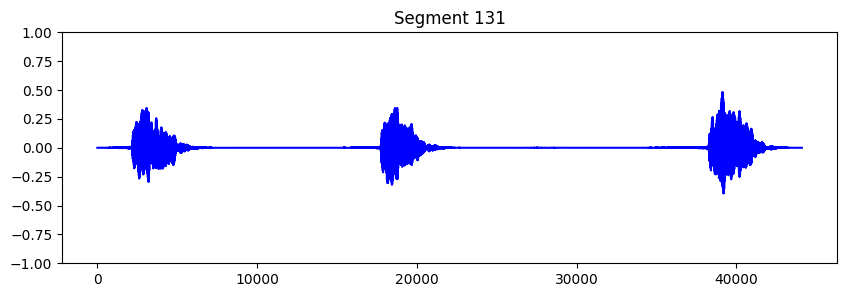

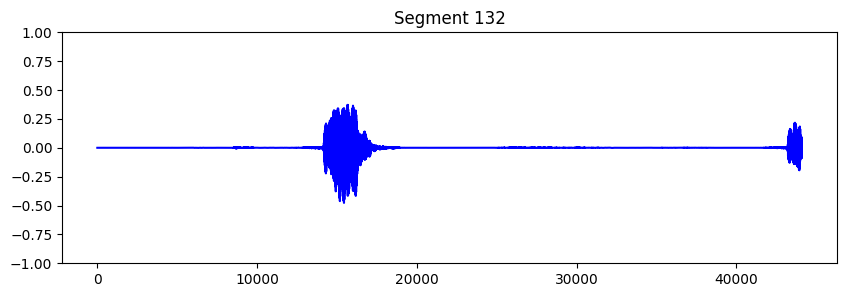

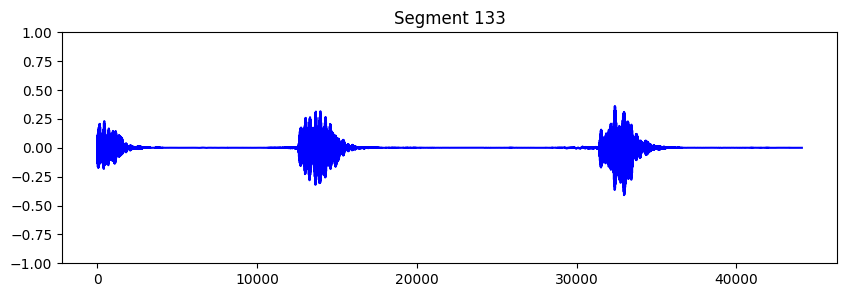

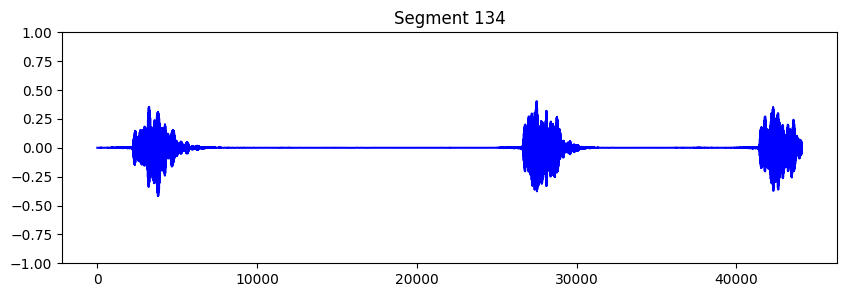

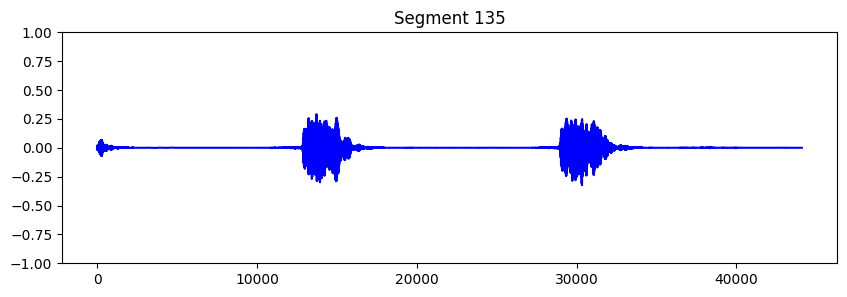

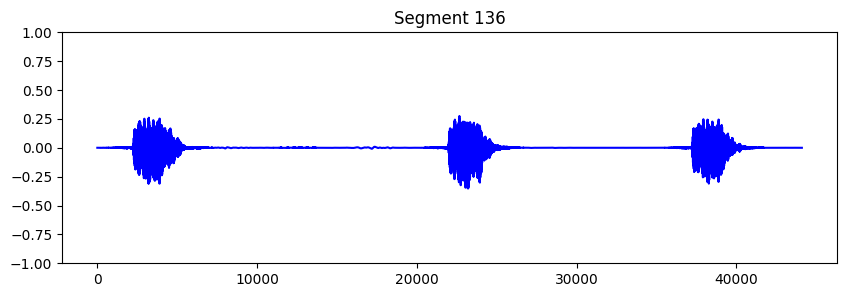

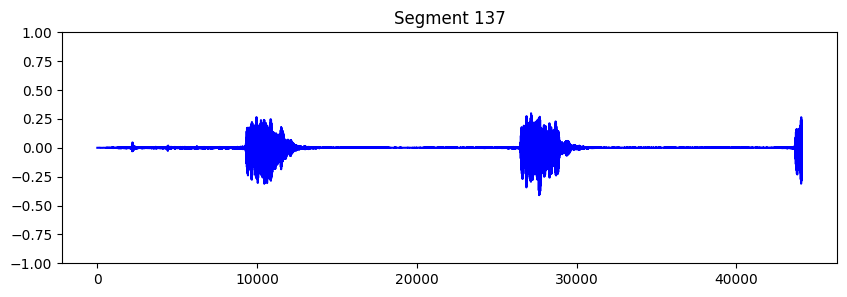

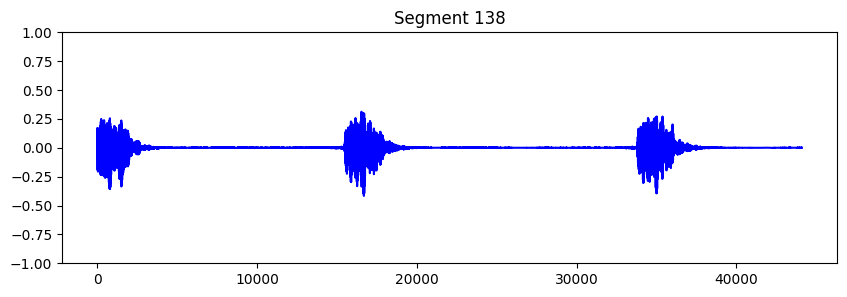

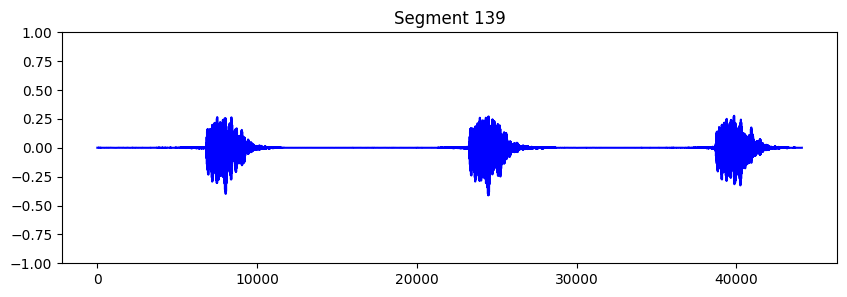

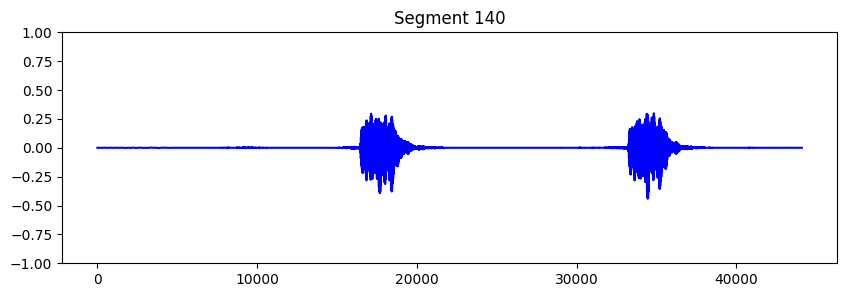

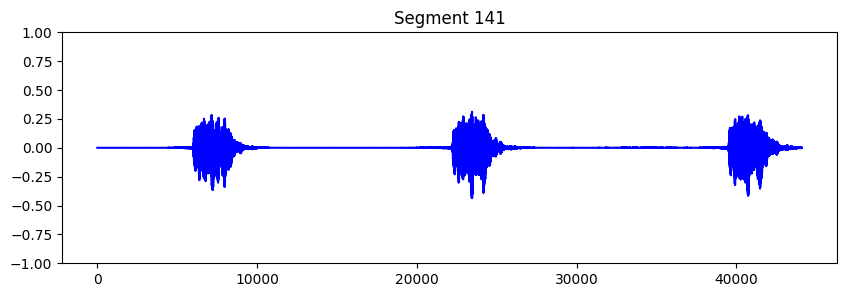

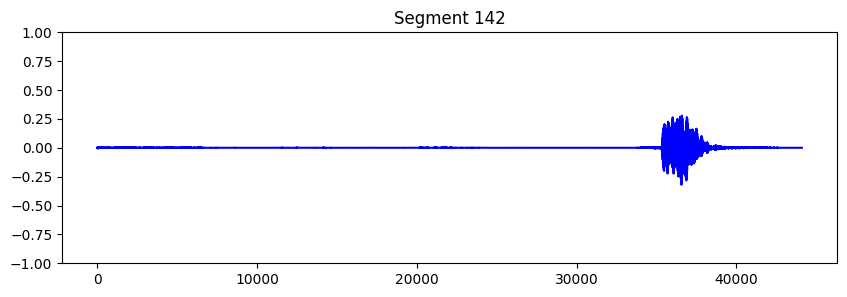

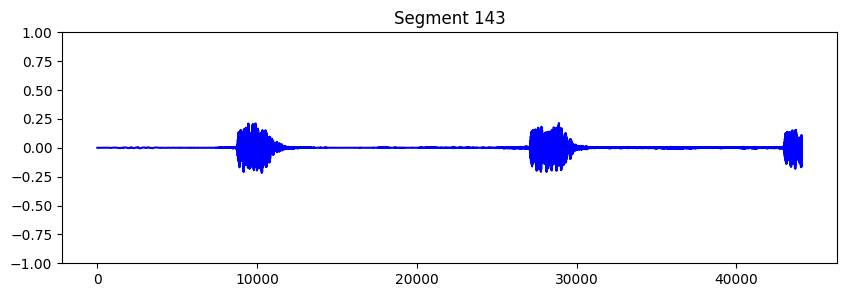

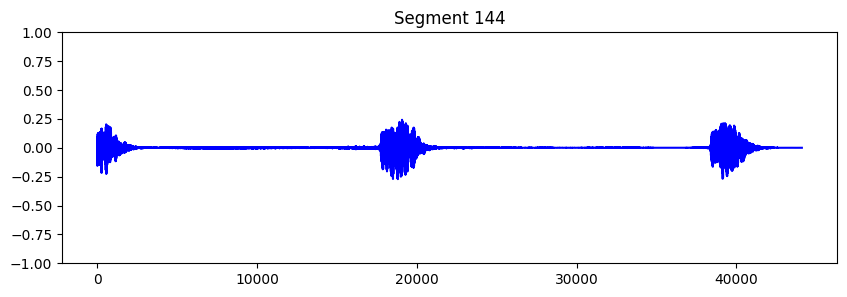

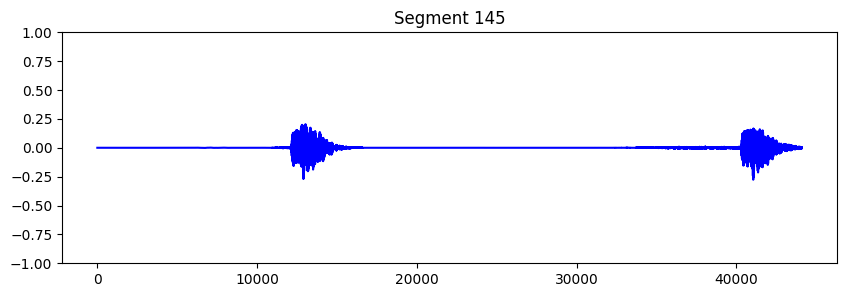

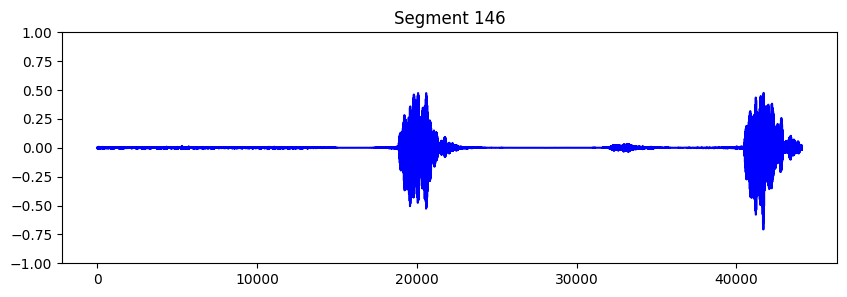

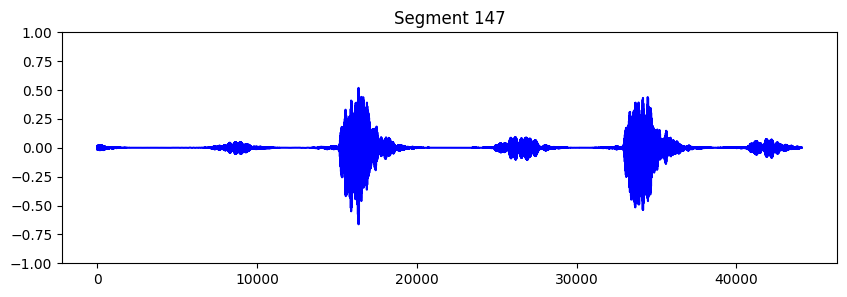

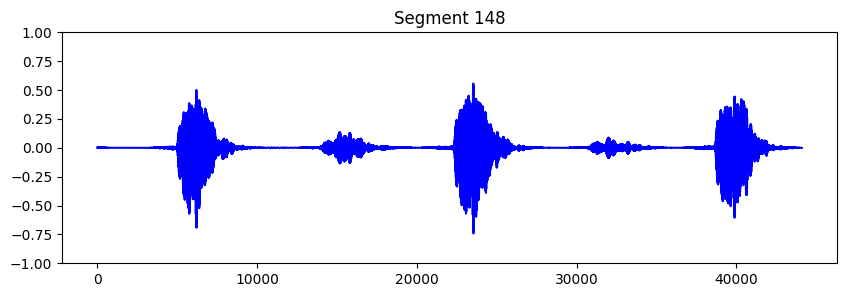

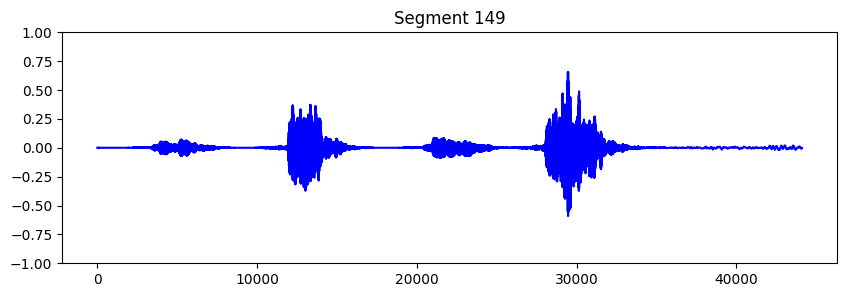

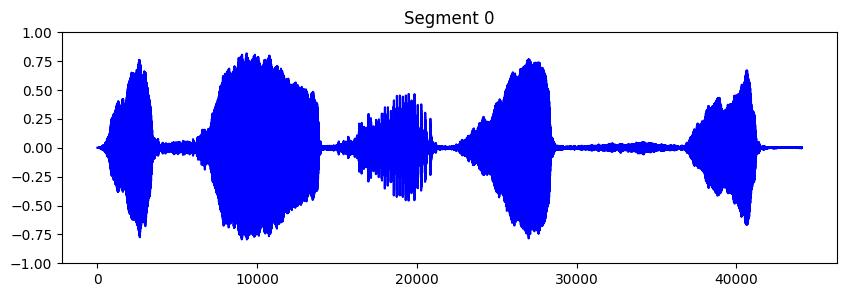

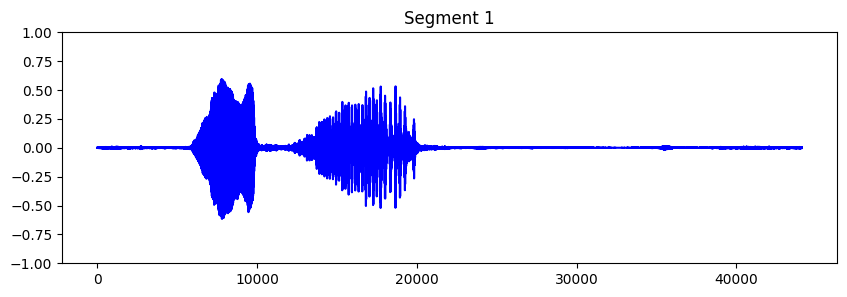

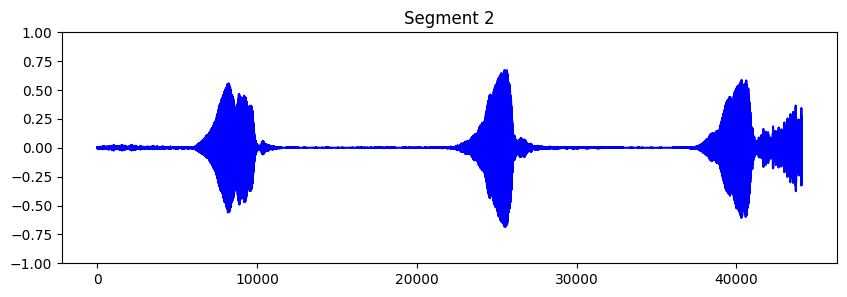

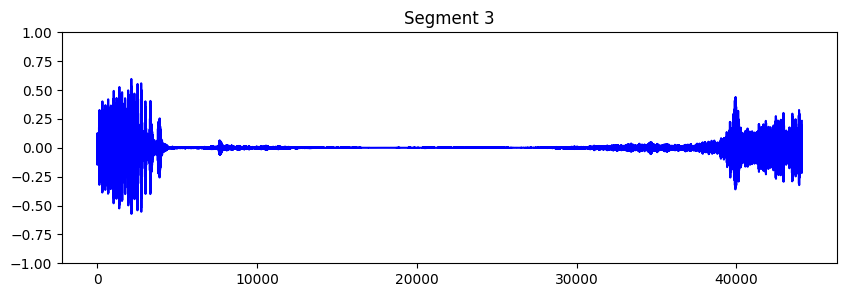

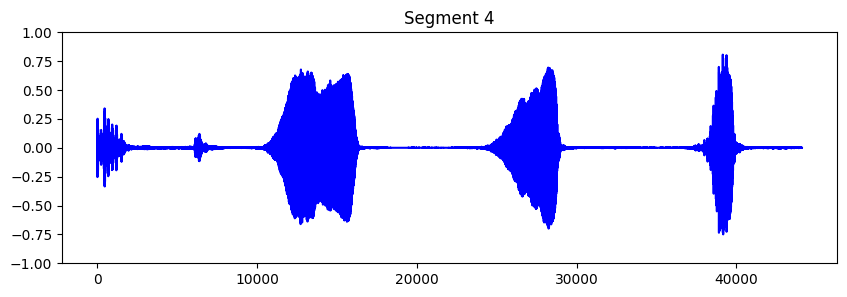

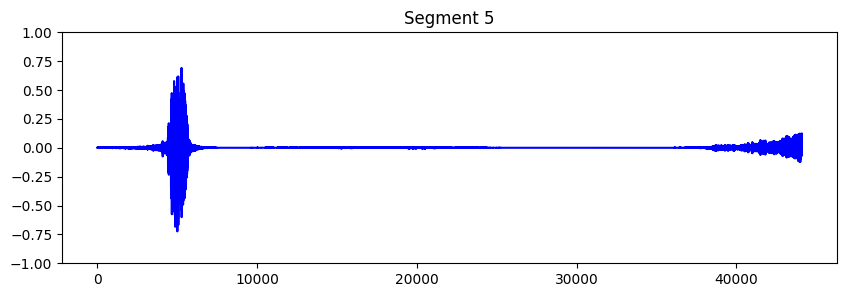

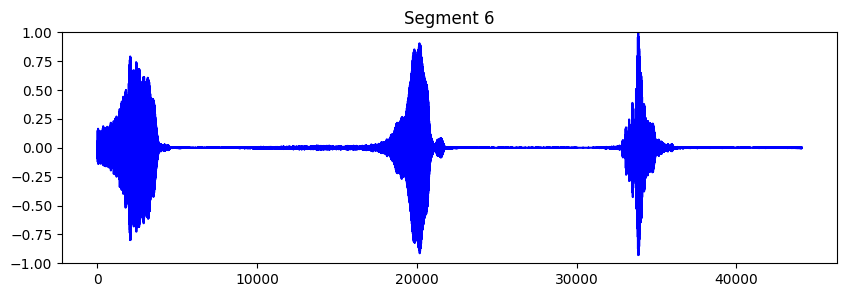

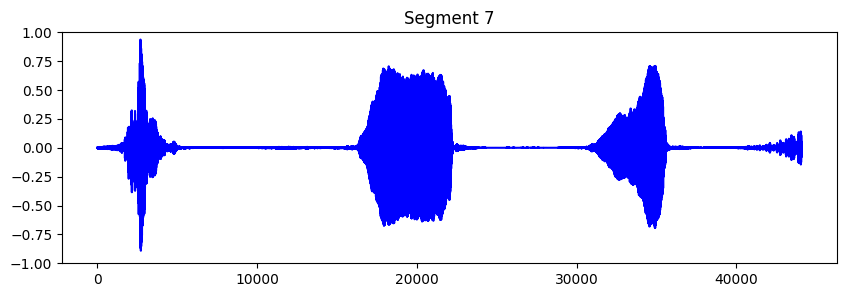

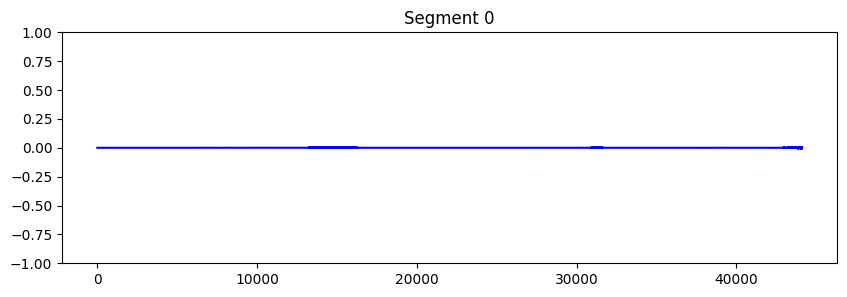

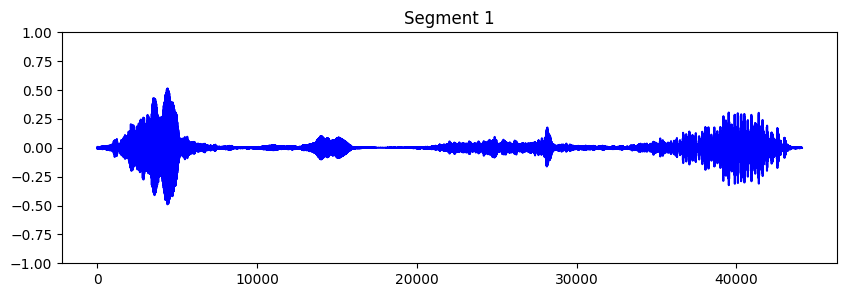

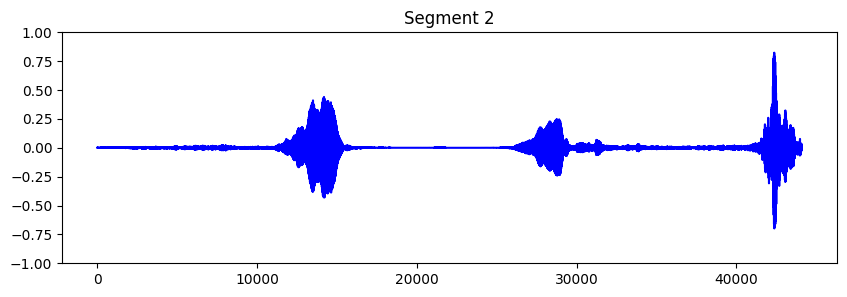

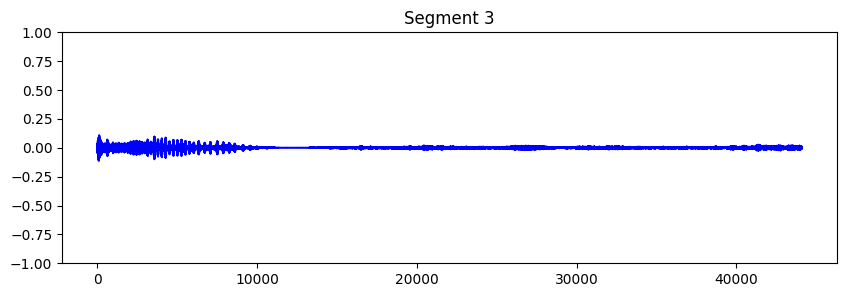

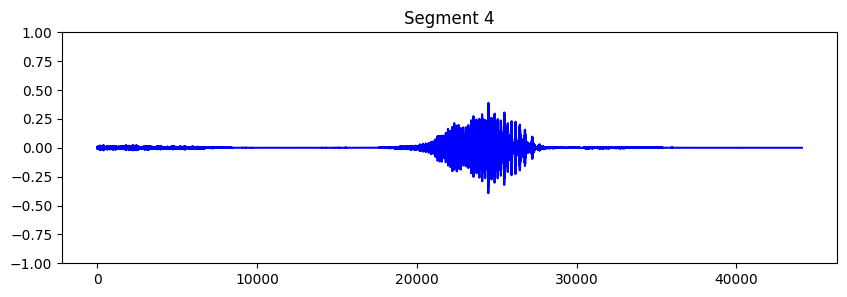

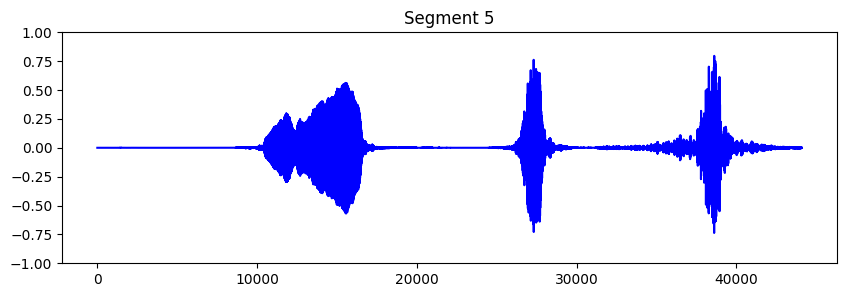

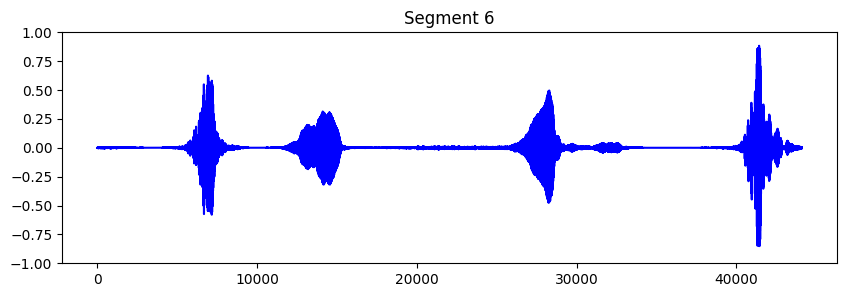

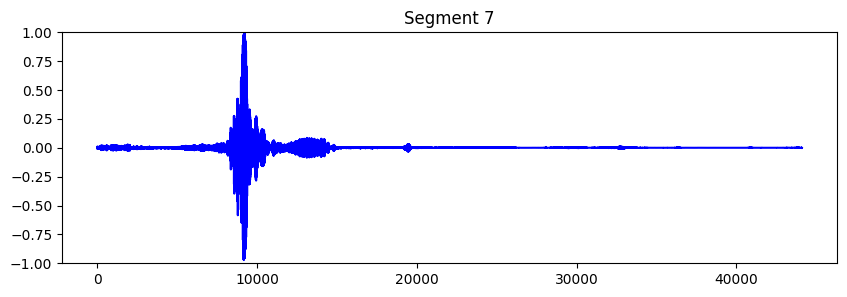

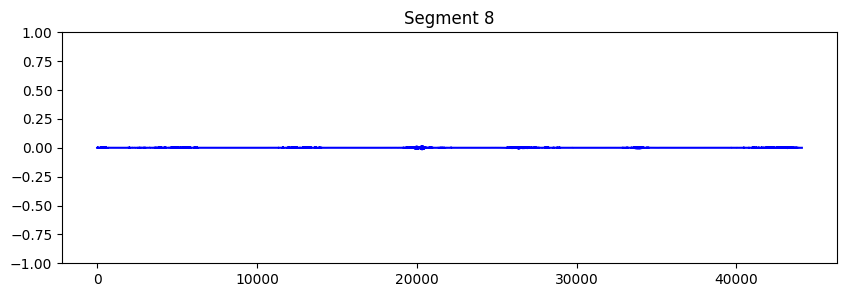

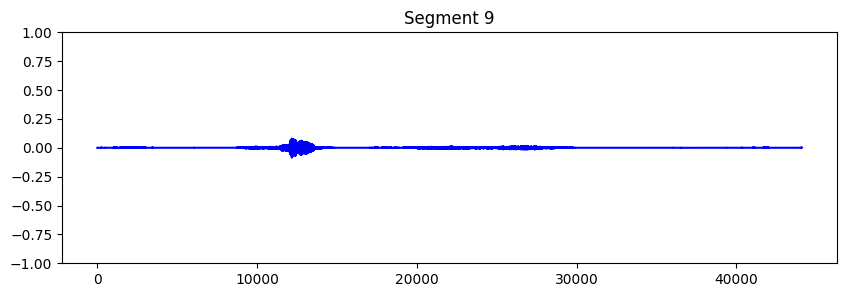

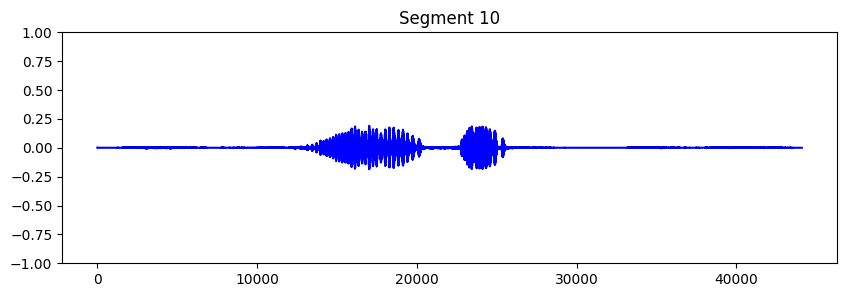

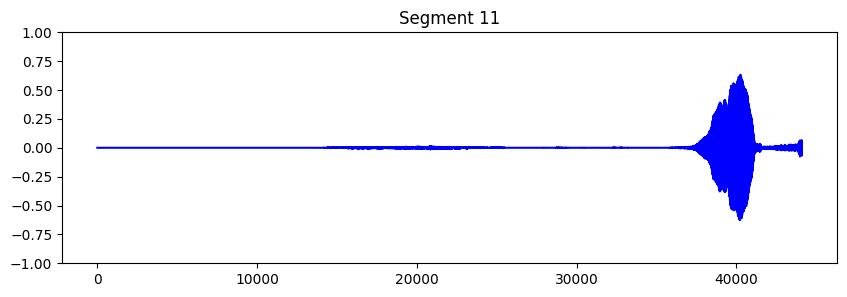

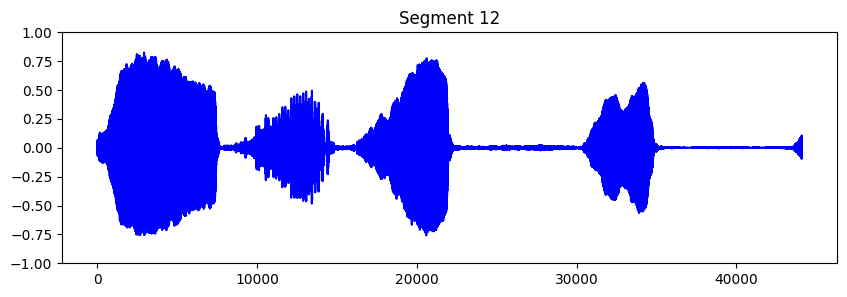

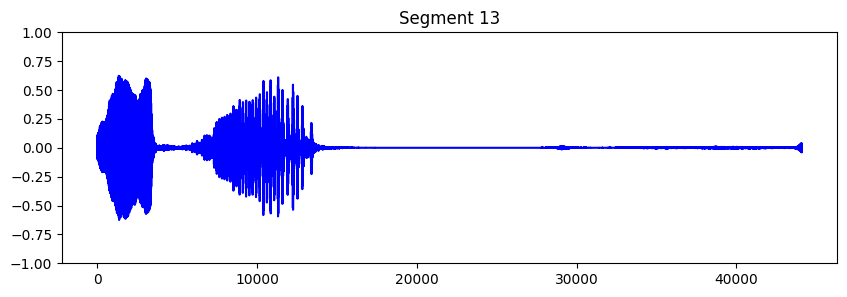

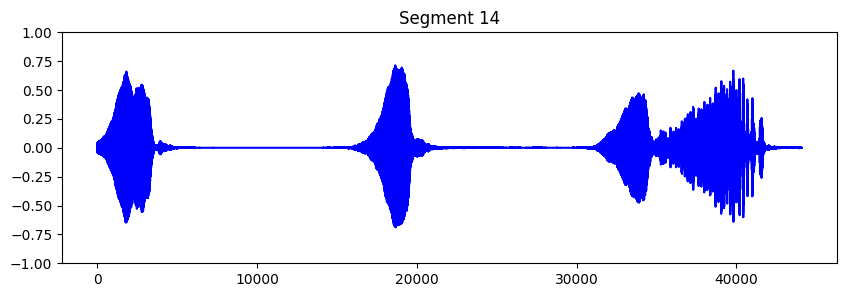

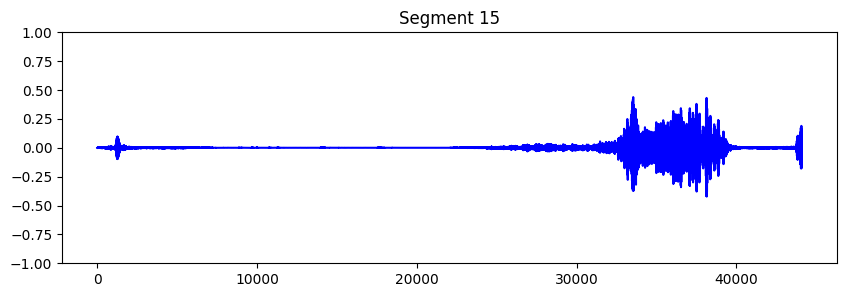

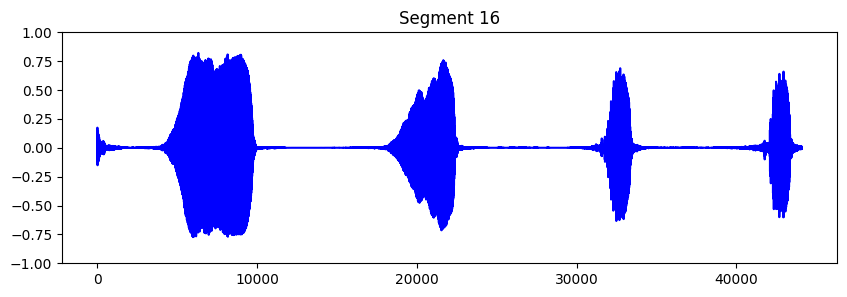

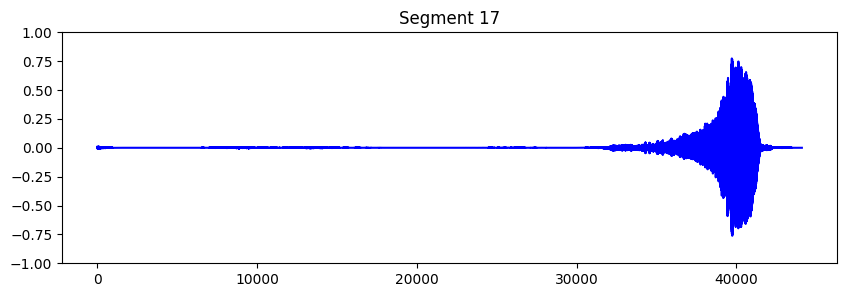

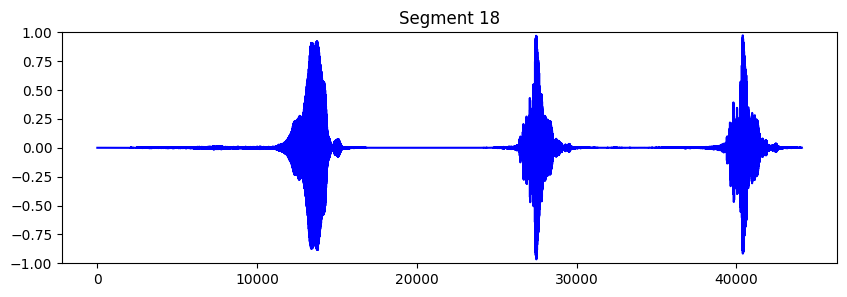

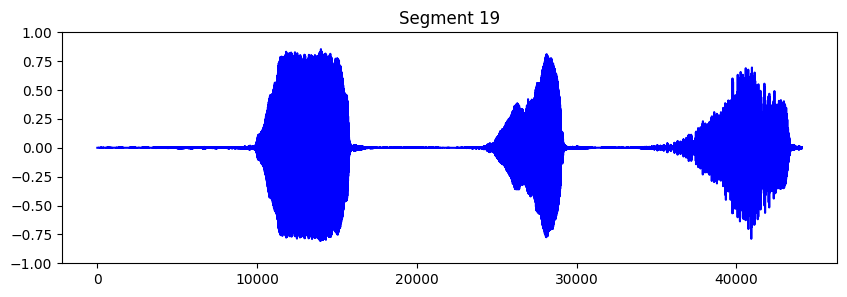

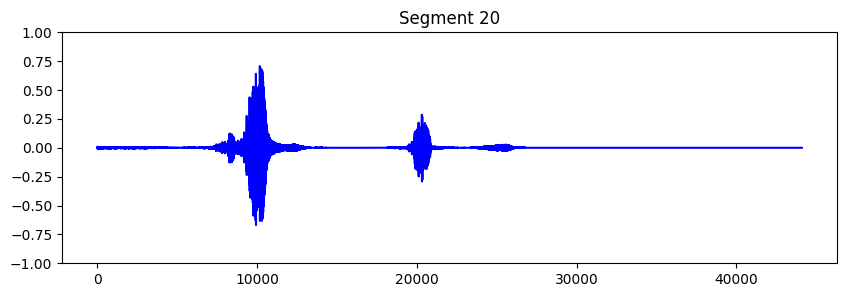

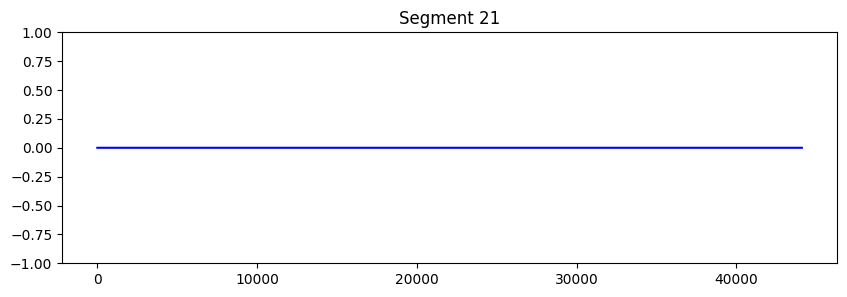

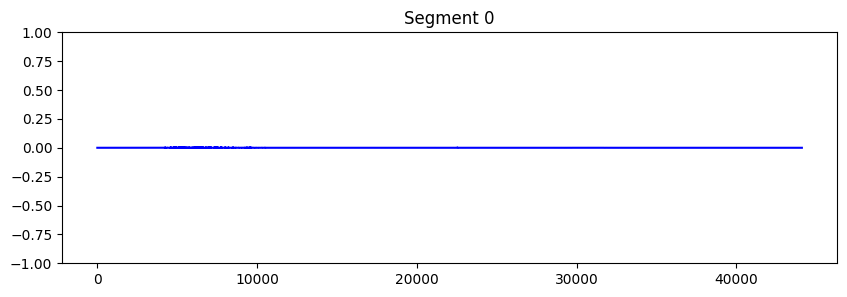

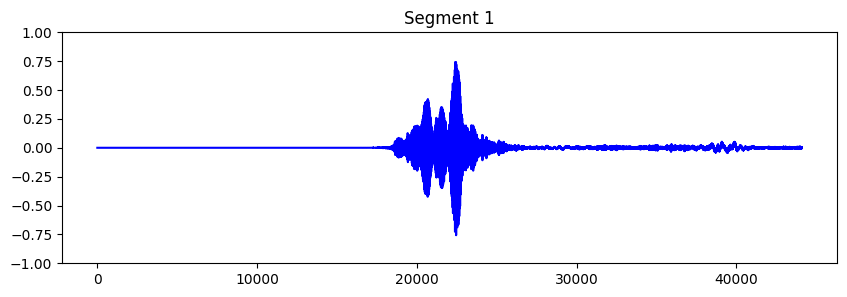

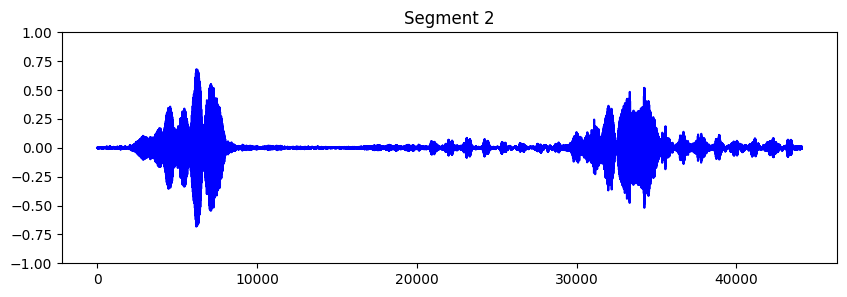

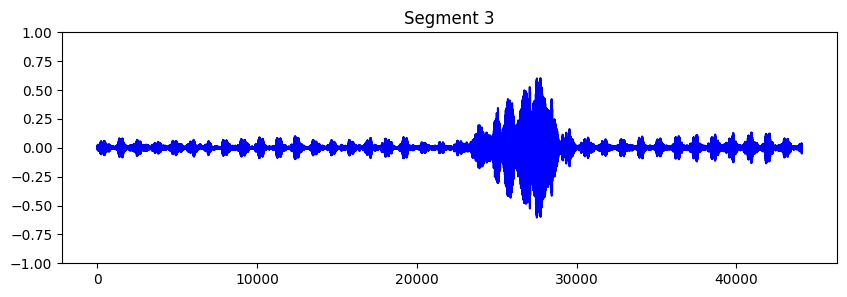

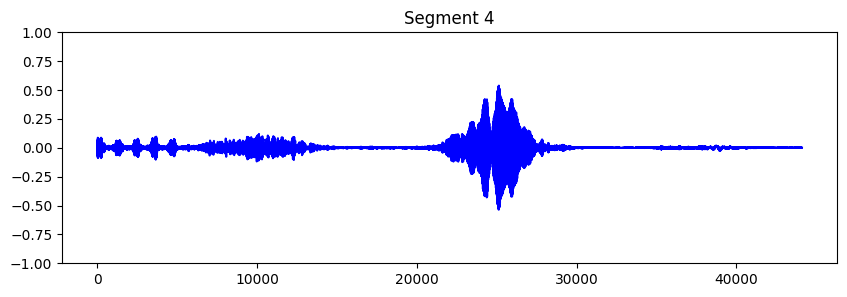

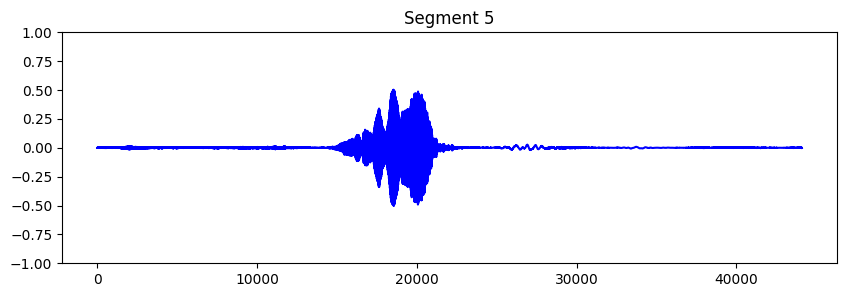

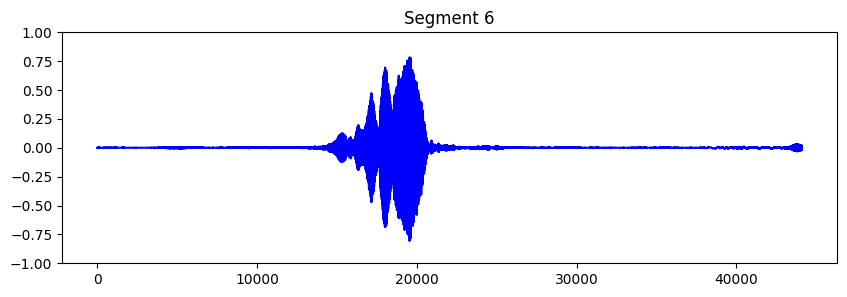

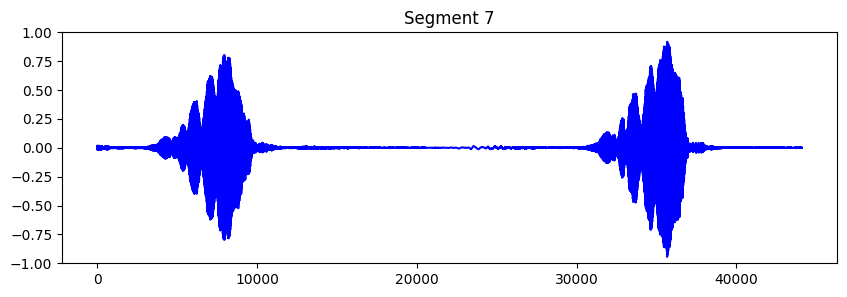

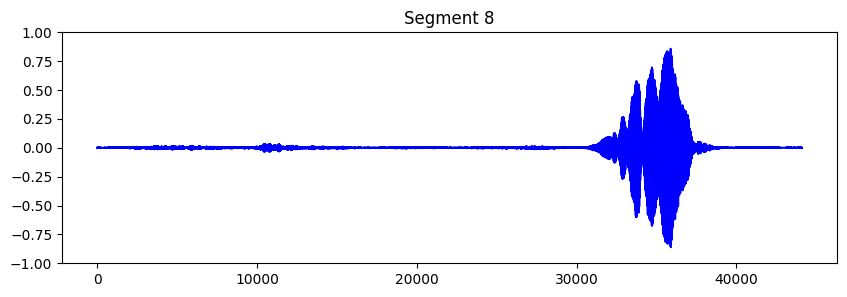

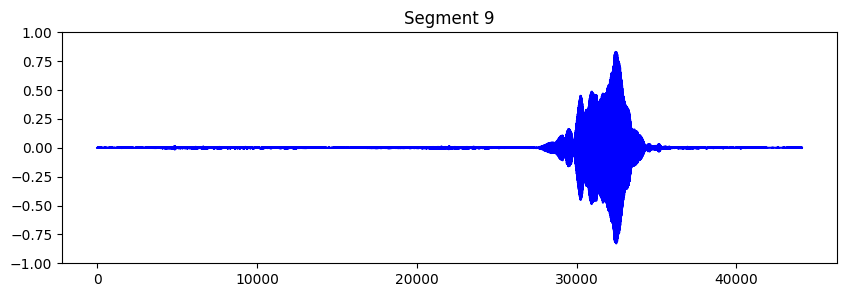

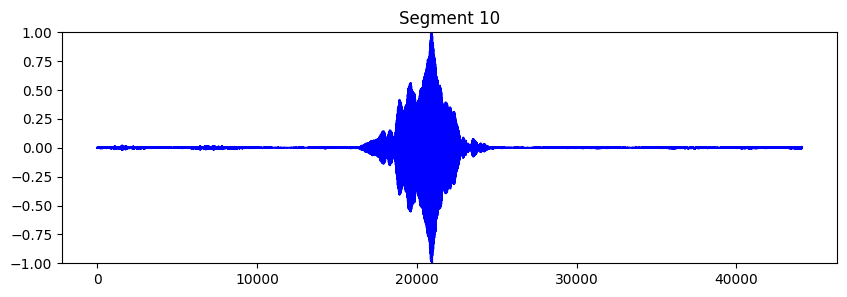

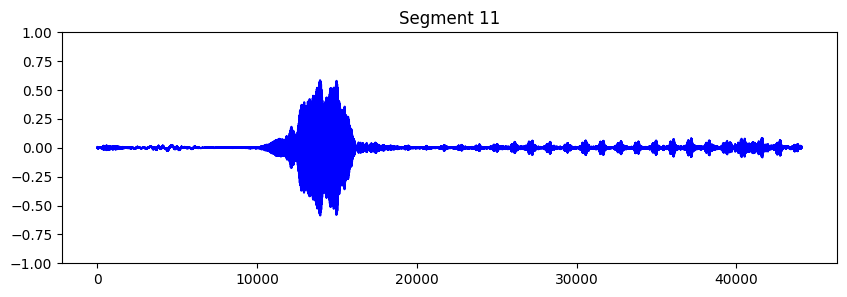

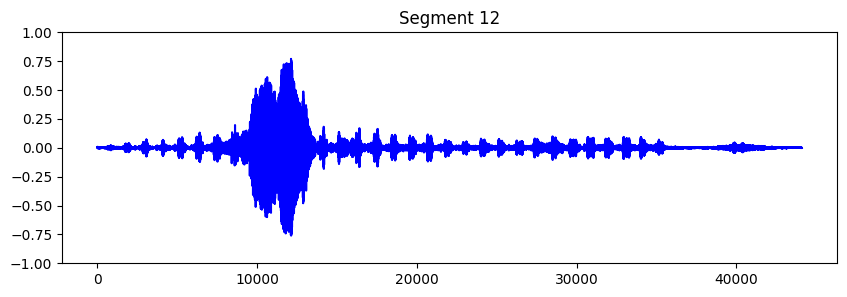

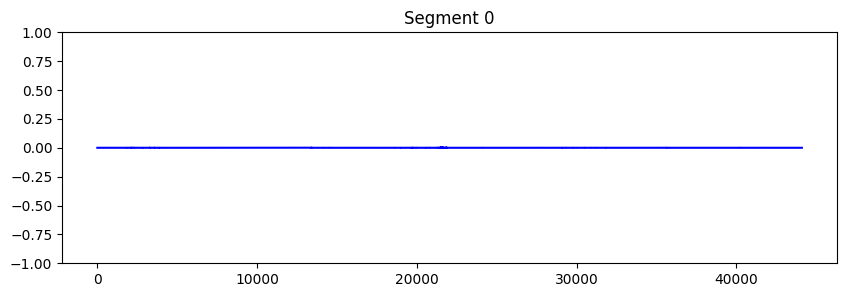

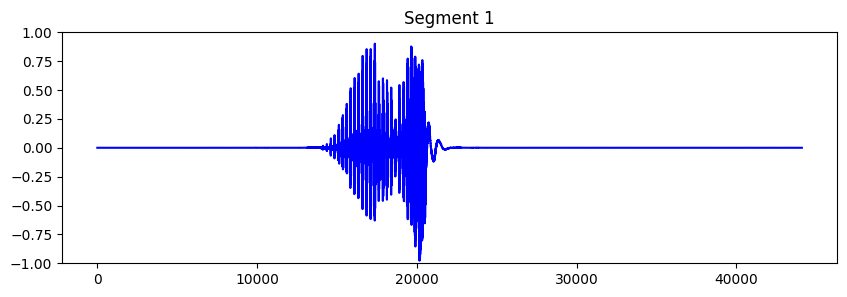

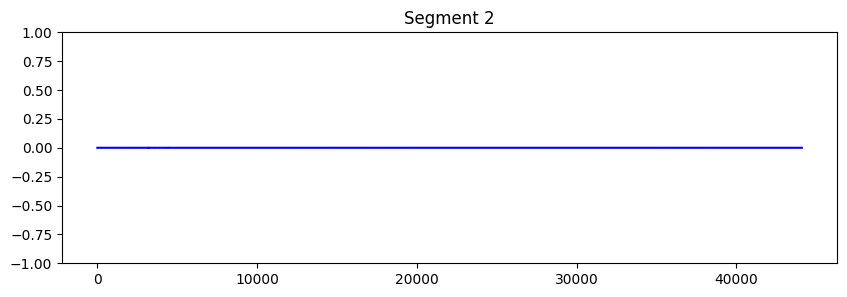

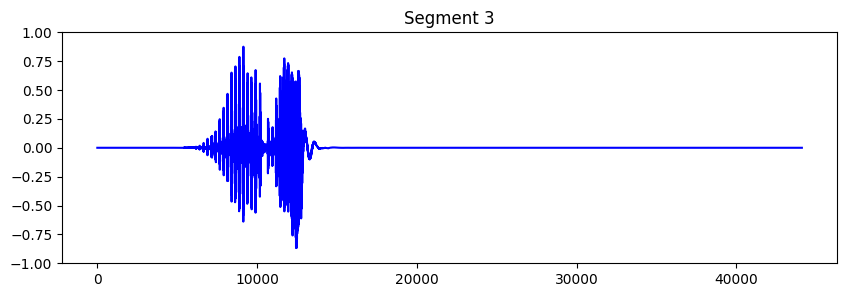

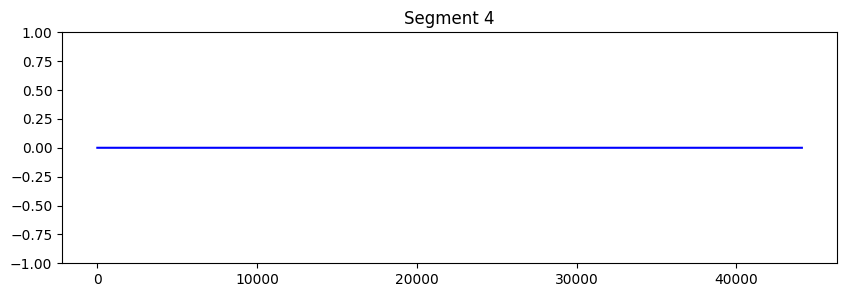

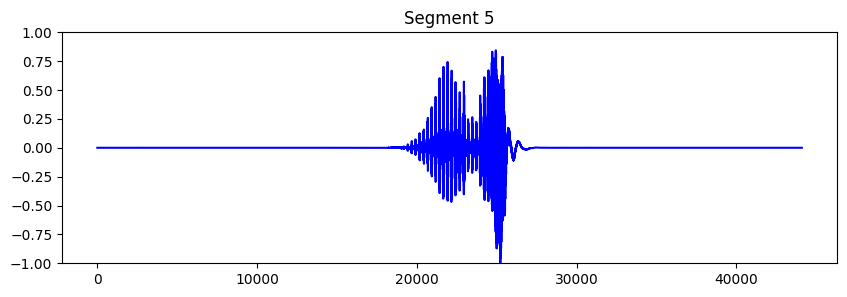

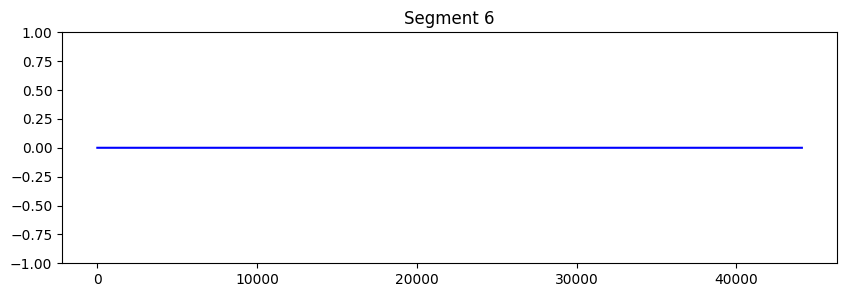

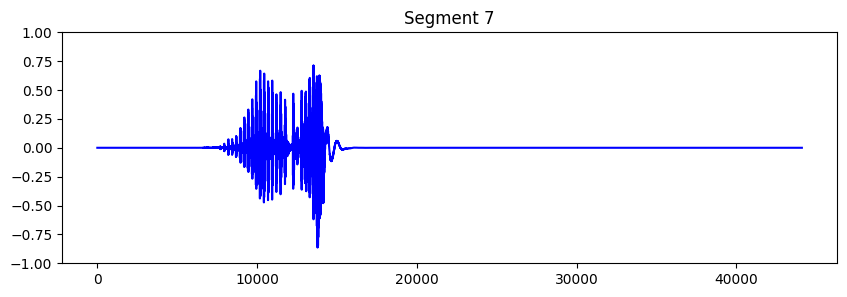

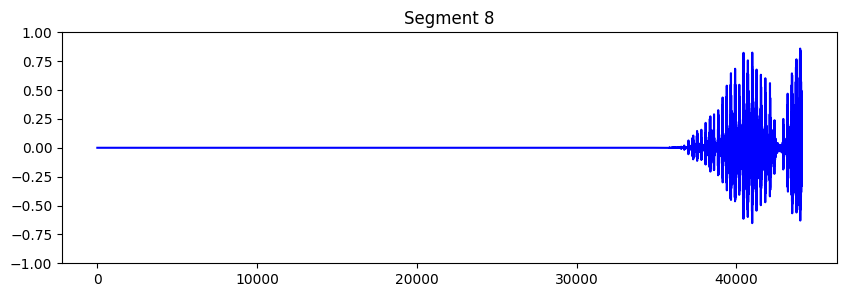

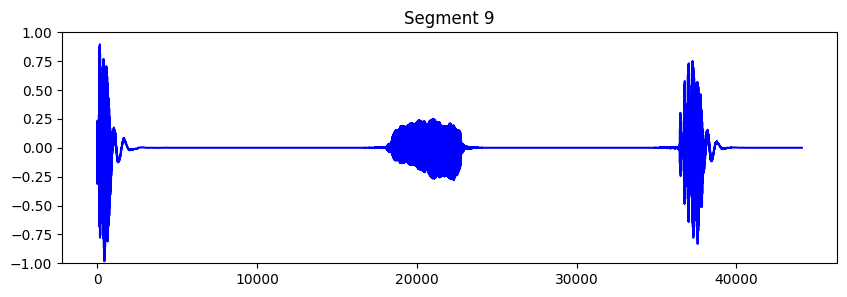

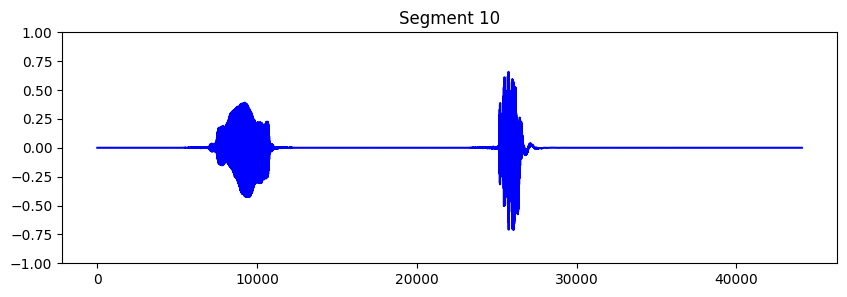

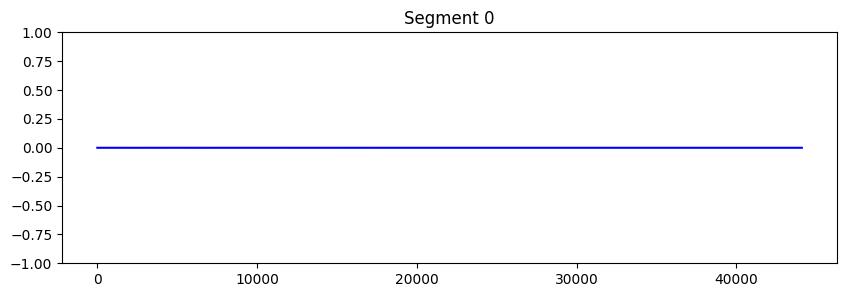

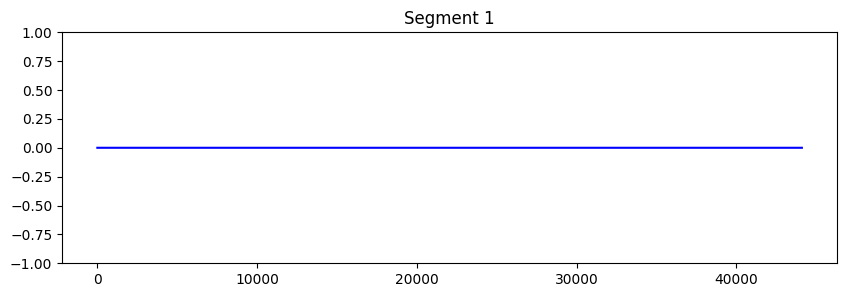

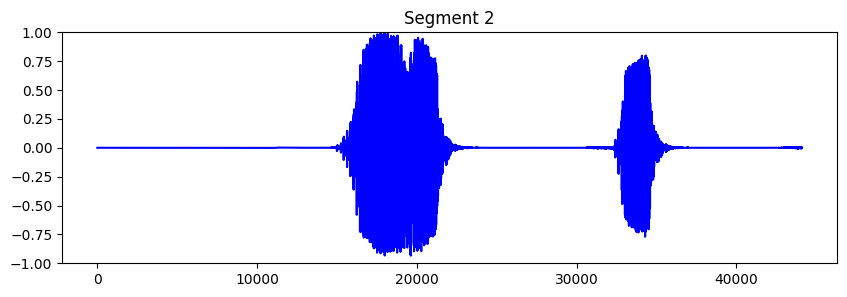

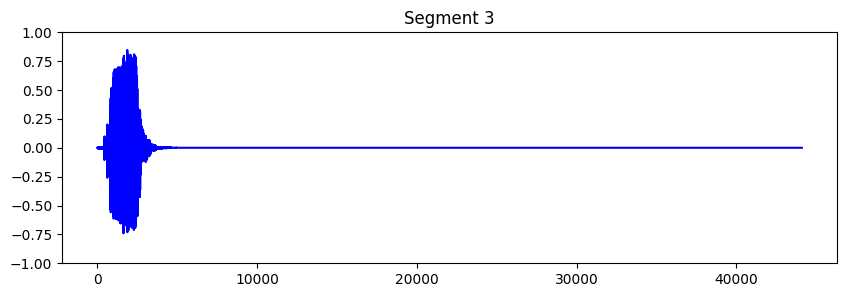

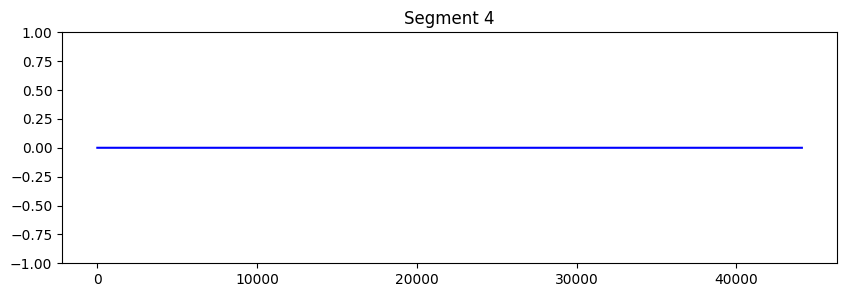

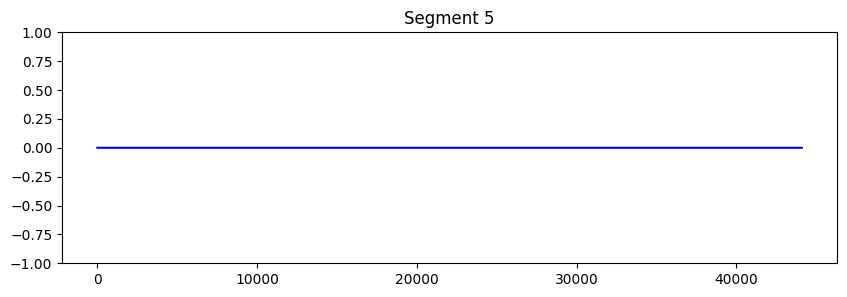

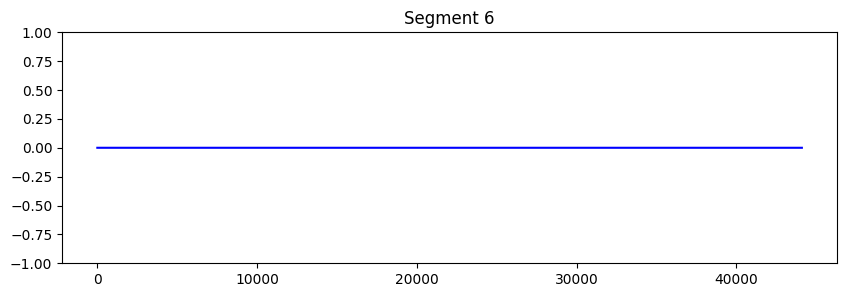

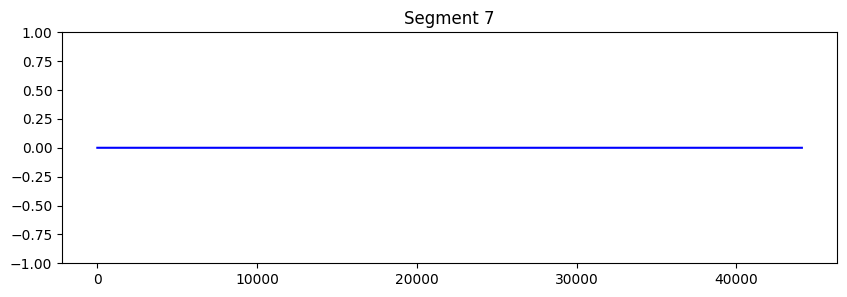

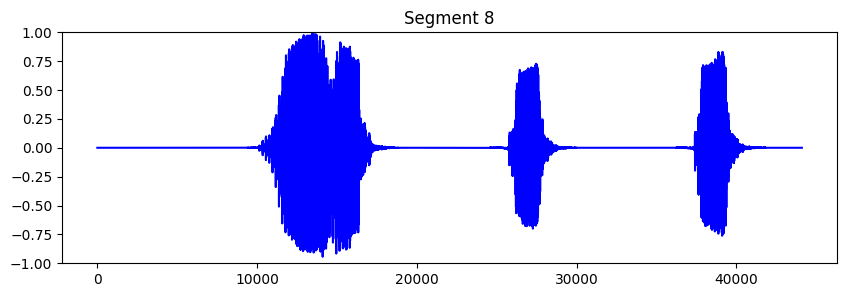

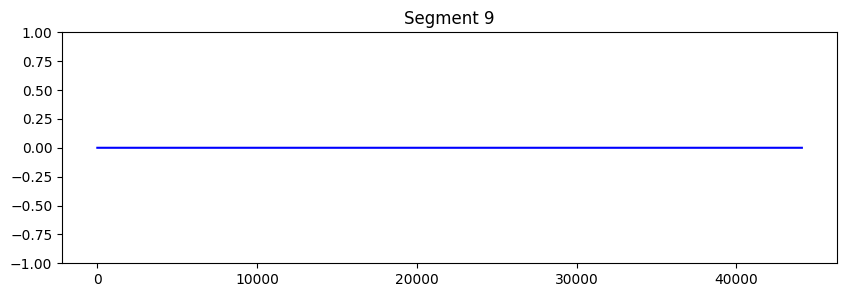

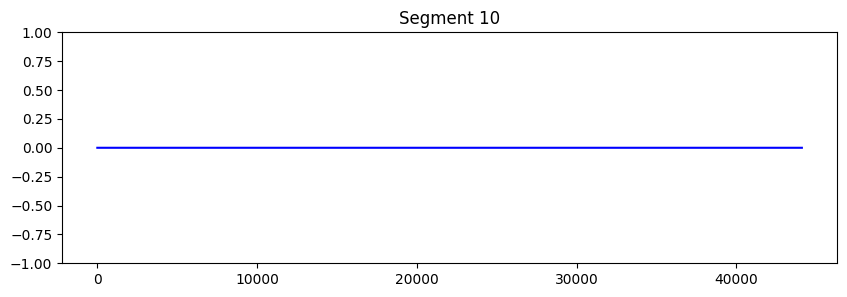

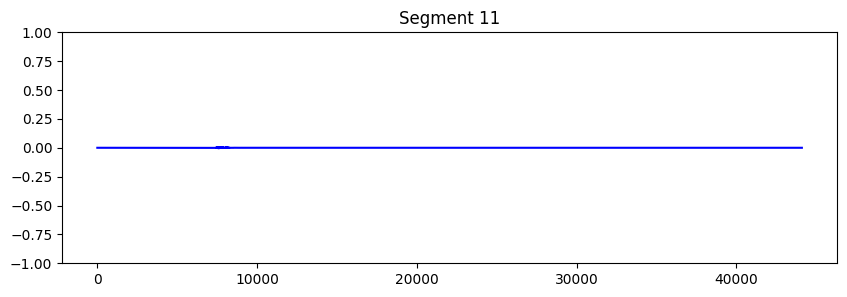

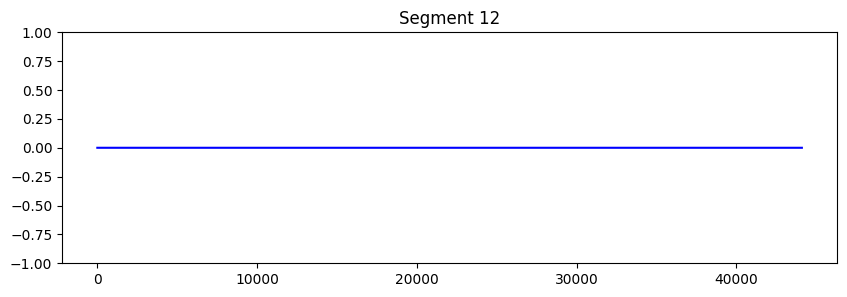

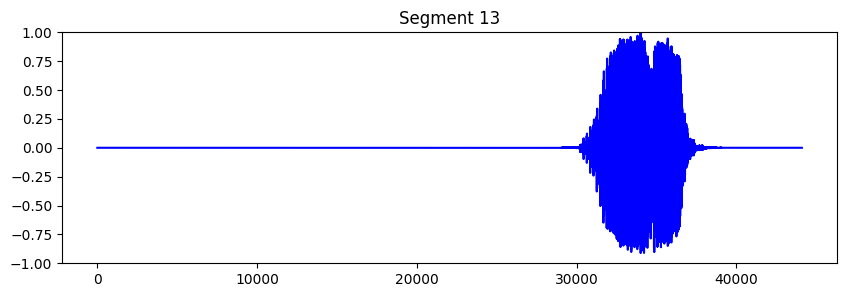

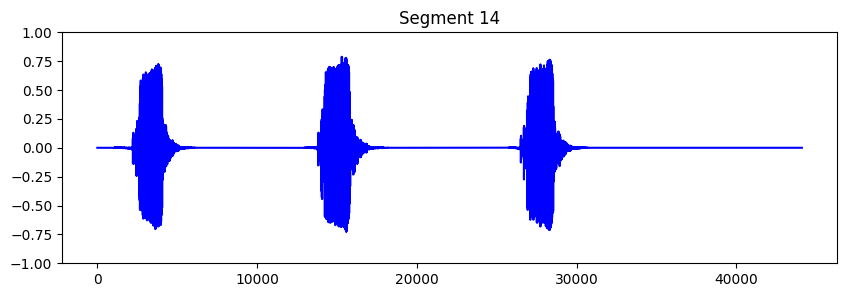

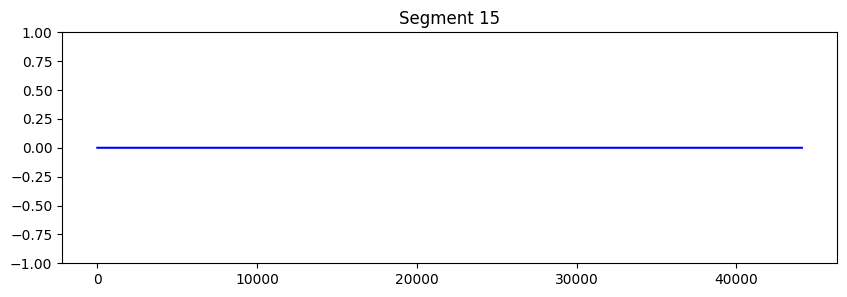

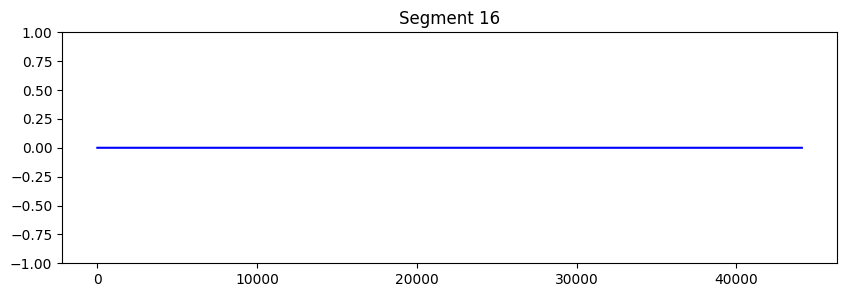

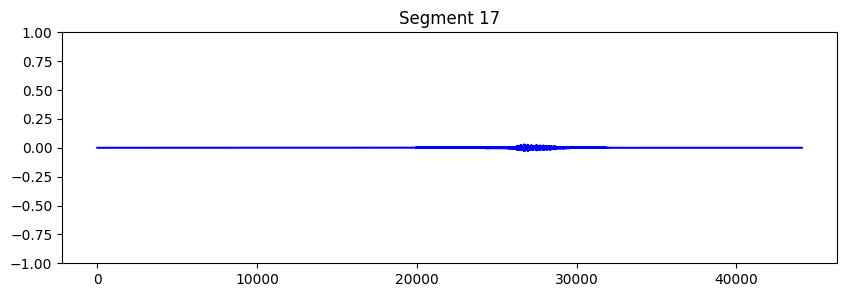

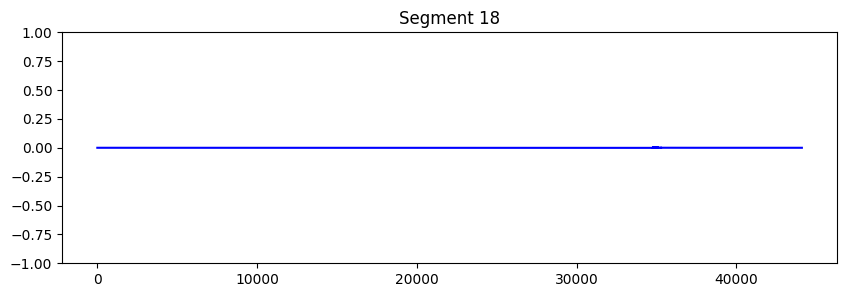

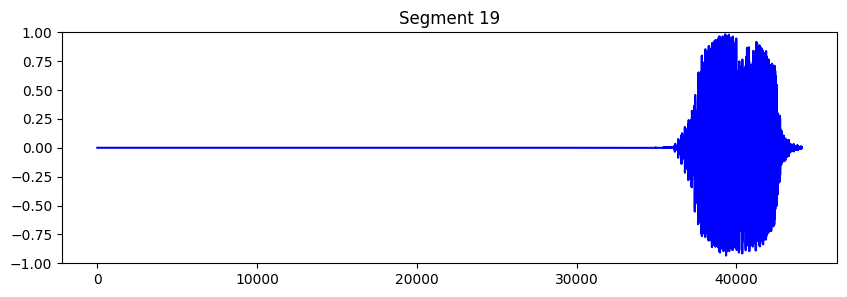

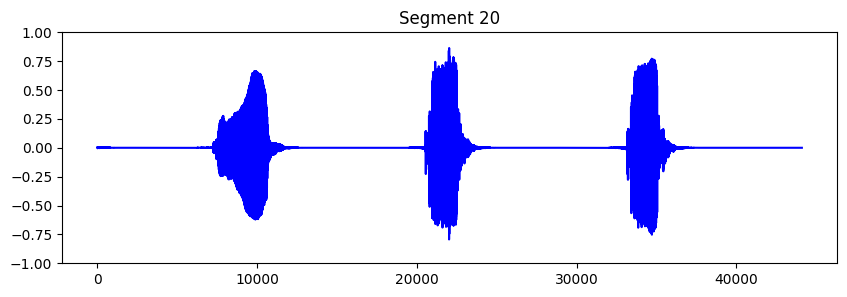

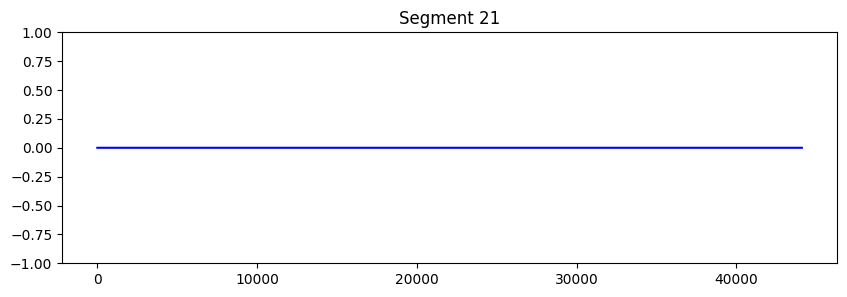

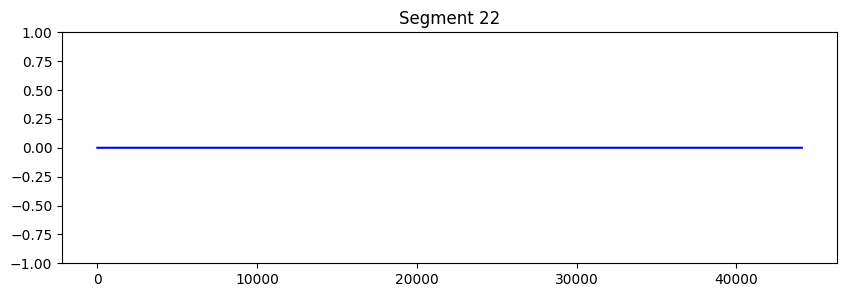

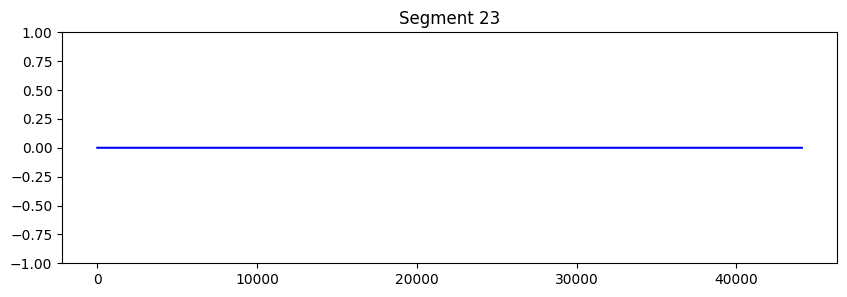

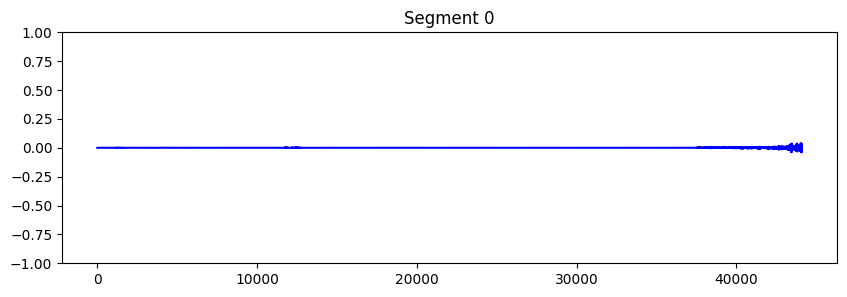

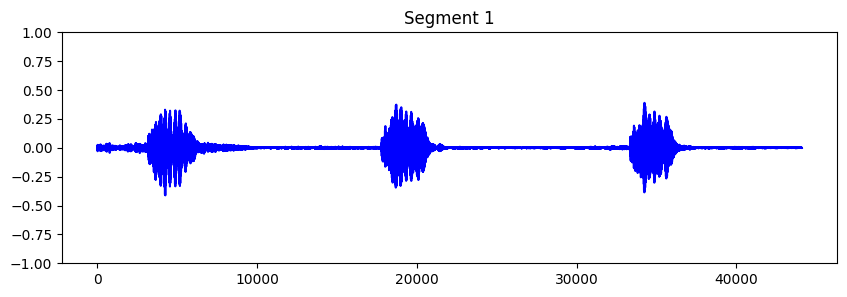

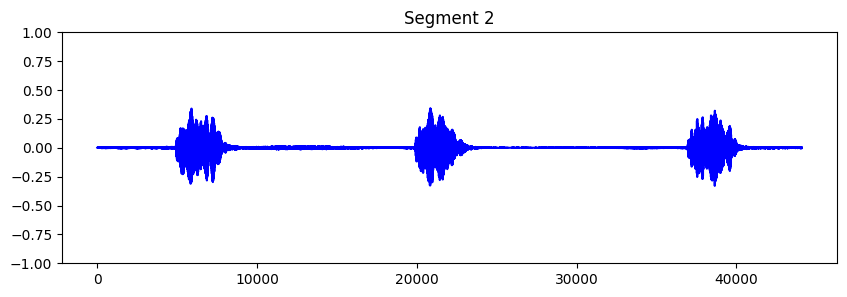

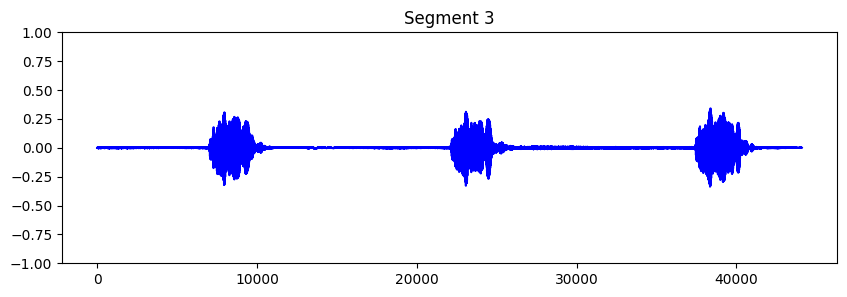

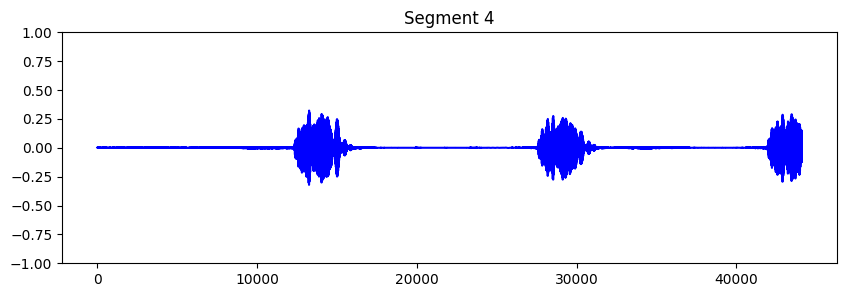

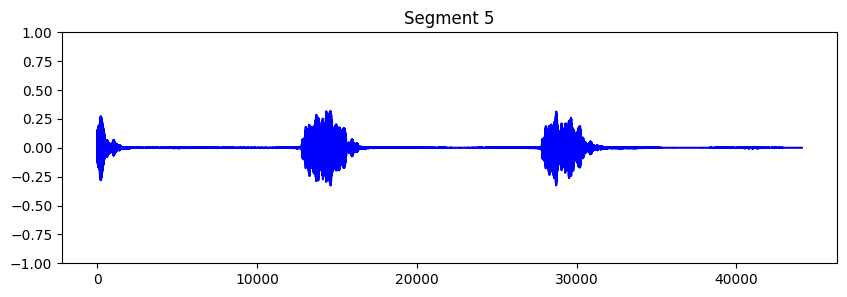

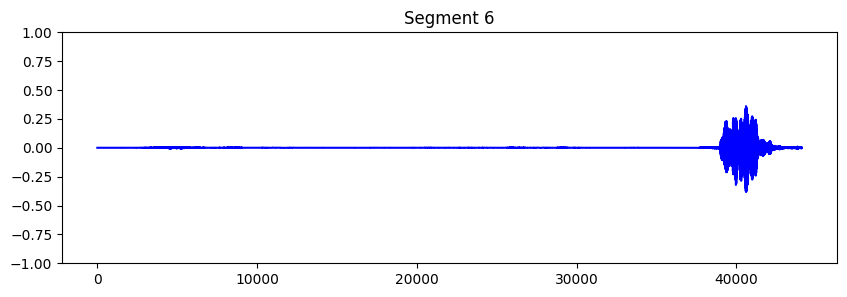

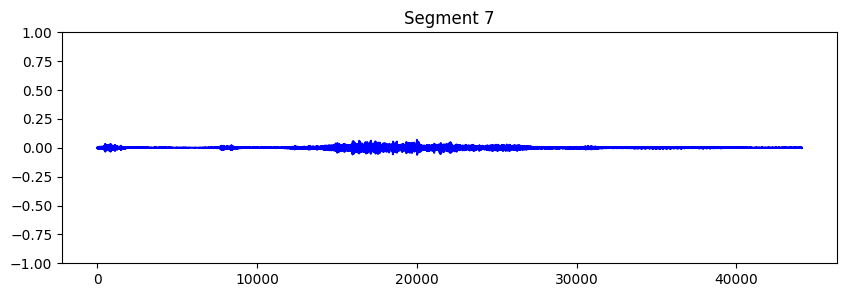

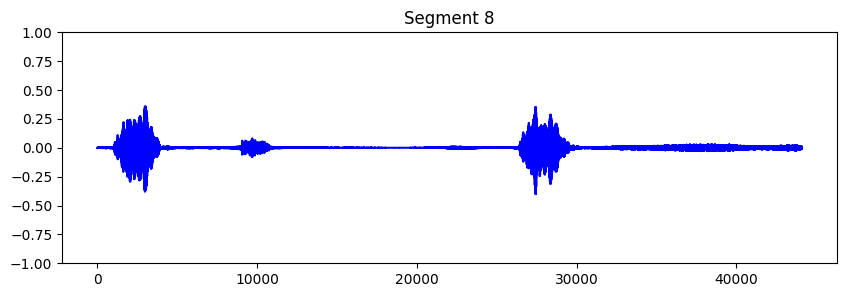

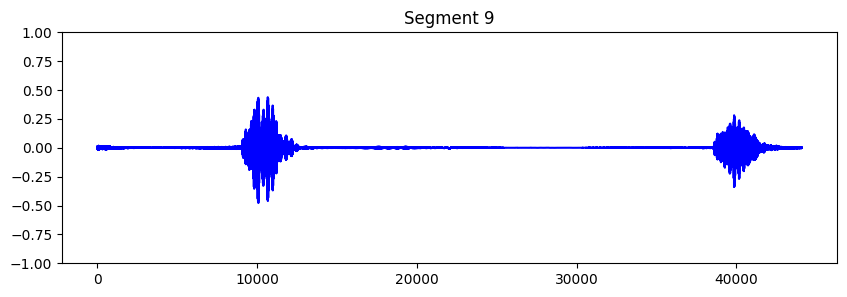

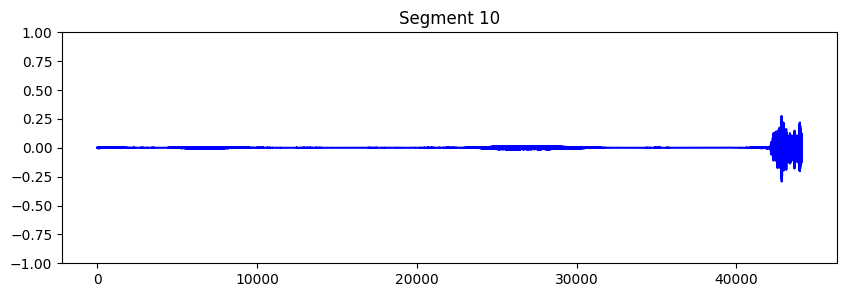

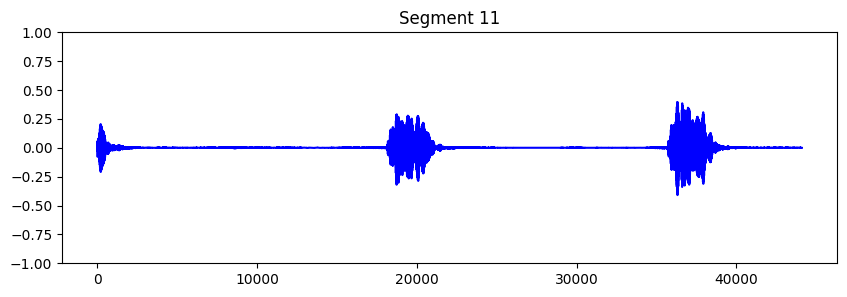

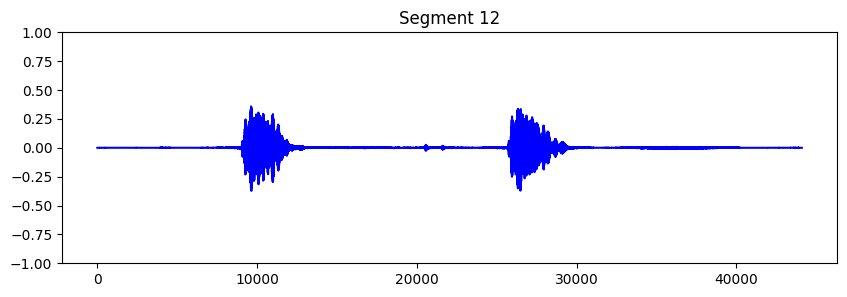

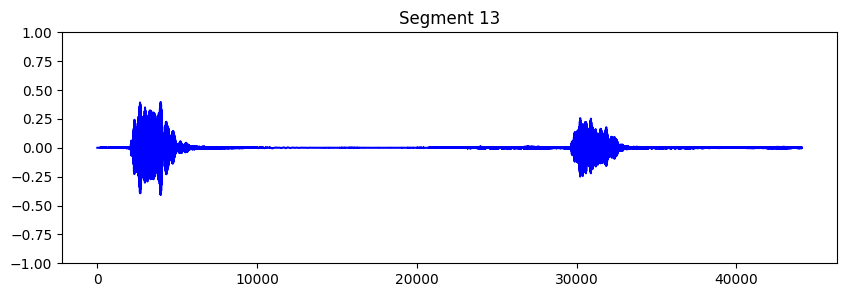

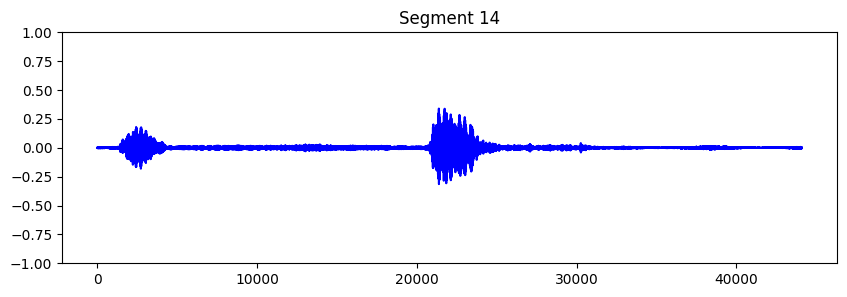

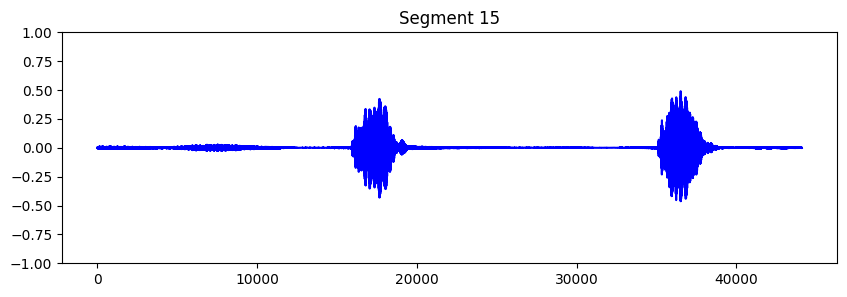

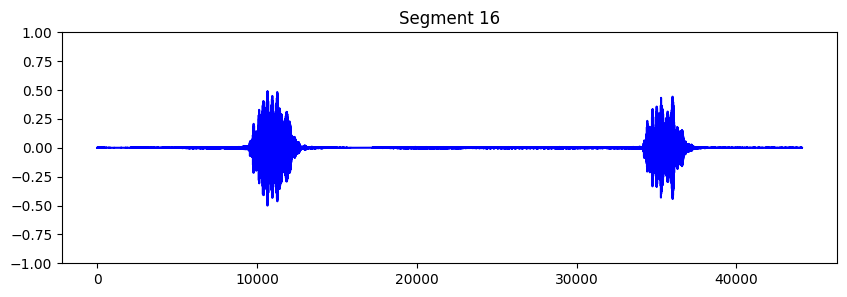

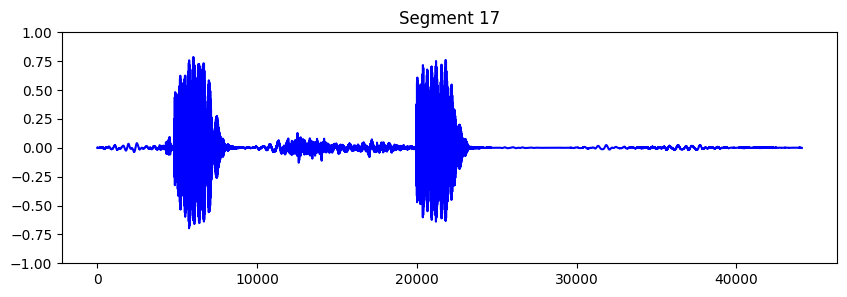

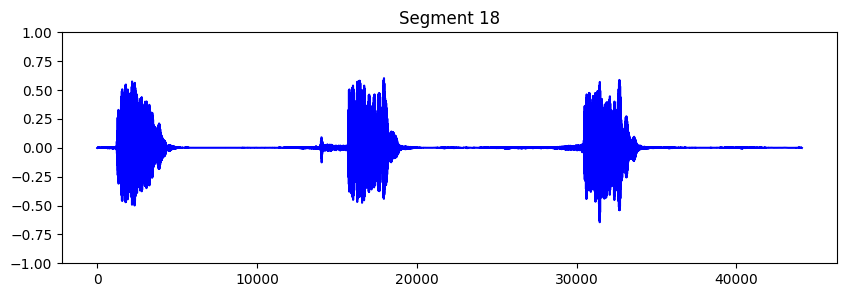

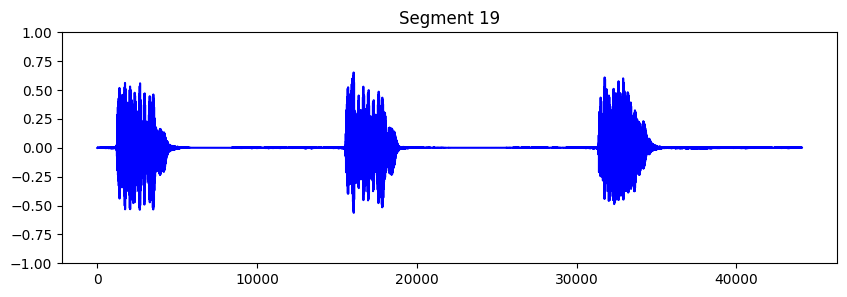

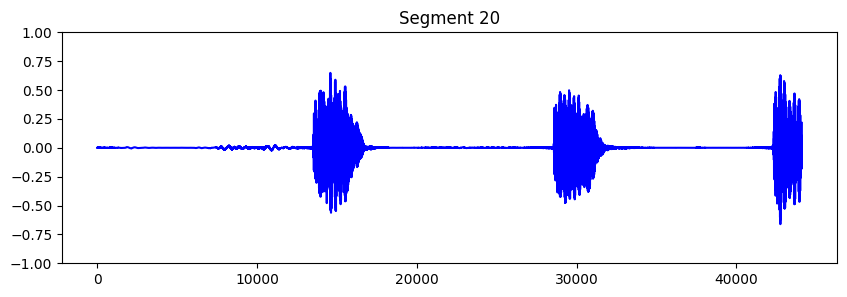

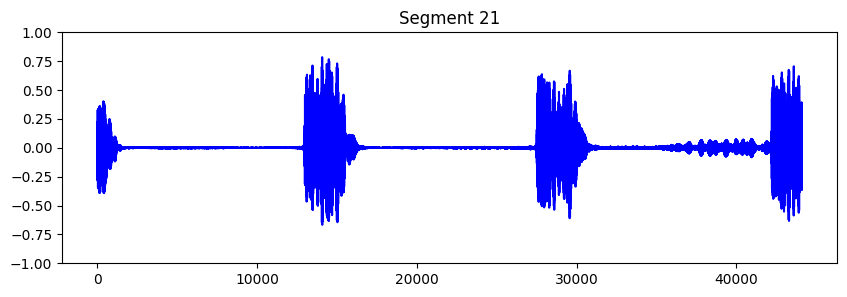

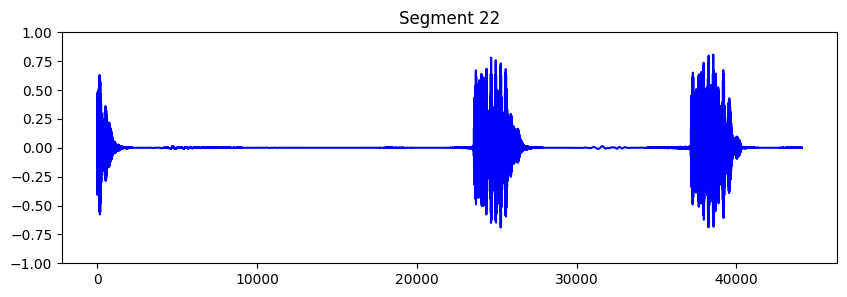

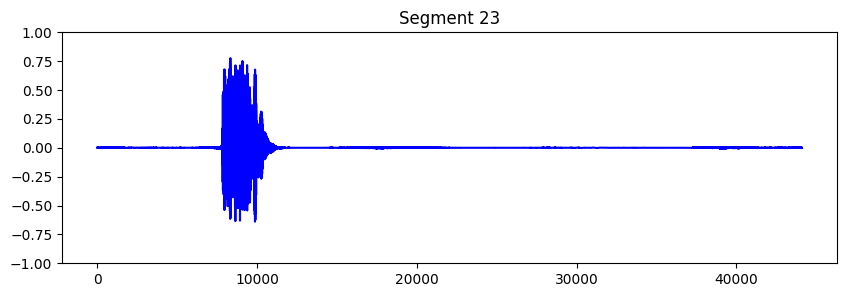

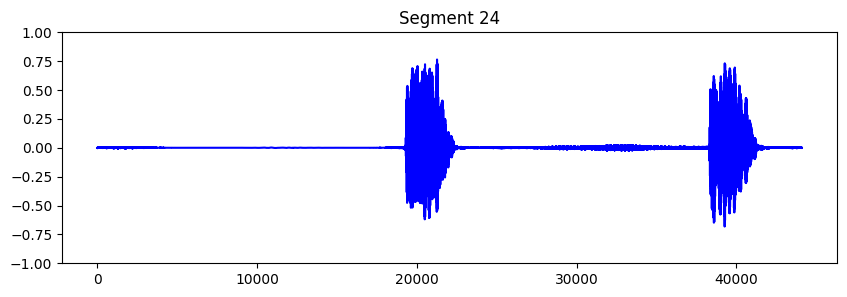

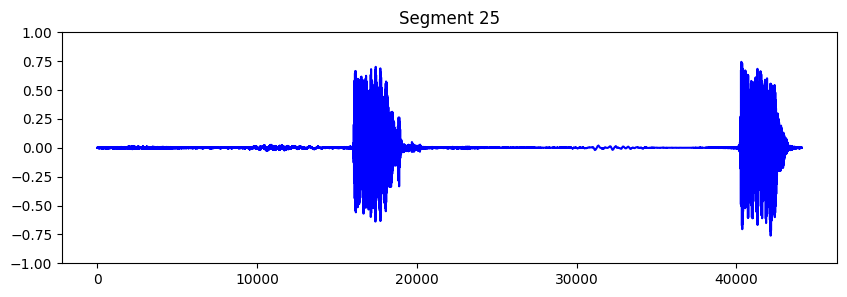

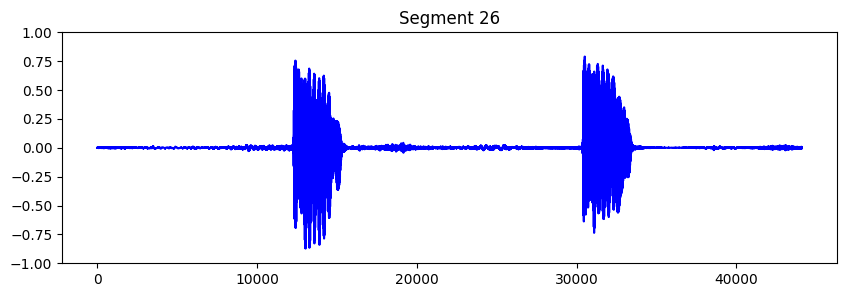

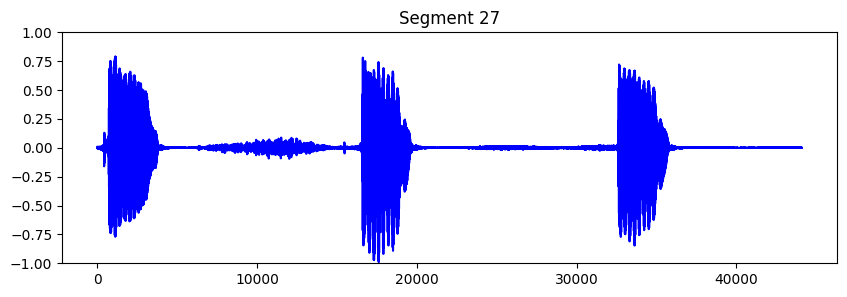

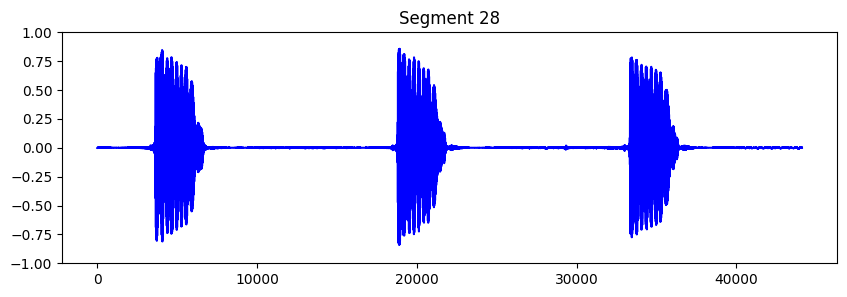

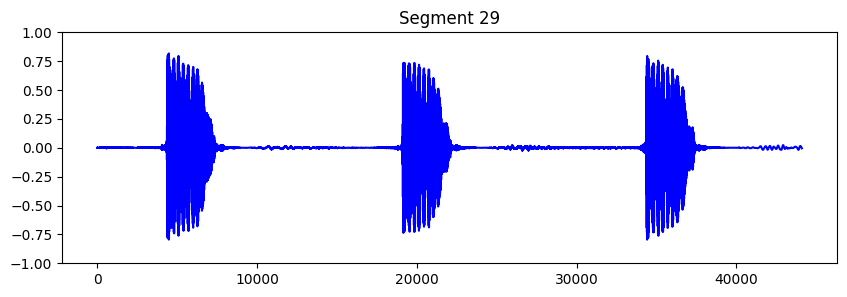

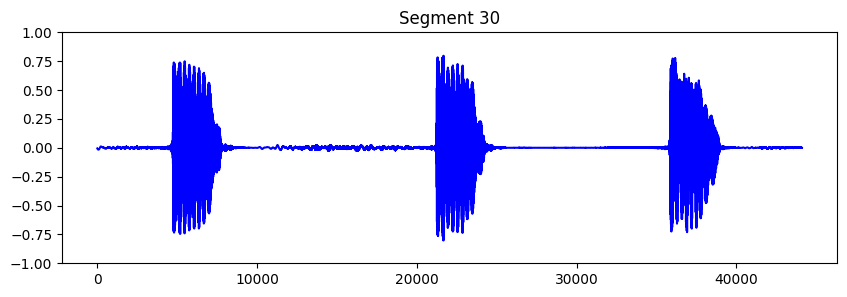

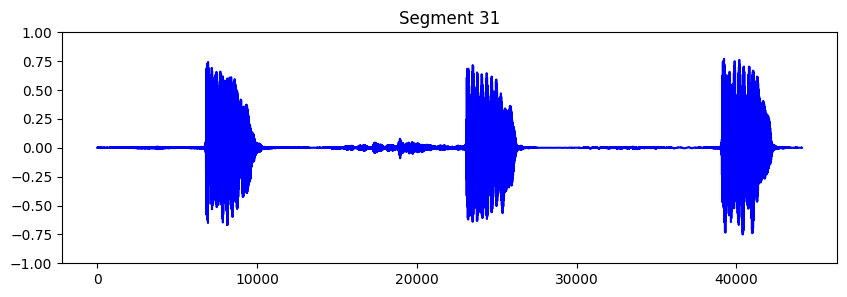

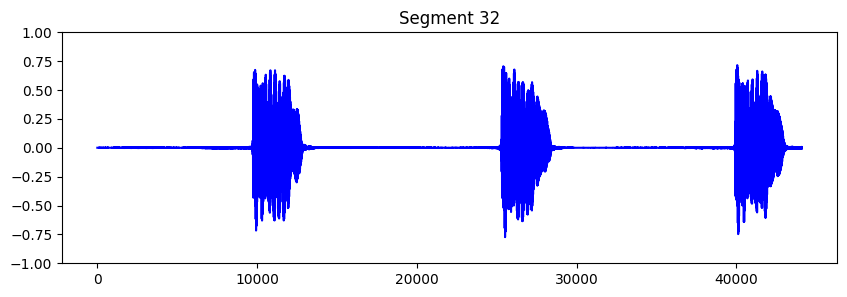

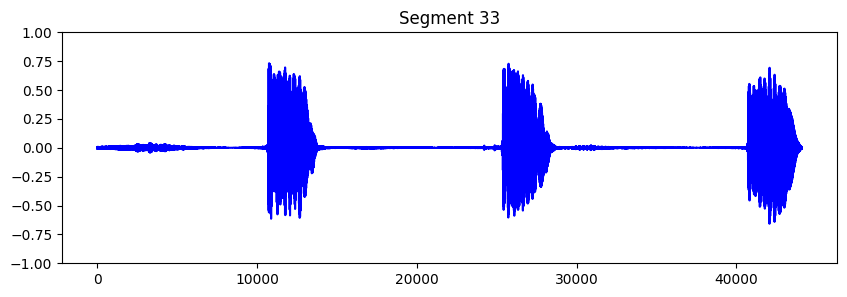

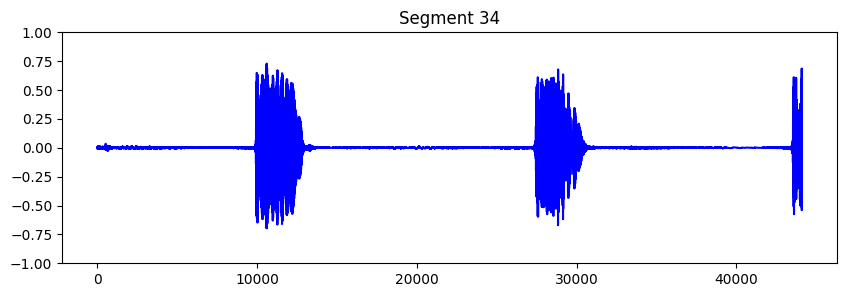

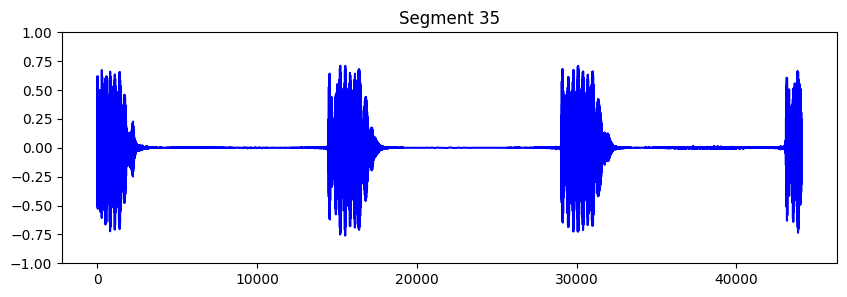

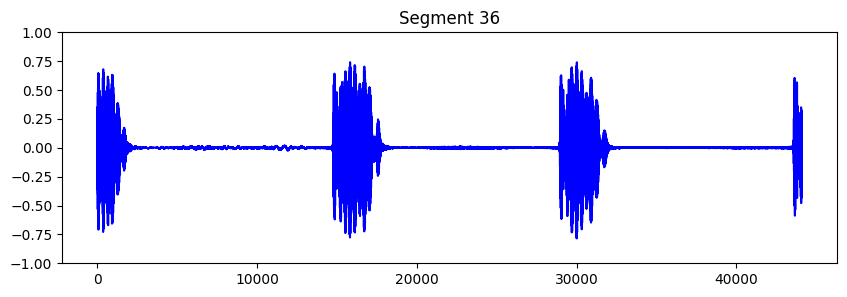

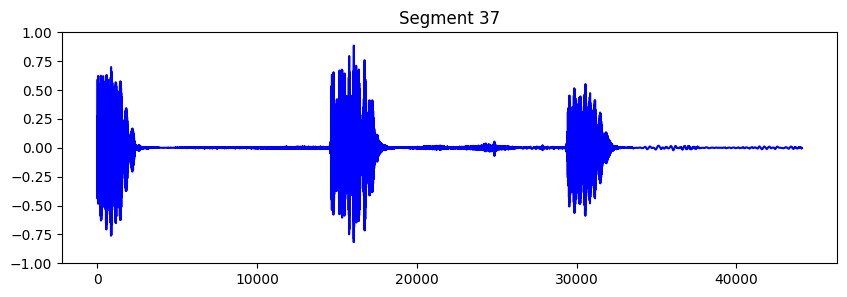

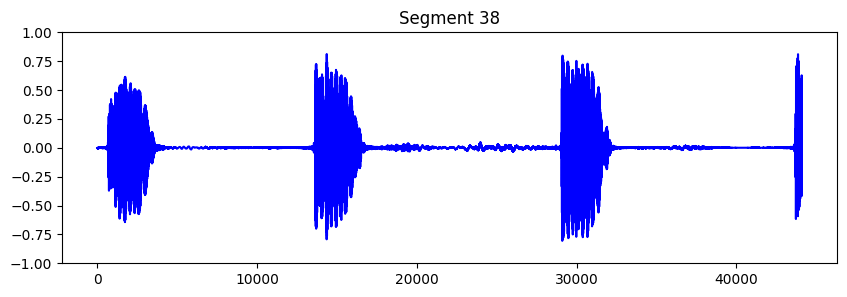

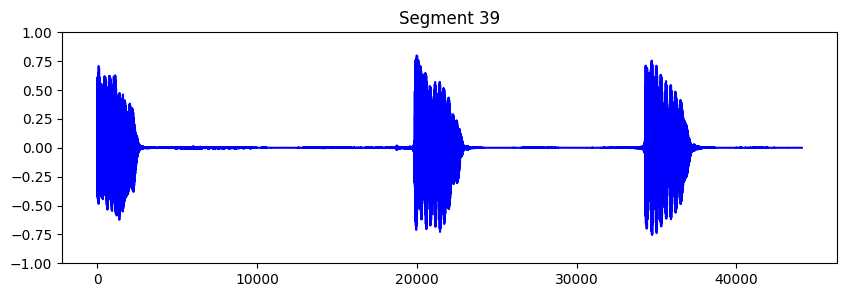

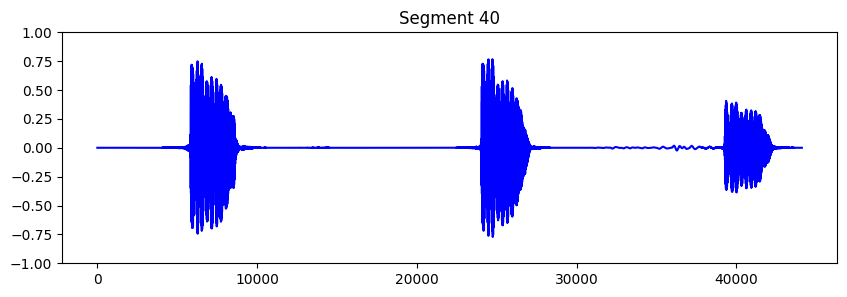

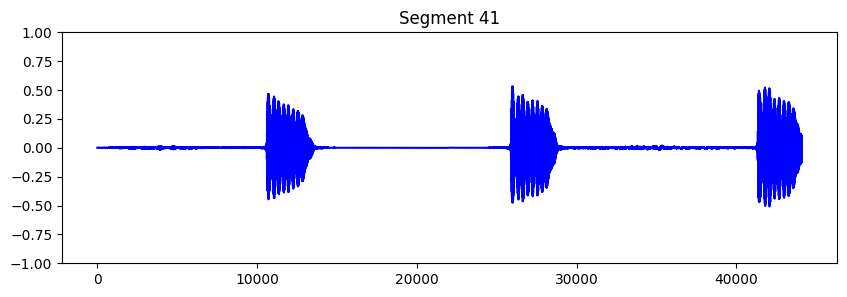

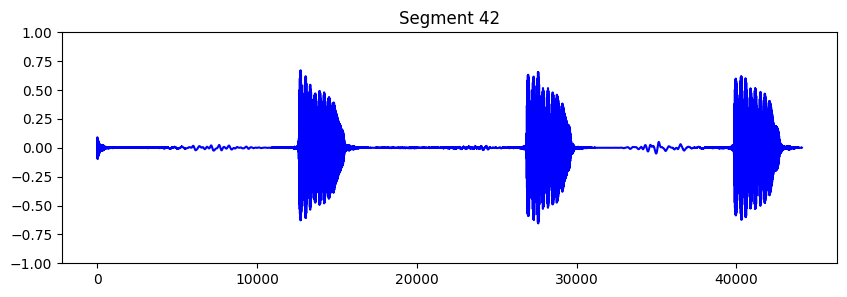

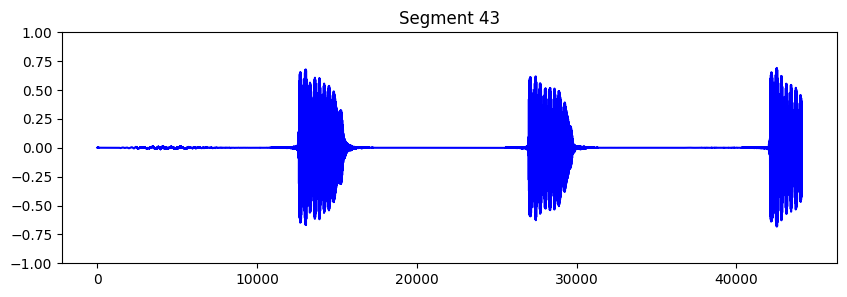

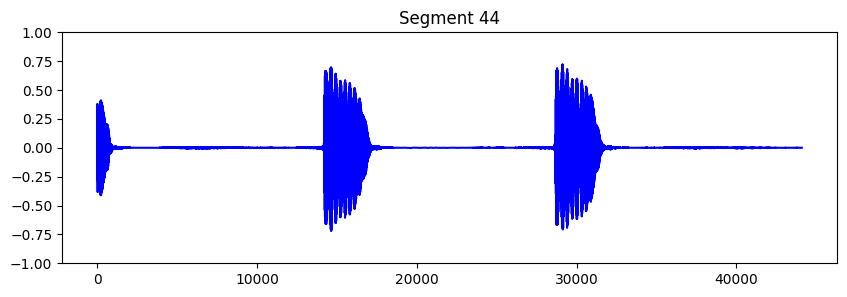

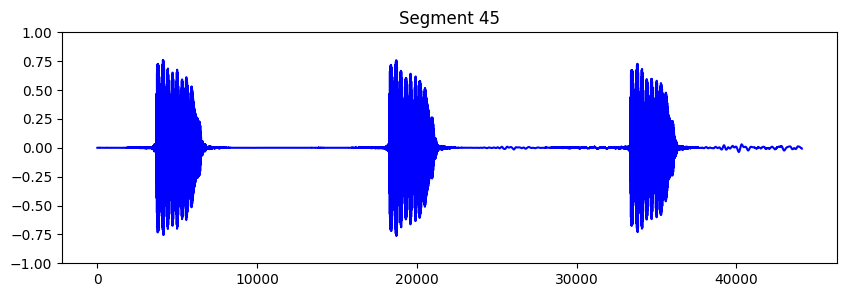

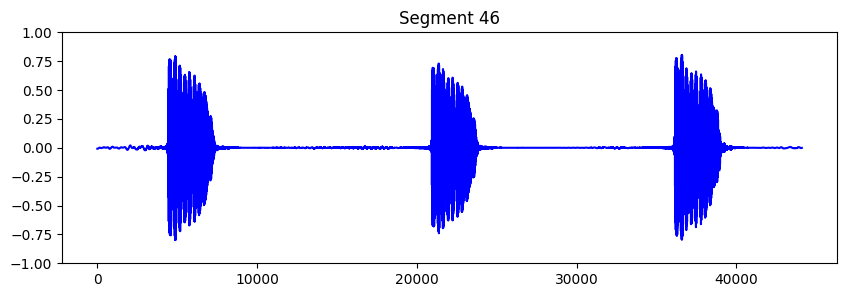

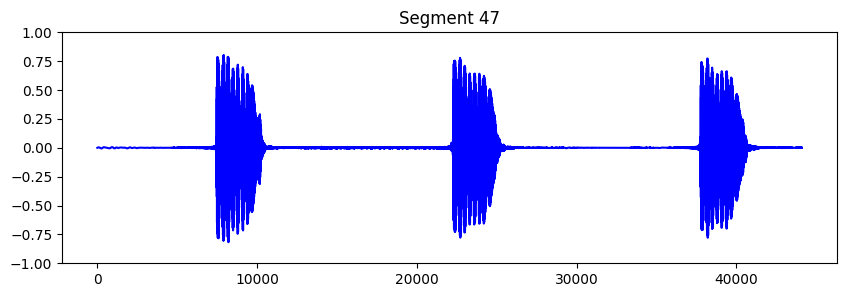

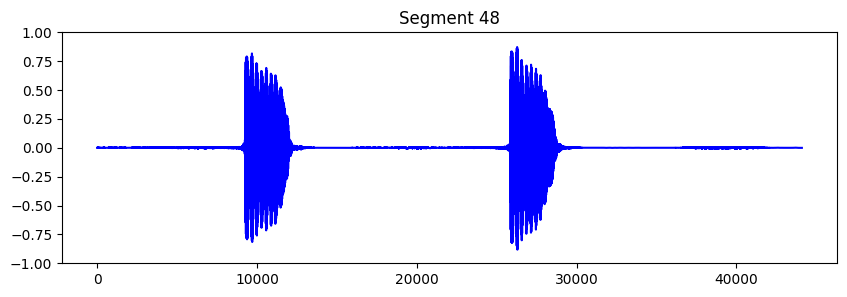

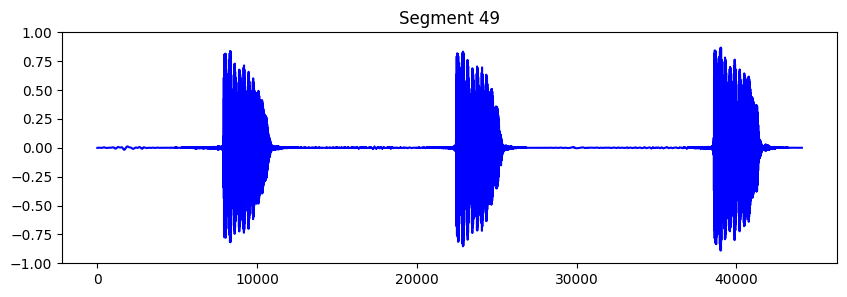

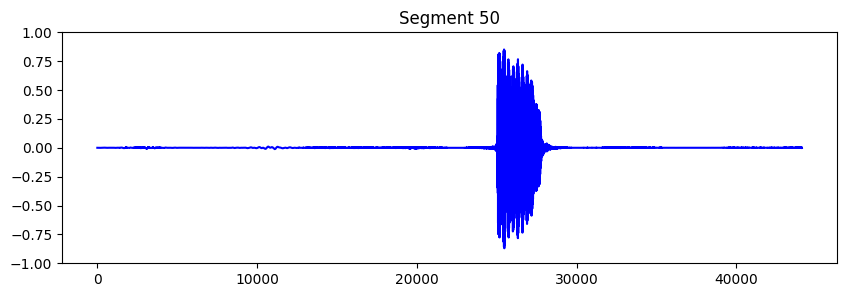

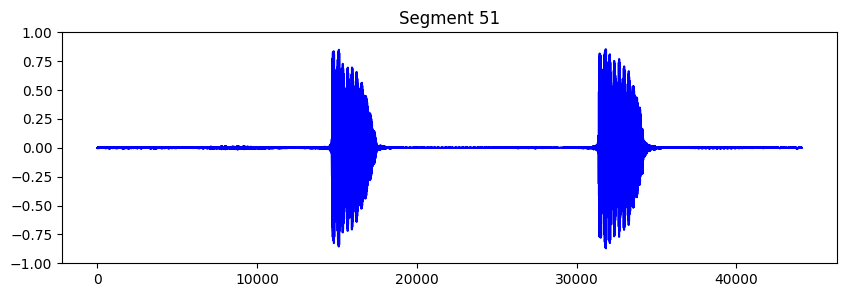

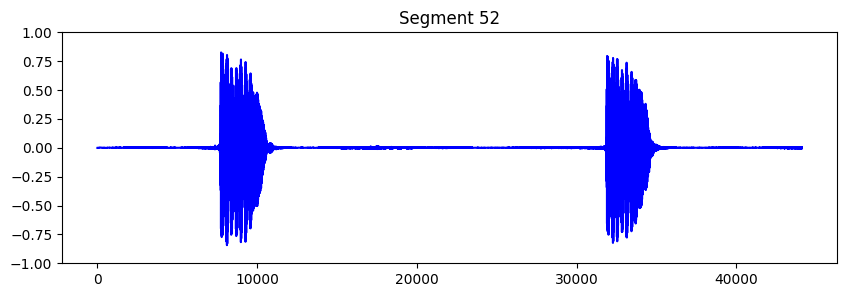

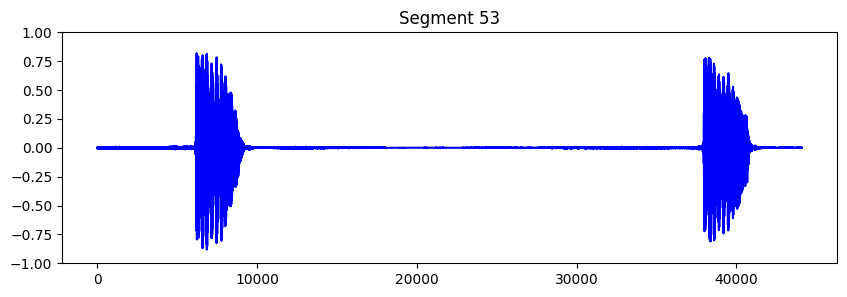

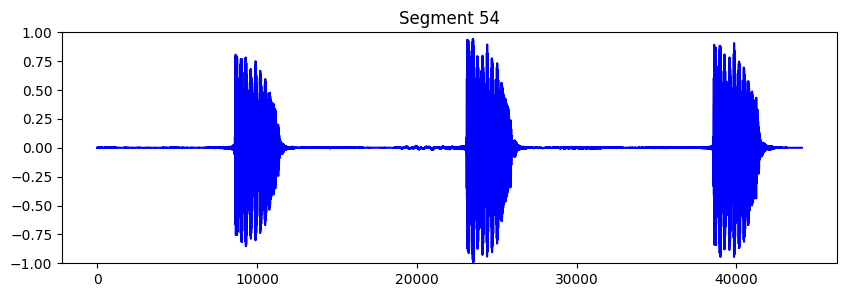

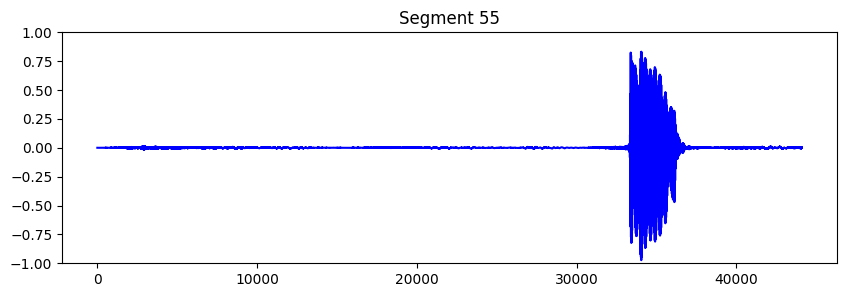

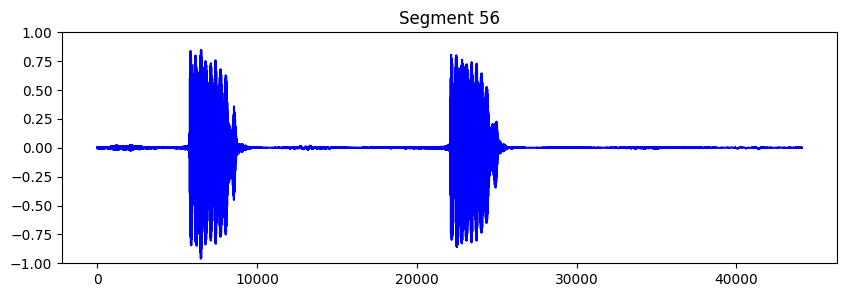

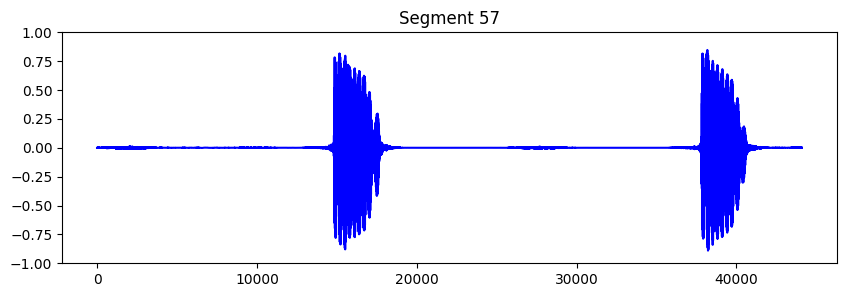

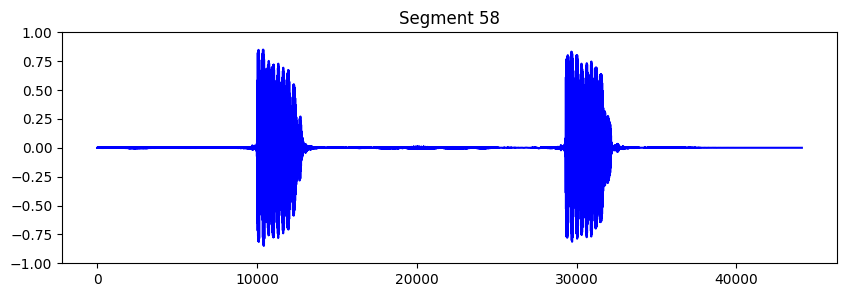

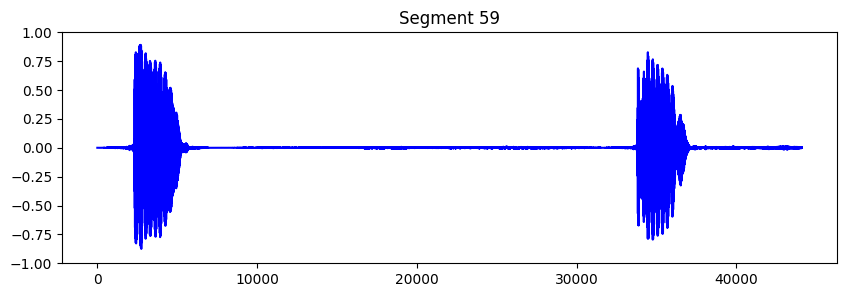

In [20]:
# Ruta del directorio para cargar los audios
directorio_audio = '/home/andres/Área de Trabalho/Andrés Peralta/Tesis/Código/Completo/1s/44Hz.Wav'

# Crear la carpeta 'segments' si no existe
segments_dir = os.path.join(directorio_audio, 'segments')
if not os.path.exists(segments_dir):
    os.makedirs(segments_dir)

# Crear las carpetas 'train' y 'test' dentro de 'segments' si no existen
train_dir = os.path.join(segments_dir, 'train')
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
test_dir = os.path.join(segments_dir, 'test')
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Duración deseada de los segmentos en segundos
segment_duration = 1


for audio in os.listdir(directorio_audio):
    if audio.endswith('.wav'):
        input_wavfile = os.path.join(directorio_audio, audio)
        sr, signal = wavfile.read(input_wavfile)
        signal = normalize_signal(signal)
        
        # Realizar la reducción de ruido a los audios
        filtered_signal = nr.reduce_noise(y=signal, sr=sr)
        filtered_signal = normalize_signal(filtered_signal)
        
        # Segmentar la señal en segmentos de audio de 1 segundo
        segment_samples = int(segment_duration * sr)
        num_segments = len(filtered_signal) // segment_samples
        
        # Obtener el nombre del archivo sin la extensión
        audio_name = os.path.splitext(audio)[0]
        
        for i in range(num_segments):
            start = i * segment_samples
            end = (i + 1) * segment_samples
            segment = filtered_signal[start:end]
            
            # Crear una carpeta para almacenar los segmentos según el número en el nombre
            if '1' in audio_name:
                segment_dir = os.path.join(test_dir, audio_name)
            else:
                segment_dir = os.path.join(train_dir, audio_name)
            
            if not os.path.exists(segment_dir):
                os.makedirs(segment_dir)
            
            # Almacenar el segmento en un archivo WAV
            segment_file = f"{audio_name}_segment_{i}.wav"
            segment_path = os.path.join(segment_dir, segment_file)
            wavfile.write(segment_path, sr, segment)
            
            # Mostrar el segmento en un gráfico en azul si contiene sonido o en rojo si está en silencio
            color = 'blue' if np.sqrt(np.mean(segment ** 2)) > 0 else 'red'
            plt.figure(figsize=(25, 1))
            plt.plot(segment, color=color)
            plt.ylim([-1, 1])
            plt.title(f'Segment {i}')
            plt.show()


In [ ]:
plt.hist(rms_list, bins=20)
plt.show()

In [ ]:
10*np.log(0.02+1e-10)/np.log(10)

In [ ]:
plt.figure(figsize=(25,3))
plt.plot(signal, 'r')
plt.plot(filtered_signal)